# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. 
Задача — установить параметры, влияющие на рыночную стоимость квартир и отследить аномалии.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

## Изучение данных

In [1]:
import pandas as pd
import statistics
import numpy as np
import seaborn as sns
sns.set(rc={'figure.figsize':(15,5)})
import matplotlib.pyplot as plt
import re

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.float_format", "{:.2f}".format)
pd.set_option('display.max_columns', None)

data = pd.read_csv('C:/Users/drweb/datasets/real_estate_data.csv', sep='\t')

In [2]:
display(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

None

total_images  last_price  total_area first_day_exposition  rooms  \
0            20 13000000.00      108.00  2019-03-07T00:00:00      3   
1             7  3350000.00       40.40  2018-12-04T00:00:00      1   
2            10  5196000.00       56.00  2015-08-20T00:00:00      2   
3             0 64900000.00      159.00  2015-07-24T00:00:00      3   
4             2 10000000.00      100.00  2018-06-19T00:00:00      2   

   ceiling_height  floors_total  living_area  floor is_apartment  studio  \
0            2.70         16.00        51.00      8          NaN   False   
1             NaN         11.00        18.60      1          NaN   False   
2             NaN          5.00        34.30      4          NaN   False   
3             NaN         14.00          NaN      9          NaN   False   
4            3.03         14.00        32.00     13          NaN   False   

   open_plan  kitchen_area  balcony    locality_name  airports_nearest  \
0      False         25.00      NaN  Санкт-Петербург          18863.00   
1      False         11.00     2.00   посёлок Шушары          12817.00   
2      False          8.30     0.00  Санкт-Петербург          21741.00   
3      False           NaN     0.00  Санкт-Петербург          28098.00   
4      False         41.00      NaN  Санкт-Петербург          31856.00   

   cityCenters_nearest  parks_around3000  parks_nearest  ponds_around3000  \
0             16028.00              1.00         482.00              2.00   
1             18603.00              0.00            NaN              0.00   
2             13933.00              1.00          90.00              2.00   
3              6800.00              2.00          84.00              3.00   
4              8098.00              2.00         112.00              1.00   

   ponds_nearest  days_exposition  
0         755.00              NaN  
1            NaN            81.00  
2         574.00           558.00  
3         234.00           424.00  
4          48.00           121.00

Файл содержит информацию по 23699 объектам недвижимости, каждый из которых описывается 22 признаками. 
Согласно документации к данным:
- airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
- balcony — число балконов
- ceiling_height — высота потолков (м)
- cityCenters_nearest — расстояние до центра города (м)
- days_exposition — сколько дней было размещено объявление (от публикации до снятия)
- first_day_exposition — дата публикации
- floor — этаж
- floors_total — всего этажей в доме
- is_apartment — апартаменты (булев тип)
- kitchen_area — площадь кухни в квадратных метрах (м²)
- last_price — цена на момент снятия с публикации
- living_area — жилая площадь в квадратных метрах (м²)
- locality_name — название населённого пункта
- open_plan — свободная планировка (булев тип)
- parks_around3000 — число парков в радиусе 3 км
- parks_nearest — расстояние до ближайшего парка (м)
- ponds_around3000 — число водоёмов в радиусе 3 км
- ponds_nearest — расстояние до ближайшего водоёма (м)
- rooms — число комнат
- studio — квартира-студия (булев тип)
- total_area — площадь квартиры в квадратных метрах (м²)
- total_images — число фотографий квартиры в объявлении

Видим, что в first_day_exposition необходимо изменить тип значений на дату.
Для удобства можем поменять тип значений в столбце days_exposition на int, поскольку дни - целочисленная величина, 
то же самое можно сделать со столбцами floors_total и balcony.
В столбцах is_apartment, studio, open_plan заменим тип значений на int для удобства анализа (1 - True, 0 - False).

In [3]:
data.describe()

total_images   last_price  total_area    rooms  ceiling_height  \
count      23699.00     23699.00    23699.00 23699.00        14504.00   
mean           9.86   6541548.77       60.35     2.07            2.77   
std            5.68  10887013.27       35.65     1.08            1.26   
min            0.00     12190.00       12.00     0.00            1.00   
25%            6.00   3400000.00       40.00     1.00            2.52   
50%            9.00   4650000.00       52.00     2.00            2.65   
75%           14.00   6800000.00       69.90     3.00            2.80   
max           50.00 763000000.00      900.00    19.00          100.00   

       floors_total  living_area    floor  kitchen_area  balcony  \
count      23613.00     21796.00 23699.00      21421.00 12180.00   
mean          10.67        34.46     5.89         10.57     1.15   
std            6.60        22.03     4.89          5.91     1.07   
min            1.00         2.00     1.00          1.30     0.00   
25%            5.00        18.60     2.00          7.00     0.00   
50%            9.00        30.00     4.00          9.10     1.00   
75%           16.00        42.30     8.00         12.00     2.00   
max           60.00       409.70    33.00        112.00     5.00   

       airports_nearest  cityCenters_nearest  parks_around3000  parks_nearest  \
count          18157.00             18180.00          18181.00        8079.00   
mean           28793.67             14191.28              0.61         490.80   
std            12630.88              8608.39              0.80         342.32   
min                0.00               181.00              0.00           1.00   
25%            18585.00              9238.00              0.00         288.00   
50%            26726.00             13098.50              0.00         455.00   
75%            37273.00             16293.00              1.00         612.00   
max            84869.00             65968.00              3.00        3190.00   

       ponds_around3000  ponds_nearest  days_exposition  
count          18181.00        9110.00         20518.00  
mean               0.77         517.98           180.89  
std                0.94         277.72           219.73  
min                0.00          13.00             1.00  
25%                0.00         294.00            45.00  
50%                1.00         502.00            95.00  
75%                1.00         729.00           232.00  
max                3.00        1344.00          1580.00

Посмотрим на распределения по различным значениям в столбцах датафрейма

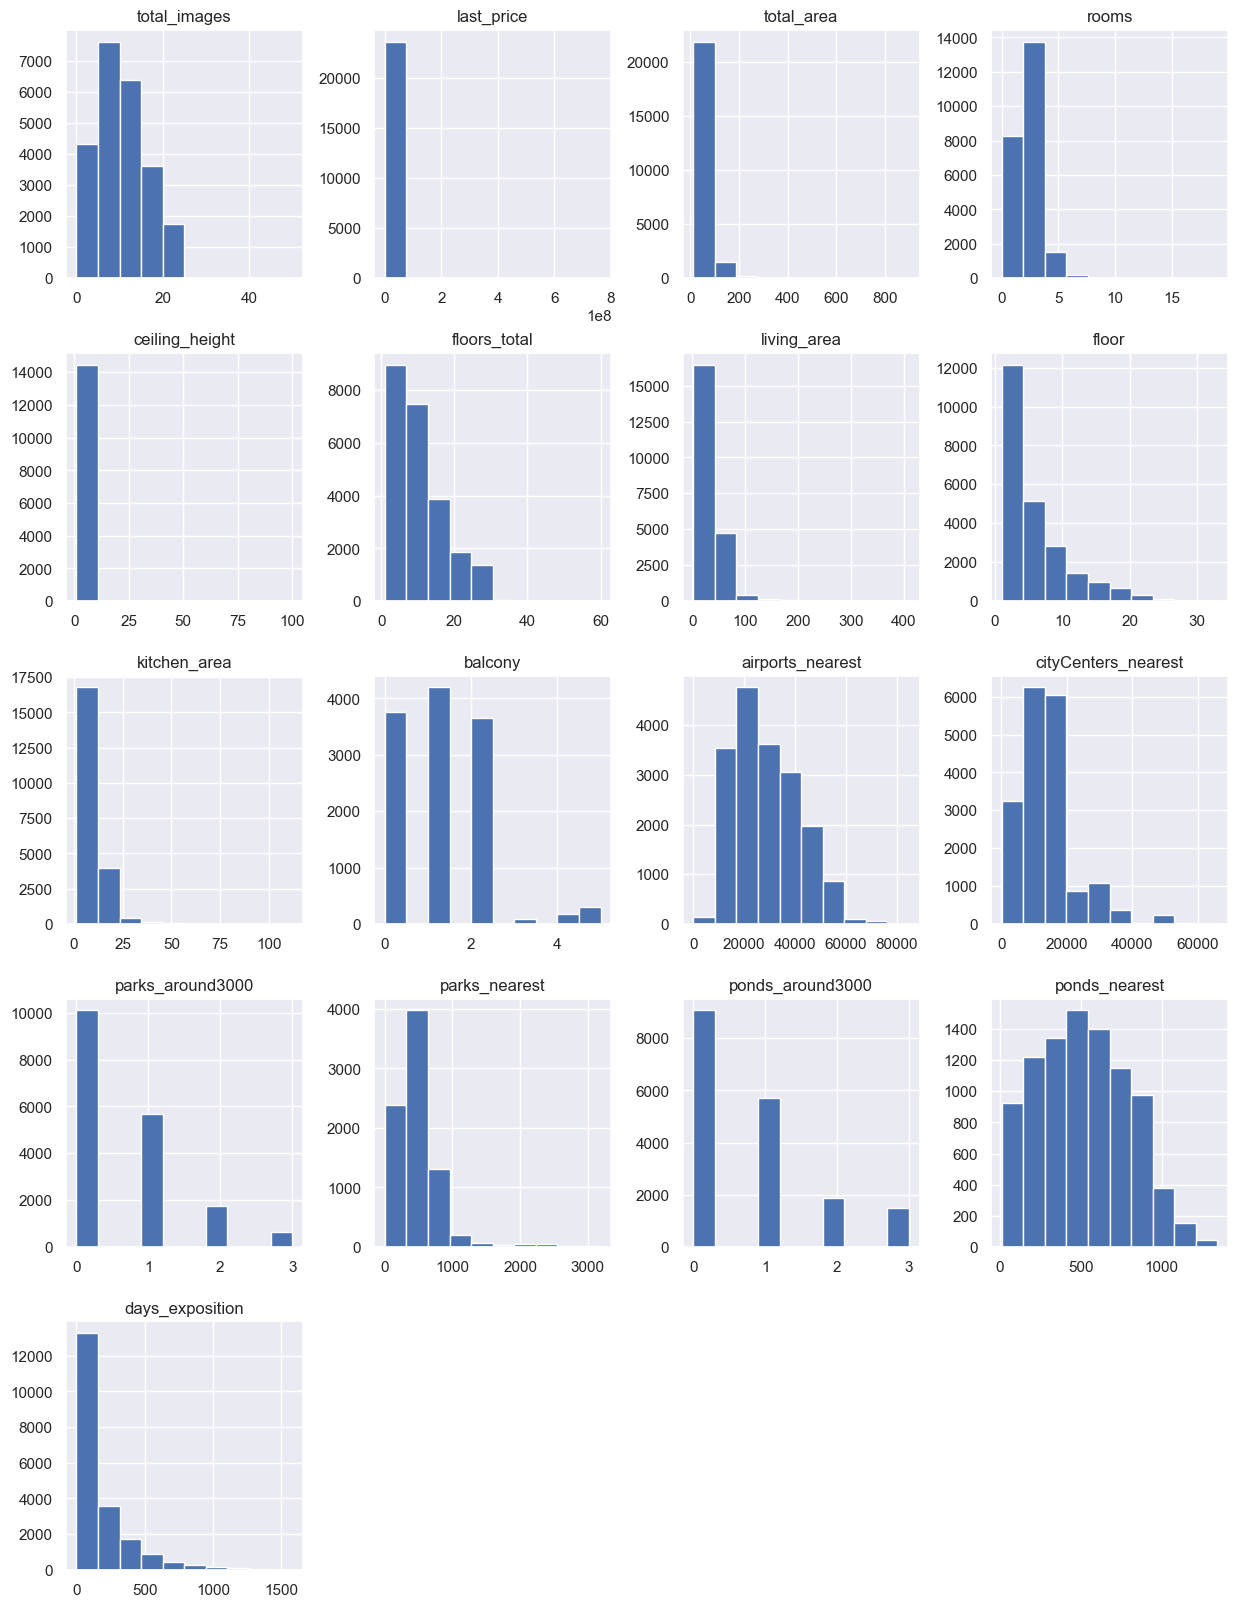

In [4]:
data.hist(figsize=(15,20))
plt.show()

На первый взгляд, судя по меткам данных в графиках, а также по описанию данных, в датасете присутствуют нестандартные, а может и аномальные значения: так, в столбце last_price наблюдаем значение в 763 млн. руб. при среднем значении в 6.5 млн. руб.,в total_area присутствуют значения квартир общей площадью до 900 кв. м., в столбце rooms количество комнат в некоторых случаях достигает больше 15, в столбце ceiling_height высота потолков достигает 100 м., стоит также обратить внимание на общее количество этажей в здании в столбце floors_total, поскольку в Ленобласти вряд ли есть жилые здания с подобным количеством этажей (40 и выше). Необычными также выглядят максимальные значения в столбцах living_area и kirchen_area

## Предобработка данных

### Обработка пропусков и дубликатов

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64


<Axes: >

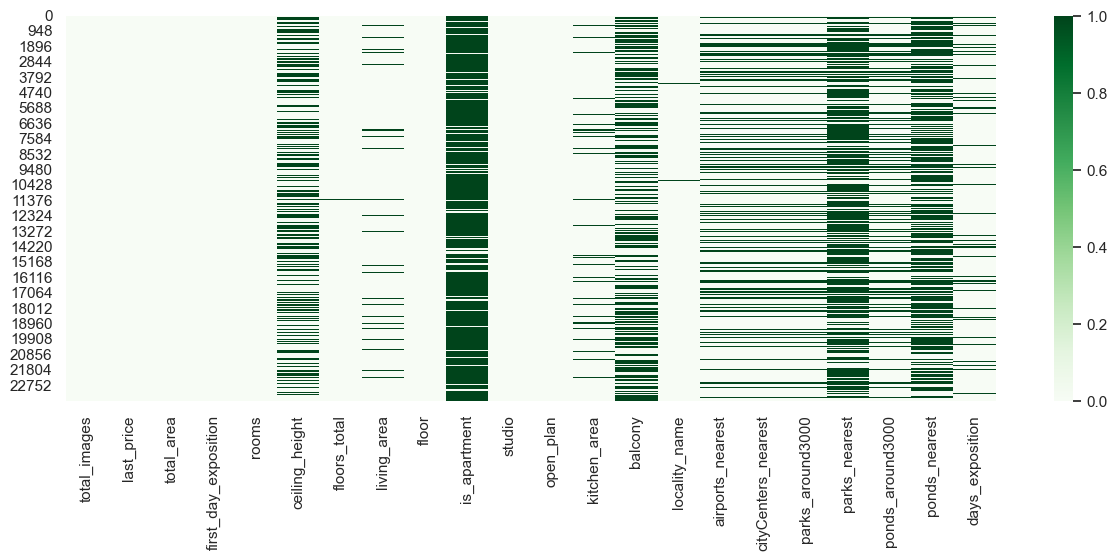

In [5]:
print(data.isna().sum())
sns.heatmap(data.isna(),cmap = 'Greens')

Посчитаем долю пропусков

In [6]:
data.isnull().mean() * 100

total_images            0.00
last_price              0.00
total_area              0.00
first_day_exposition    0.00
rooms                   0.00
ceiling_height         38.80
floors_total            0.36
living_area             8.03
floor                   0.00
is_apartment           88.29
studio                  0.00
open_plan               0.00
kitchen_area            9.61
balcony                48.61
locality_name           0.21
airports_nearest       23.38
cityCenters_nearest    23.29
parks_around3000       23.28
parks_nearest          65.91
ponds_around3000       23.28
ponds_nearest          61.56
days_exposition        13.42
dtype: float64

Уберём пропуски в столбцах ceiling_height, floors_total, living_area, is_apartment, kitchen_area, balcony, locality_name, days_exposition.  
В некоторых столбцах доля пропущенных значений составляет почти до 90%.

Установим наличие дубликатов

In [7]:
data.duplicated().sum()

0

Заменим пропуски в столбце is_apartment на False, поскольку жилые помещения, являющиеся апартаментами, скорее всего,
изначально были бы помечены как апартаменты

In [8]:
data['is_apartment'].fillna(False, inplace=True)

Заменим пропуски в столбце ceiling_height на моду

In [9]:
data['ceiling_height'].fillna(statistics.mode(data['ceiling_height']), inplace=True)

Поскольку количество пропущенных значений общего количества этажей невелико, удалим их

In [10]:
data.dropna(subset=['floors_total'],inplace=True)

Заменим значения в столбце living_area на медианные значения по группам (по количеству комнат)

In [11]:
data['living_area'] = data['living_area'].fillna(data.groupby('rooms')['living_area'].transform('median'))

Заполним пропущенные значения в столбце balcony нулями, поскольку, если продавец не указал число балконов, то, скорее всего, в его квартире их нет

In [12]:
data['balcony'].fillna(0, inplace=True)
data['balcony'].value_counts()

balcony
0.00    15193
1.00     4195
2.00     3657
5.00      304
4.00      183
3.00       81
Name: count, dtype: int64

Для студий размер кухни, а также количество комнат сделаем равным 0. Запомлним пропущенные значения в столбце kitchen_area, основываясь на доле кухни от общей площади по количеству комнат

In [13]:
data['kitchen_area'].where(data['studio'] != True, 0, inplace=True)
data['rooms'].where(data['studio'] != True, 0, inplace=True)

for i in range(1, data['rooms'].max()):
    ratio = (data[data['rooms'] == i]['kitchen_area'] / data[data['rooms'] == i]['total_area']).median()
    data['kitchen_area'] = data['kitchen_area'].fillna(value = data['total_area'] * ratio)

Поскольку неясно чем заменить пропуски в столбце days_exposition, оставим столбце как есть

Удалим пропуски в locality_name

In [14]:
data.dropna(subset=['locality_name'],inplace=True)

Проверим количество пропусков

In [15]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5524
cityCenters_nearest      5501
parks_around3000         5500
parks_nearest           15535
ponds_around3000         5500
ponds_nearest           14529
days_exposition          3171
dtype: int64

Все возможные для замены пропуски ликвидированы, остальные пропуски оставим как есть

Разберёмся с дубликатами в названиях насёленных пунктов (locality_name)

In [16]:
data['locality_name'] = (data['locality_name']
                         .str.replace('ё', 'е')
                         .replace
                         (['поселок городского типа', 'поселок', 'городской поселок', 'городской п.', 'коттеджный п.',
                           'п. при железнодорожной станции ', 'поселок при железнодорожной станции ', 'поселок станции','п. при станции',
                           'поселок при железнодорожной станции ', 'п. станции', 'п. имени', 'при железнодорожной станции',
                           'п. при железнодорожной станции'],'п.'
                          ,regex=True)
                        )

data['locality_name'] = data['locality_name'].str.replace('ё', 'е').replace(['село'],'с.', regex=True)

data['locality_name'] = data['locality_name'].str.replace('ё', 'е').replace(['деревня'],'д.', regex=True)

data['locality_name'] = (data['locality_name']
                         .str.replace('ё', 'е')
                         .replace(['садовое товарищество', 'садовое некоммерческое товарищество', 'садоводческое некоммерческое товарищество'],'снт.'
                                  ,regex=True)
                        )

data['locality_name'] = data['locality_name'].str.replace('ё', 'е').replace(['Мурино', 'п. Мурино', 'п.Мурино'],'Мурино', regex=True)

data['locality_name'].unique()

array(['Санкт-Петербург', 'п. Шушары', 'п. Янино-1', 'п. Парголово',
       'Мурино', 'Ломоносов', 'Сертолово', 'Петергоф', 'Пушкин',
       'д. Кудрово', 'Коммунар', 'Колпино', 'п. Красный Бор', 'Гатчина',
       'д. Федоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'д. Новое Девяткино', 'п. Металлострой', 'п. Лебяжье',
       'п. Сиверский', 'п. Молодцово', 'п. Кузьмоловский',
       'снт. Новая Ропша', 'Павловск', 'д. Пикколово', 'Всеволожск',
       'Волхов', 'Кингисепп', 'Приозерск', 'Сестрорецк', 'д. Куттузи',
       'п. Аннино', 'п. Ефимовский', 'п. Плодовое', 'д. Заклинье',
       'п. Торковичи', 'п. Первомайское', 'Красное Село', 'п. Понтонный',
       'Сясьстрой', 'д. Старая', 'д. Лесколово', 'п. Новый Свет',
       'Сланцы', 'с. Путилово', 'Ивангород', 'Шлиссельбург', 'Никольское',
       'Зеленогорск', 'Сосновый Бор', 'д. Оржицы', 'д. Кальтино',
       'Кудрово', 'п. Романовка', 'п. Бугры', 'п. Рощино', 'Кириши',
       'Луга', 'Волосово', 'Отрадное', 'с. Павлово', 'п.

In [17]:
def place_short(text):
    dict =['д. ','п. ','снт. ', 'с. ']
    for i in dict:
        text = text.replace(i, '')  
    return text   
# создадим столбец с укороченными названиями
data['locality_name'] = data['locality_name'].apply(place_short)
# посмотрим, что получилось
print(data.locality_name.sample(20))

20342             Сланцы
10557           Петергоф
1234     Санкт-Петербург
17283             Сумино
17893         Всеволожск
21938         Всеволожск
15824             Шушары
11370          Кронштадт
15351            Колпино
19423    Санкт-Петербург
4399              Шушары
15319    Санкт-Петербург
9744     Санкт-Петербург
2356     Санкт-Петербург
3987     Санкт-Петербург
20576         Никольское
2478     Санкт-Петербург
15214    Санкт-Петербург
2363              Шушары
11015            Гатчина
Name: locality_name, dtype: object


Таким образом, в столбце с названиями населённых пунктов значения приведены в единый вид биз указания типа населённого пункта (к примеру, Санкт-Петербург, Мурино, Парголов и т.д.)

### Изменение типов данных в столбцах

Приведём данные в столбце first_day_exposition в формат даты

In [18]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

In [19]:
print(data['is_apartment'].value_counts())
print(data['studio'].value_counts())
data['open_plan'].value_counts()

is_apartment
False    23515
True        50
Name: count, dtype: int64
studio
False    23419
True       146
Name: count, dtype: int64


open_plan
False    23498
True        67
Name: count, dtype: int64

Заменим тип данных в days_exposition, floors_total, balcony на int

In [20]:
data['floors_total'] = data['floors_total'].astype('int')
data['balcony'] = data['balcony'].astype('int')

# is_apartment, studio, open_plan на int
data['is_apartment'] = data['is_apartment'].astype('int')
data['studio'] = data['studio'].astype('int')
data['open_plan'] = data['open_plan'].astype('int')

# проверим, что всё корректно заменилось
print(data['is_apartment'].value_counts())
print(data['studio'].value_counts())
data['open_plan'].value_counts()

is_apartment
0    23515
1       50
Name: count, dtype: int64
studio
0    23419
1      146
Name: count, dtype: int64


open_plan
0    23498
1       67
Name: count, dtype: int64

Переименуем столбец cityCenters_nearest для соответствия единому стилю

In [21]:
data = data.rename(columns={'cityCenters_nearest' : 'city_centers_nearest'})

In [22]:
# посмотрим на данные
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23565 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23565 non-null  int64         
 1   last_price            23565 non-null  float64       
 2   total_area            23565 non-null  float64       
 3   first_day_exposition  23565 non-null  datetime64[ns]
 4   rooms                 23565 non-null  int64         
 5   ceiling_height        23565 non-null  float64       
 6   floors_total          23565 non-null  int32         
 7   living_area           23565 non-null  float64       
 8   floor                 23565 non-null  int64         
 9   is_apartment          23565 non-null  int32         
 10  studio                23565 non-null  int32         
 11  open_plan             23565 non-null  int32         
 12  kitchen_area          23565 non-null  float64       
 13  balcony              

### Добавление новых столбцов

Добавим столбец со стоимость 1 кв. метра и округлим до 2 знаков после запятой

In [23]:
data['cost_per_m2'] = (data['last_price']/data['total_area']).round(2)

Создадим столбцы с днём недели, месяцем и годом публикации о продаже недвижимости

In [24]:
data['publish_dayofweek'] = data['first_day_exposition'].dt.weekday
data['publish_month'] = data['first_day_exposition'].dt.month
data['publish_year'] = data['first_day_exposition'].dt.year

# переведем тип данных на object для дальнейшего исследования категориальных переменных
data['publish_dayofweek'] = data['publish_dayofweek'].astype('object')
data['publish_month'] = data['publish_month'].astype('object')
data['publish_year'] = data['publish_year'].astype('object')

Добавим столбец с типом этажа квартиры (первый, последний и другой)

In [25]:
def categorize_floor(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'
data['floor_category'] = data.apply(categorize_floor, axis=1)

Добавим столбец с расстоянием до центра в км. и округлим до ближайщих значений

In [26]:
data = data.rename(columns={'cityCenters_nearest':'city_centers_nearest'})
data['city_centers_nearest_km'] = (data['city_centers_nearest']/1000).round()

In [27]:
data['city_centers_nearest_km'].head(10)

0   16.00
1   19.00
2   14.00
3    7.00
4    8.00
5     NaN
6   19.00
7   12.00
8     NaN
9   15.00
Name: city_centers_nearest_km, dtype: float64

## Исследовательский анализ данных

Посмотрим описание данных

In [28]:
data.describe()

total_images   last_price  total_area           first_day_exposition  \
count      23565.00     23565.00    23565.00                          23565   
mean           9.88   6540058.26       60.32  2017-11-10 08:59:53.125398016   
min            0.00     12190.00       12.00            2014-11-27 00:00:00   
25%            6.00   3400000.00       40.00            2017-05-15 00:00:00   
50%            9.00   4646000.00       52.00            2017-12-12 00:00:00   
75%           14.00   6790000.00       69.70            2018-08-26 00:00:00   
max           50.00 763000000.00      900.00            2019-05-03 00:00:00   
std            5.68  10910934.72       35.66                            NaN   

         rooms  ceiling_height  floors_total  living_area    floor  \
count 23565.00        23565.00      23565.00     23565.00 23565.00   
mean      2.07            2.67         10.68        34.32     5.88   
min       0.00            1.00          1.00         2.00     1.00   
25%       1.00            2.50          5.00        18.40     2.00   
50%       2.00            2.50          9.00        30.30     4.00   
75%       3.00            2.70         16.00        42.70     8.00   
max      19.00          100.00         60.00       409.70    33.00   
std       1.08            1.00          6.59        21.72     4.87   

       is_apartment   studio  open_plan  kitchen_area  balcony  \
count      23565.00 23565.00   23565.00      23565.00 23565.00   
mean           0.00     0.01       0.00         10.85     0.59   
min            0.00     0.00       0.00          0.00     0.00   
25%            0.00     0.00       0.00          7.10     0.00   
50%            0.00     0.00       0.00          9.42     0.00   
75%            0.00     0.00       0.00         12.00     1.00   
max            1.00     1.00       1.00        123.89     5.00   
std            0.05     0.08       0.05          6.55     0.96   

       airports_nearest  city_centers_nearest  parks_around3000  \
count          18041.00              18064.00          18065.00   
mean           28797.08              14192.66              0.61   
min                0.00                181.00              0.00   
25%            18565.00               9238.00              0.00   
50%            26757.00              13096.50              0.00   
75%            37273.00              16285.00              1.00   
max            84869.00              65968.00              3.00   
std            12632.50               8613.35              0.80   

       parks_nearest  ponds_around3000  ponds_nearest  days_exposition  \
count        8030.00          18065.00        9036.00         20394.00   
mean          490.58              0.77         518.29           180.74   
min             1.00              0.00          13.00             1.00   
25%           288.00              0.00         293.00            45.00   
50%           455.00              1.00         503.00            95.00   
75%           612.00              1.00         730.00           231.00   
max          3190.00              3.00        1344.00          1580.00   
std           341.57              0.94         278.01           219.73   

       cost_per_m2  city_centers_nearest_km  
count     23565.00                 18064.00  
mean      99405.84                    14.19  
min         111.83                     0.00  
25%       76566.13                     9.00  
50%       95000.00                    13.00  
75%      114213.20                    16.00  
max     1907500.00                    66.00  
std       50389.43                     8.62

### Стоимость (last_price)

Разделим столбец last_price на 1000 для удобства анализа

In [29]:
data['last_price'] = data['last_price']/1000
print(data['last_price'].describe(percentiles=[0.1,0.25,0.5,0.75,0.9]))

count    23565.00
mean      6540.06
std      10910.93
min         12.19
10%       2500.00
25%       3400.00
50%       4646.00
75%       6790.00
90%      10900.00
max     763000.00
Name: last_price, dtype: float64


In [30]:
data.sort_values(by='last_price').head(10)

total_images  last_price  total_area first_day_exposition  rooms  \
8793              7       12.19      109.00           2019-03-20      2   
17456             7      430.00       30.40           2019-04-22      1   
14911             5      430.00       54.00           2018-06-26      2   
16274            18      440.00       40.00           2018-07-10      1   
9581              7      450.00       43.40           2018-08-31      2   
17676             0      450.00       36.50           2018-02-01      1   
16219            14      450.00       38.50           2018-07-11      2   
5698              7      450.00       42.00           2017-07-31      2   
18867             1      470.00       41.00           2018-02-11      1   
23484            11      470.00       44.50           2018-07-02      2   

       ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
8793             2.75            25        32.00     25             0       0   
17456            2.50             2        16.00      1             0       0   
14911            2.50             3        30.50      3             0       0   
16274            2.50             5        17.60      1             0       0   
9581             2.50             5        30.30      3             0       0   
17676            2.50             5        17.30      4             0       0   
16219            2.65             2        30.50      1             0       0   
5698             2.50             1        23.00      1             0       0   
18867            2.50             5        32.00      3             0       0   
23484            2.50             2        28.00      2             0       0   

       open_plan  kitchen_area  balcony    locality_name  airports_nearest  \
8793           0         40.50        0  Санкт-Петербург          36421.00   
17456          0          6.00        0           Сланцы               NaN   
14911          0         13.38        0    станции Свирь               NaN   
16274          0          9.91        0       Старополье               NaN   
9581           0          5.50        0       Старополье               NaN   
17676          0          8.50        1        Ям-Тесово               NaN   
16219          0          9.54        0     Вахнова Кара               NaN   
5698           0          5.80        0         Будогощь               NaN   
18867          0          9.00        0         Выскатка               NaN   
23484          0          7.50        0           Сланцы               NaN   

       city_centers_nearest  parks_around3000  parks_nearest  \
8793                9176.00              1.00         805.00   
17456                   NaN               NaN            NaN   
14911                   NaN               NaN            NaN   
16274                   NaN               NaN            NaN   
9581                    NaN               NaN            NaN   
17676                   NaN               NaN            NaN   
16219                   NaN               NaN            NaN   
5698                    NaN               NaN            NaN   
18867                   NaN               NaN            NaN   
23484                   NaN               NaN            NaN   

       ponds_around3000  ponds_nearest  days_exposition  cost_per_m2  \
8793               0.00            NaN             8.00       111.83   
17456               NaN            NaN              NaN     14144.74   
14911               NaN            NaN            44.00      7962.96   
16274               NaN            NaN            45.00     11000.00   
9581                NaN            NaN            96.00     10368.66   
17676               NaN            NaN           120.00     12328.77   
16219               NaN            NaN            45.00     11688.31   
5698                NaN            NaN           233.00     10714.29   
18867               NaN            NaN            46.00     11463.41   
23484

Видим, что минимальное значение не соответствует адекватному распределению стоимости квартир.
Помимо этого наблюдаем слишком высокое значение стандартной ошибки по сравнению со средним значением.

Выявим среднюю стоимость квартир площадью около 100 кв.м в Санкт-Петербурге

In [31]:
data.query("(100<=total_area<=110) & (locality_name == 'Санкт-Петербург')")['last_price'].median()

12508.697

Умножим минимальное значение стоимости квартир на 1.000, поскольку такое значение будет близко к посчитанной выше медиане

In [32]:
data.loc[data['last_price'] == data['last_price'].min(), 'last_price'] = data['last_price'].min() * 1000
data['last_price'].describe(percentiles=[0.1,0.25,0.5,0.75,0.9, 0.95, 0.99])

count    23565.00
mean      6540.58
std      10910.91
min        430.00
10%       2500.00
25%       3400.00
50%       4647.00
75%       6790.00
90%      10900.00
95%      15300.00
99%      36000.00
max     763000.00
Name: last_price, dtype: float64

Проверим макс. значение стоимости квартир

In [33]:
data.loc[data['last_price'] == data['last_price'].max()]

total_images  last_price  total_area first_day_exposition  rooms  \
12971            19   763000.00      400.00           2017-09-30      7   

       ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
12971            2.50            10       250.00     10             0       0   

       open_plan  kitchen_area  balcony    locality_name  airports_nearest  \
12971          0         99.12        2  Санкт-Петербург          25108.00   

       city_centers_nearest  parks_around3000  parks_nearest  \
12971               3956.00              1.00         530.00   

       ponds_around3000  ponds_nearest  days_exposition  cost_per_m2  \
12971              3.00         756.00            33.00   1907500.00   

      publish_dayofweek publish_month publish_year floor_category  \
12971                 5             9         2017      последний   

       city_centers_nearest_km  
12971                     4.00

Уберём аномальное значение

In [34]:
data = data.query('last_price < 500000')

Построим графики распределения стоимости недвижимости

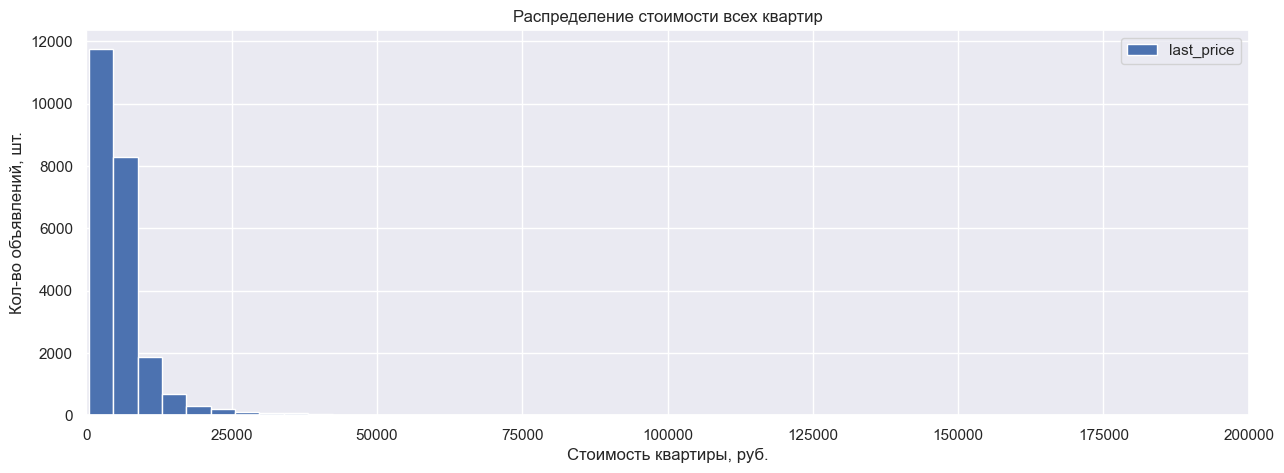

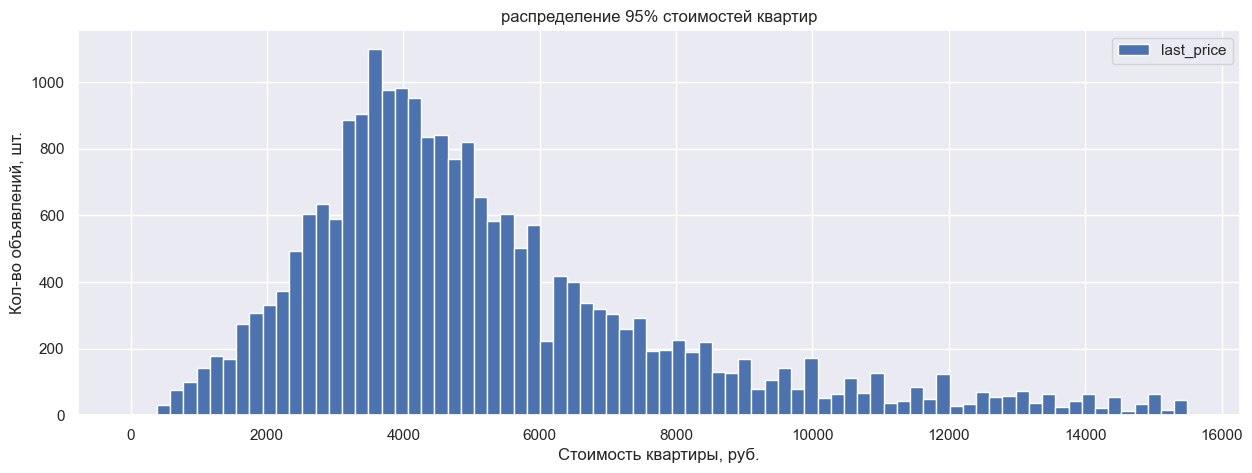

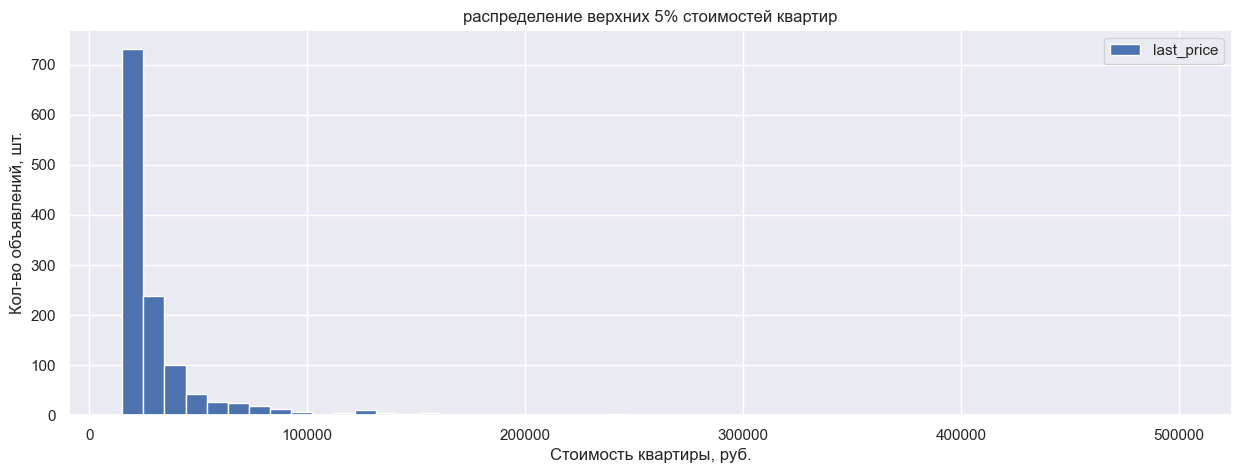

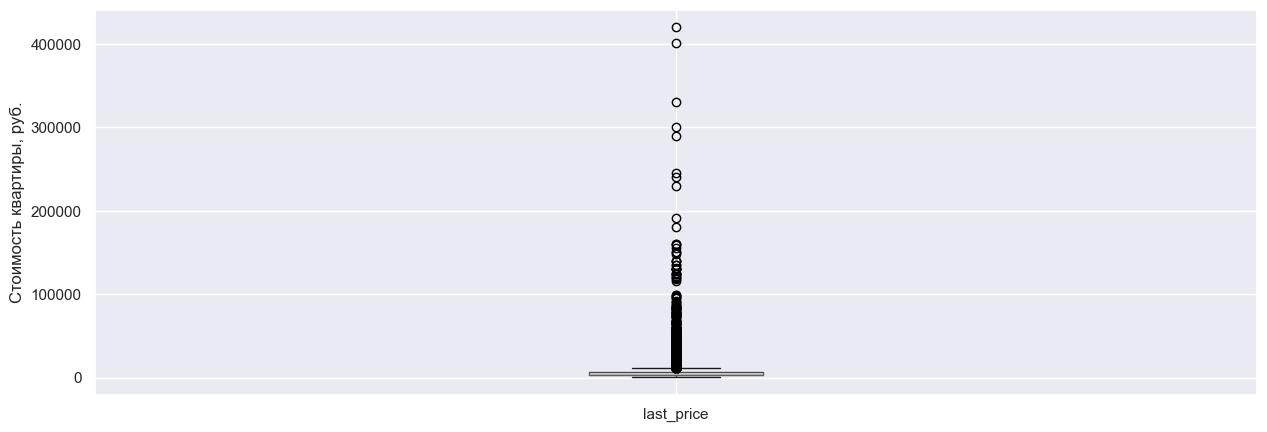

In [35]:
# построим необходимые графики
# распределение стоимости всех квартир
data.plot(kind='hist', y='last_price', grid=True,bins=100, figsize=(15,5), xlim=(0,200000))
plt.title('Распределение стоимости всех квартир')
plt.xlabel('Стоимость квартиры, руб.')
plt.ylabel('Кол-во объявлений, шт.')
plt.show()

# распределение 95% стоимостей квартир
data.plot(kind='hist', y='last_price', grid=True, bins=80, figsize=(15,5), range=(0, 15500))
plt.title('распределение 95% стоимостей квартир')
plt.xlabel('Стоимость квартиры, руб.')
plt.ylabel('Кол-во объявлений, шт.')
plt.show()

# распределение верхних 5% стоимостей квартир
data.plot(kind='hist', y='last_price', grid=True, bins=50, figsize=(15,5), range=(15000, 500000))
plt.title('распределение верхних 5% стоимостей квартир')
plt.xlabel('Стоимость квартиры, руб.')
plt.ylabel('Кол-во объявлений, шт.')
plt.show()

# график с усами
data.boxplot(column='last_price', grid=True, figsize=(15,5))
plt.ylabel('Стоимость квартиры, руб.')
plt.show()

- 95% стоимости всех квартир приходится на сумму до 15.3 млн. руб.
- среднее значение стоимости квартир равно 6.6 млн. руб, а медиана равна 4.65 млн. руб. Стандартное отклонение всё так же намного выше среднего значения
- распределение искажается из-за сильных выбросов (1% стоимости квартир свыше 36.7 млн. руб.)
- усатый график отображает данные максимально ненаглядно, однако по нему видно, что выбросов очень много

### Общая площадь (total_area)

In [36]:
print(data['total_area'].describe(percentiles=[0.1,0.25,0.5,0.75,0.9,0.95,0.99]))

count   23564.00
mean       60.31
std        35.59
min        12.00
10%        33.00
25%        40.00
50%        52.00
75%        69.70
90%        93.40
95%       116.00
99%       197.07
max       900.00
Name: total_area, dtype: float64


Посмотрим на минимальное значение в столбце

In [37]:
data.loc[data['total_area'] == data['total_area'].min()]

total_images  last_price  total_area first_day_exposition  rooms  \
19904             4     2400.00       12.00           2017-07-19      1   

       ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
19904            2.55             5        10.00      2             0       0   

       open_plan  kitchen_area  balcony    locality_name  airports_nearest  \
19904          0          2.97        0  Санкт-Петербург          21314.00   

       city_centers_nearest  parks_around3000  parks_nearest  \
19904                964.00              1.00         886.00   

       ponds_around3000  ponds_nearest  days_exposition  cost_per_m2  \
19904              2.00          45.00           200.00    200000.00   

      publish_dayofweek publish_month publish_year floor_category  \
19904                 2             7         2017         другой   

       city_centers_nearest_km  
19904                     1.00

В целом, значение не выглядит аномальным, поэтому оставляем его

Посмотрим на максимальное значение в столбце

In [38]:
data.sort_values(by='total_area').tail(10)

total_images  last_price  total_area first_day_exposition  rooms  \
12401            20    91500.00      495.00           2017-06-19      7   
15016             8   150000.00      500.00           2016-01-13      4   
5893              3   230000.00      500.00           2017-05-31      6   
8018             20    84000.00      507.00           2015-12-17      5   
4237              1    50000.00      517.00           2017-10-14      7   
5358             20    65000.00      590.00           2019-02-14     15   
15651            20   300000.00      618.00           2017-12-18      7   
3117             19   140000.00      631.00           2019-03-30      7   
12859            20   140000.00      631.20           2019-04-09      7   
19540             8   420000.00      900.00           2017-12-06     12   

       ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
12401            4.65             7       347.50      7             0       0   
15016            3.20             7        63.50      7             0       0   
5893             2.50             7       124.40      7             0       0   
8018             4.45             7       301.50      7             1       0   
4237             2.50             4       332.00      3             0       0   
5358             3.50             6       409.00      3             0       0   
15651            3.40             7       258.00      5             0       0   
3117             2.50             5       145.00      5             0       0   
12859            3.90             4       322.30      4             0       0   
19540            2.80            25       409.70     25             0       0   

       open_plan  kitchen_area  balcony    locality_name  airports_nearest  \
12401          0         25.00        0  Санкт-Петербург               NaN   
15016          0        123.89        0  Санкт-Петербург          33058.00   
5893           0         40.00        0  Санкт-Петербург          32440.00   
8018           0         45.50        1  Санкт-Петербург               NaN   
4237           0         22.00        0  Санкт-Петербург          22835.00   
5358           0        100.00        0  Санкт-Петербург          24447.00   
15651          0         70.00        0  Санкт-Петербург          32440.00   
3117           0         60.00        0  Санкт-Петербург          25707.00   
12859          0         19.50        1  Санкт-Петербург          25707.00   
19540          0        112.00        0  Санкт-Петербург          30706.00   

       city_centers_nearest  parks_around3000  parks_nearest  \
12401               5735.00              2.00         110.00   
15016               6150.00              3.00         209.00   
5893                5297.00              0.00            NaN   
8018                5735.00              2.00         110.00   
4237                1847.00              2.00         477.00   
5358                4666.00              1.00         767.00   
15651               5297.00              0.00            NaN   
3117                4972.00              0.00            NaN   
12859               4972.00              0.00            NaN   
19540               7877.00              0.00            NaN   

       ponds_around3000  ponds_nearest  days_exposition  cost_per_m2  \
12401              0.00            NaN            14.00    184848.48   
15016              3.00         531.00           303.00    300000.00   
5893               2.00         198.00            50.00    460000.00   
8018               0.00            NaN          1078.00    165680.47   
4237               2.00         540.00              NaN     96711.80   
5358               0.00            NaN            14.00    110169.49   
15651              2.00         198.00           111.00    485436.89   
3117               2.00         210.00              NaN    221870.05   
12859              2.00         210.00              NaN    221799.75   
19540

Максимальное значение выглядит аномальным и может искажать данные, поэтому удалим его

In [39]:
data = data.query('total_area < 900')

Построим необходимые графики

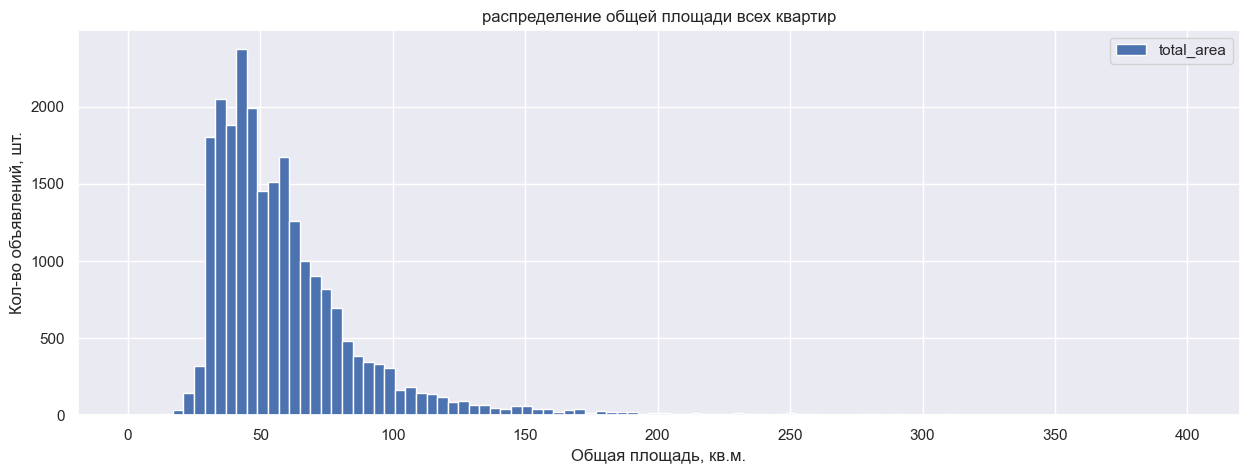

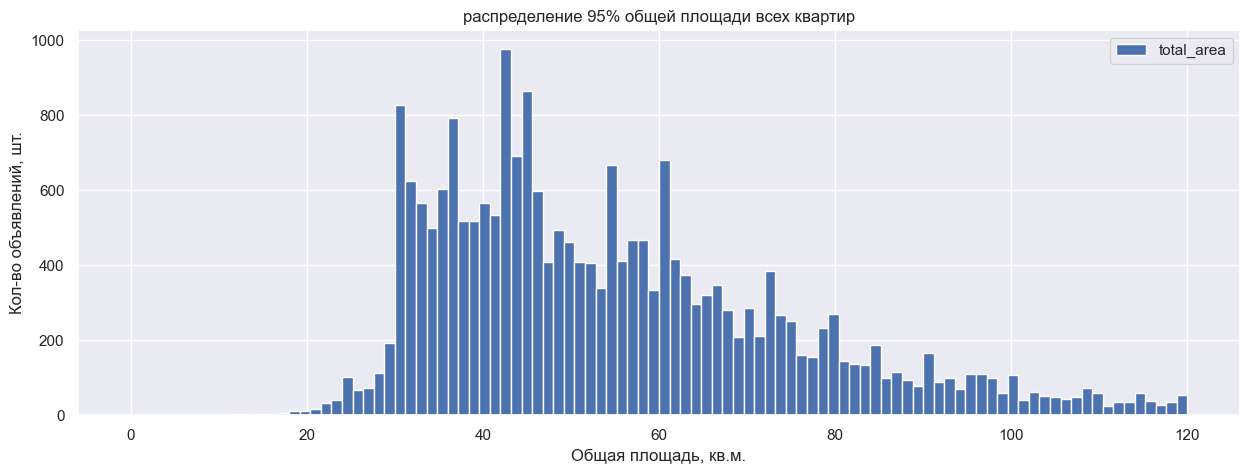

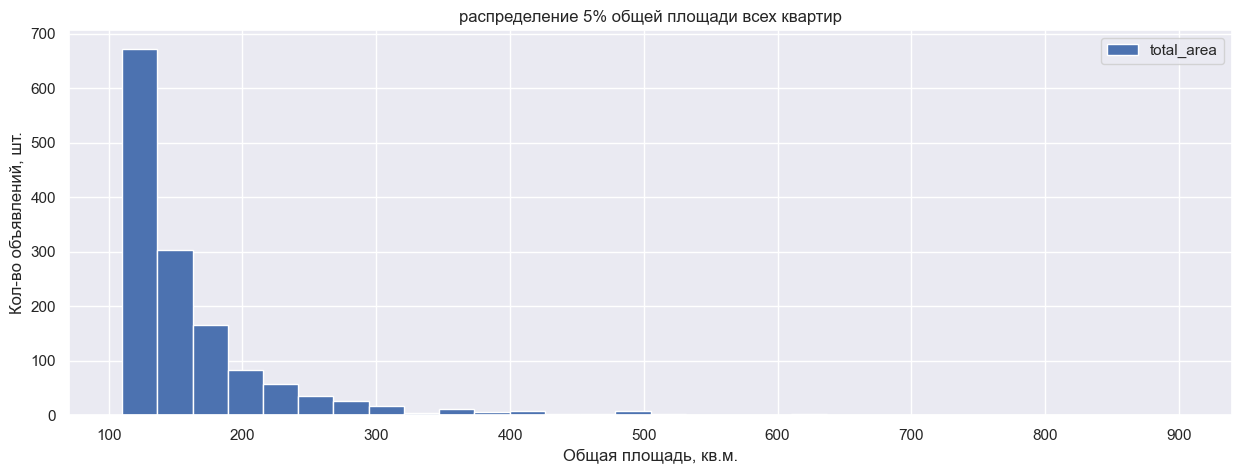

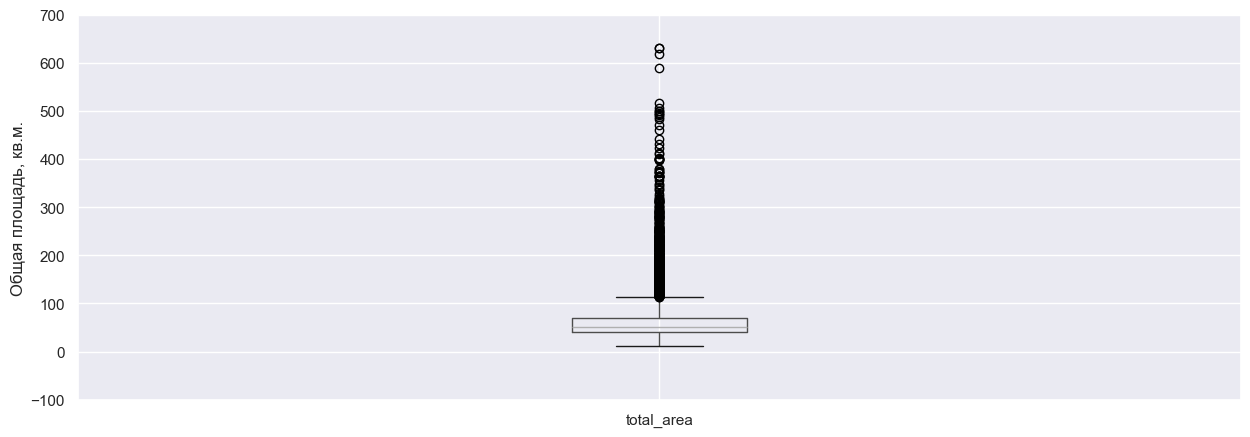

In [40]:
# распределение общей площади всех квартир
data.plot(kind='hist', y='total_area', grid=True, bins=100, range=(1,400), figsize=(15,5))
plt.title('распределение общей площади всех квартир')
plt.xlabel('Общая площадь, кв.м.')
plt.ylabel('Кол-во объявлений, шт.')
plt.show()

# распределение 95% общей площади квартир квартир
data.plot(kind='hist', y='total_area', grid=True, bins=100, figsize=(15,5), range=(0, 120))
plt.title('распределение 95% общей площади всех квартир')
plt.xlabel('Общая площадь, кв.м.')
plt.ylabel('Кол-во объявлений, шт.')
plt.show()

# распределение верхнего 5% общей площади квартир
data.plot(kind='hist', y='total_area', grid=True, bins=30, figsize=(15,5), range=(110, 900))
plt.title('распределение 5% общей площади всех квартир')
plt.xlabel('Общая площадь, кв.м.')
plt.ylabel('Кол-во объявлений, шт.')
plt.show()

# график с усами
data.boxplot(column='total_area', grid=True, figsize=(15,5))
plt.ylim(-100,700)
plt.ylabel('Общая площадь, кв.м.')
plt.show()

Распределение данных в столбец total_area вполне ожидаемое: 
- среднее равно 60 кв.м., медиана равна 52 кв.м, а ст. ошибка меньше среднего
- 95% распределения расположено в пределах 116 кв.м.
- выбросов за пределами нормального распределения (верхнего уса) много, однако такие значения всё-таки редкие, поскольку медиана не сильно стремится к длинному хвосту высоких значений

### Жилая площадь (living_area)

In [41]:
print(data['living_area'].describe(percentiles=[0.01,0.1,0.25,0.5,0.75,0.9,0.95,0.99]))

count   23563.00
mean       34.30
std        21.54
min         2.00
1%         13.10
10%        16.60
25%        18.40
50%        30.30
75%        42.70
90%        54.60
95%        68.00
99%       118.44
max       409.00
Name: living_area, dtype: float64


In [42]:
data.sort_values(by='living_area').head(10)

total_images  last_price  total_area first_day_exposition  rooms  \
13915            20     6350.00       52.00           2018-02-06      2   
21758             0     2330.00       23.00           2018-01-01      0   
23574            14    64990.00      139.00           2015-11-24      3   
3242              7     4440.00       41.00           2017-07-02      1   
17582            11     2680.00       22.00           2018-08-11      0   
21943            15     6100.00       77.60           2019-02-28      4   
16431            13     3799.00       31.00           2018-04-12      1   
19251            19     4050.00       33.00           2018-10-15      1   
20994             7     8900.00       50.60           2018-10-22      2   
23208            12     4800.00       37.00           2016-02-24      1   

       ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
13915            3.00             6         2.00      2             0       0   
21758            2.50            24         2.00     22             0       1   
23574            3.00             8         3.00      8             0       0   
3242             2.50            17         3.00     17             0       0   
17582            2.50            25         5.00      8             0       1   
21943            2.50             9         5.40      1             0       0   
16431            2.60             5         6.00      1             0       0   
19251            2.50            22         6.50     21             0       0   
20994            2.50             7         8.00      3             0       0   
23208            2.50            14         8.00     11             0       0   

       open_plan  kitchen_area  balcony    locality_name  airports_nearest  \
13915          0          9.00        0  Санкт-Петербург          32453.00   
21758          0          0.00        0           Мурино               NaN   
23574          0         16.00        1  Санкт-Петербург          33255.00   
3242           0         11.00        0  Санкт-Петербург          19272.00   
17582          0          0.00        2  Санкт-Петербург          22735.00   
21943          0          9.80        0  Санкт-Петербург          29338.00   
16431          0         17.00        0  Санкт-Петербург          32177.00   
19251          0         18.00        0  Санкт-Петербург           9258.00   
20994          0         31.00        0  Санкт-Петербург          12771.00   
23208          0         22.00        0  Санкт-Петербург          27838.00   

       city_centers_nearest  parks_around3000  parks_nearest  \
13915               6521.00              0.00            NaN   
21758                   NaN               NaN            NaN   
23574               5975.00              1.00         630.00   
3242               13073.00              0.00            NaN   
17582              11618.00              1.00         835.00   
21943              11270.00              1.00         584.00   
16431               4826.00              1.00         430.00   
19251              10592.00              1.00         458.00   
20994               8301.00              1.00         173.00   
23208              12387.00              2.00         358.00   

       ponds_around3000  ponds_nearest  days_exposition  cost_per_m2  \
13915              1.00        1012.00            91.00    122115.38   
21758               NaN            NaN            66.00    101304.35   
23574              3.00         100.00           280.00    467553.96   
3242               0.00            NaN           216.00    108292.68   
17582              1.00         652.00            70.00    121818.18   
21943              0.00            NaN            33.00     78608.25   
16431              0.00            NaN           168.00    122548.39   
19251              0.00            NaN            44.00    122727.27   
20994              3.00         126.00              NaN    175889.33   
23208

In [43]:
data.query('living_area < 5')

total_images  last_price  total_area first_day_exposition  rooms  \
3242              7     4440.00       41.00           2017-07-02      1   
13915            20     6350.00       52.00           2018-02-06      2   
21758             0     2330.00       23.00           2018-01-01      0   
23574            14    64990.00      139.00           2015-11-24      3   

       ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
3242             2.50            17         3.00     17             0       0   
13915            3.00             6         2.00      2             0       0   
21758            2.50            24         2.00     22             0       1   
23574            3.00             8         3.00      8             0       0   

       open_plan  kitchen_area  balcony    locality_name  airports_nearest  \
3242           0         11.00        0  Санкт-Петербург          19272.00   
13915          0          9.00        0  Санкт-Петербург          32453.00   
21758          0          0.00        0           Мурино               NaN   
23574          0         16.00        1  Санкт-Петербург          33255.00   

       city_centers_nearest  parks_around3000  parks_nearest  \
3242               13073.00              0.00            NaN   
13915               6521.00              0.00            NaN   
21758                   NaN               NaN            NaN   
23574               5975.00              1.00         630.00   

       ponds_around3000  ponds_nearest  days_exposition  cost_per_m2  \
3242               0.00            NaN           216.00    108292.68   
13915              1.00        1012.00            91.00    122115.38   
21758               NaN            NaN            66.00    101304.35   
23574              3.00         100.00           280.00    467553.96   

      publish_dayofweek publish_month publish_year floor_category  \
3242                  6             7         2017      последний   
13915                 1             2         2018         другой   
21758                 0             1         2018         другой   
23574                 1            11         2015      последний   

       city_centers_nearest_km  
3242                     13.00  
13915                     7.00  
21758                      NaN  
23574                     6.00

Чтобы не гадать, какое значение жилой площади должно быть в столбцах выше, удалим их, поскольку их немного

In [44]:
data = data.query('living_area > 5')

In [45]:
data['living_area'].describe(percentiles=[0.01,0.1,0.25,0.5,0.75,0.9,0.95,0.99])

count   23558.00
mean       34.31
std        21.54
min         5.40
1%         13.10
10%        16.60
25%        18.40
50%        30.30
75%        42.70
90%        54.63
95%        68.00
99%       118.44
max       409.00
Name: living_area, dtype: float64

Построим необходимые графики

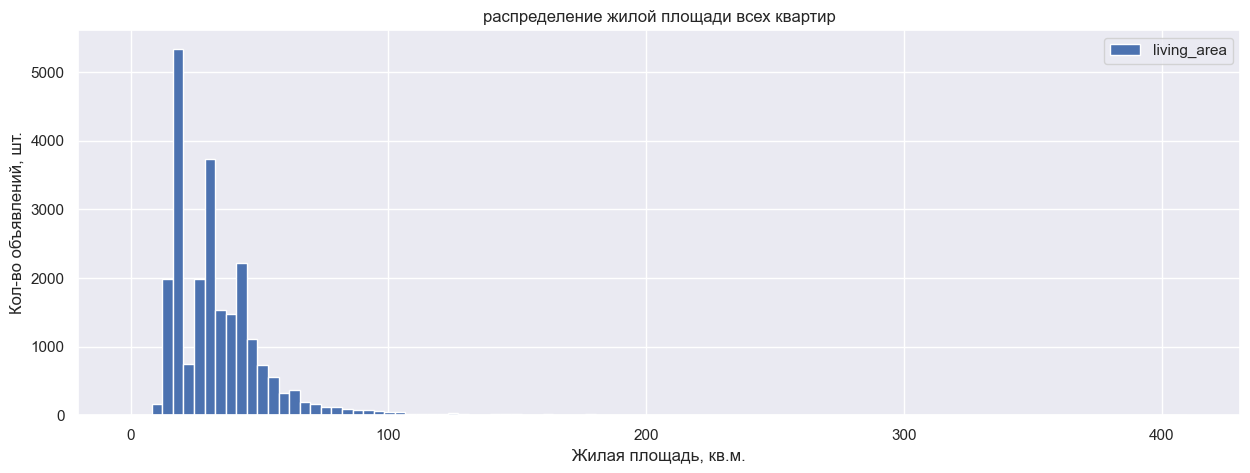

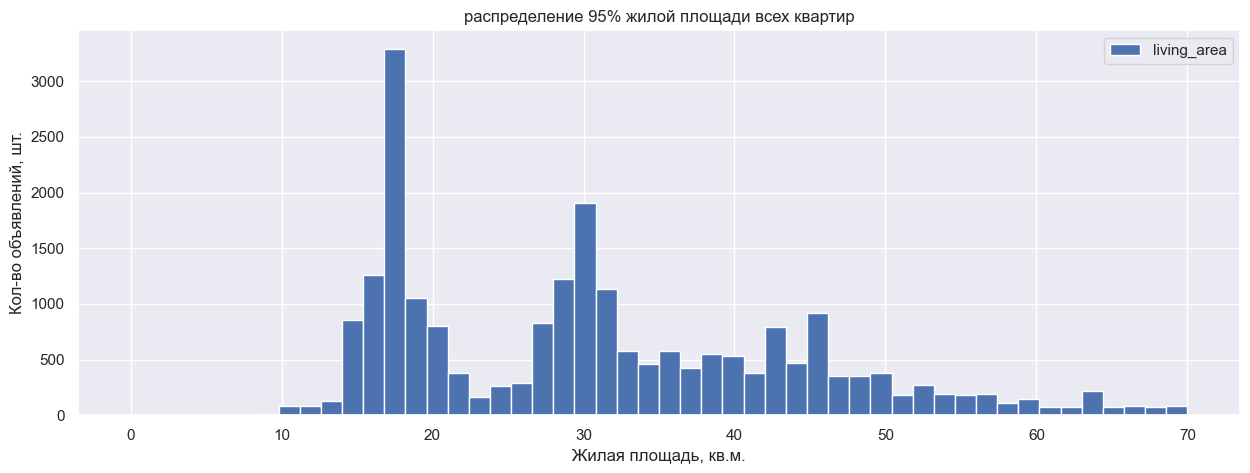

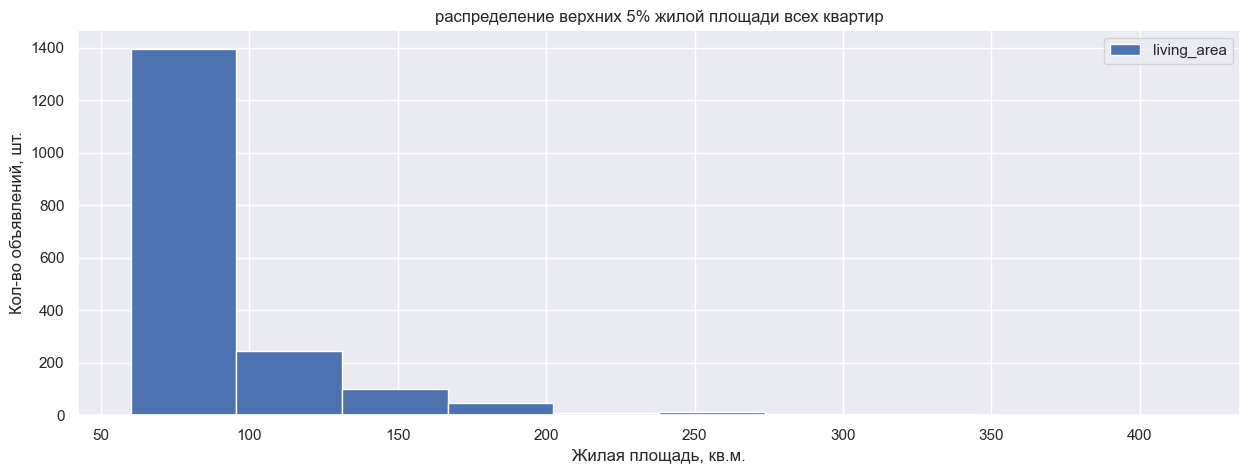

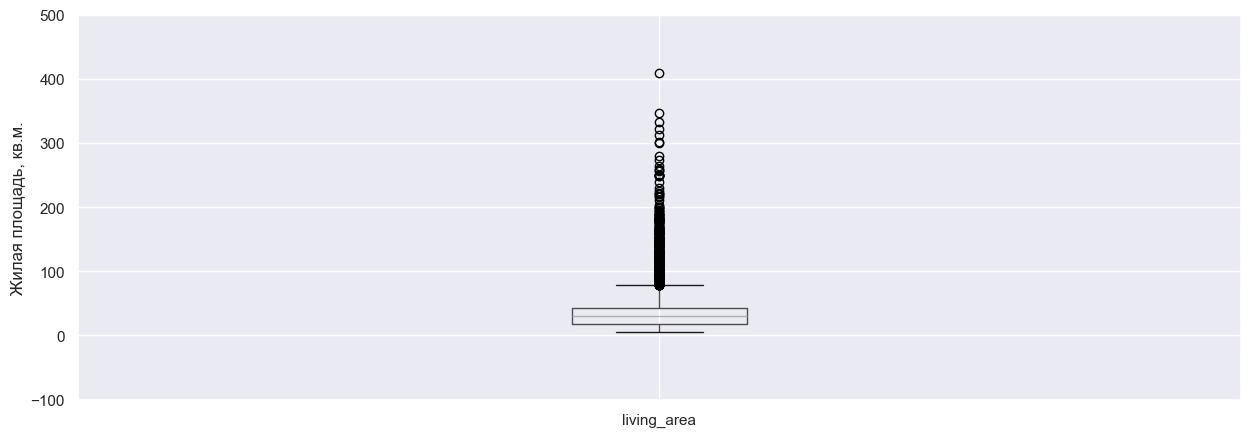

In [46]:
# распределение жилой площади всех квартир
data.plot(kind='hist', y='living_area', grid=True, range=(0,410), bins=100, figsize=(15,5))
plt.title('распределение жилой площади всех квартир')
plt.xlabel('Жилая площадь, кв.м.')
plt.ylabel('Кол-во объявлений, шт.')
plt.show()

# распределение 95% жилой площади квартир квартир
data.plot(kind='hist', y='living_area', grid=True, bins=50, figsize=(15,5), range=(0, 70))
plt.title('распределение 95% жилой площади всех квартир')
plt.xlabel('Жилая площадь, кв.м.')
plt.ylabel('Кол-во объявлений, шт.')
plt.show()

# распределение верхних 5% жилой площади квартир
data.plot(kind='hist', y='living_area', grid=True, figsize=(15,5), range=(60, 416))
plt.title('распределение верхних 5% жилой площади всех квартир')
plt.xlabel('Жилая площадь, кв.м.')
plt.ylabel('Кол-во объявлений, шт.')
plt.show()

# график с усами
data.boxplot(column='living_area', grid=True, figsize=(15,5))
plt.ylim(-100,500)
plt.ylabel('Жилая площадь, кв.м.')
plt.show()

Из анализа ясно, что:
- минимальное значение жилой площади квартиры стало более адекватными
- средняя жилая площадь квартиры равна 34.3 кв.м. и почти равна медиане, которая составляет 30.30 кв.м., значит выбросы не сильно влияют на распределение данных. Ст. ошибка при этом меньше среднего.
- 95% жилой площади всех квартир находится в диапазоне до 68 кв.м.
- по боксплоту видно множество выбросов, которые, однако, не сильно влияют на распределение

### Площадь кухни (kitchen_area)

In [47]:
print(data['kitchen_area'].describe(percentiles=[0.01,0.1,0.25,0.5,0.75,0.9,0.95,0.99]))

count   23558.00
mean       10.84
std         6.49
min         0.00
1%          4.70
10%         6.00
25%         7.10
50%         9.42
75%        12.00
90%        16.50
95%        21.20
99%        37.90
max       123.89
Name: kitchen_area, dtype: float64


Проверим, есть ли значения, где площадь кухни и жилая площадь вместе взятые больше общей площади

In [48]:
data.query('(kitchen_area + living_area) > total_area')

total_images  last_price  total_area first_day_exposition  rooms  \
164               6      800.00       40.30           2018-06-25      2   
184               7     2600.00       30.20           2018-02-14      1   
227              13     2200.00       47.00           2018-01-12      3   
424              14    11500.00       98.00           2016-05-10      3   
545               9     4700.00       23.80           2018-12-28      1   
...             ...         ...         ...                  ...    ...   
22907             9    65000.00      228.00           2016-06-02      4   
23102             0     5800.00       66.00           2017-06-09      5   
23191             3     1900.00       18.90           2016-04-04      1   
23202            13     4919.88       67.92           2018-10-23      2   
23613             4     3950.00       52.00           2018-03-04      3   

       ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
164              2.50             3        30.50      1             0       0   
184              2.65             9        26.10      5             0       0   
227              2.34             5        45.00      1             0       0   
424              2.65             3        88.00      3             0       0   
545              2.50            18        20.00      9             0       0   
...               ...           ...          ...    ...           ...     ...   
22907            2.50             5       200.00      2             0       0   
23102            2.50             5        55.50      1             0       0   
23191            2.50            16        16.00     12             0       0   
23202            2.50             3        63.00      3             0       0   
23613            2.50             5        45.00      2             0       0   

       open_plan  kitchen_area  balcony    locality_name  airports_nearest  \
164            0          9.99        2       Ефимовский               NaN   
184            0          6.20        0  Санкт-Петербург          13952.00   
227            0         11.65        0       Новый Свет               NaN   
424            0         24.28        1  Санкт-Петербург          39363.00   
545            0          5.00        0  Санкт-Петербург           9731.00   
...          ...           ...      ...              ...               ...   
22907          0         56.50        0  Санкт-Петербург          22783.00   
23102          0         16.35        0  Санкт-Петербург          12007.00   
23191          0          4.68        0            Тосно               NaN   
23202          0         13.04        0       Всеволожск               NaN   
23613          0         12.88        0        Парголово          55549.00   

       city_centers_nearest  parks_around3000  parks_nearest  \
164                     NaN               NaN            NaN   
184                15031.00              0.00            NaN   
227                     NaN               NaN            NaN   
424                13270.00              0.00            NaN   
545                11849.00              0.00            NaN   
...                     ...               ...            ...   
22907               1295.00              3.00         619.00   
23102              11933.00              0.00            NaN   
23191                   NaN               NaN            NaN   
23202                   NaN               NaN            NaN   
23613              21223.00              0.00            NaN   

       ponds_around3000  ponds_nearest  days_exposition  cost_per_m2  \
164                 NaN            NaN            81.00     19851.12   
184                1.00         824.00            12.00     86092.72   
227                 NaN            NaN            45.00     46808.51   
424                0.00            NaN            90.00    117346.94   
545                0.00            NaN           108.00    197478.9

Таких значений немного, около 1%, поэтому удалим их

In [49]:
data = data.query('(kitchen_area + living_area) < total_area')

In [50]:
# еще раз посмотрим на описание данных
data['kitchen_area'].describe(percentiles=[0.01,0.1,0.25,0.5,0.75,0.9,0.95,0.99])

count   23211.00
mean       10.80
std         6.45
min         0.00
1%          4.80
10%         6.00
25%         7.10
50%         9.40
75%        12.00
90%        16.35
95%        21.00
99%        37.70
max       123.89
Name: kitchen_area, dtype: float64

Построим необходимые графики

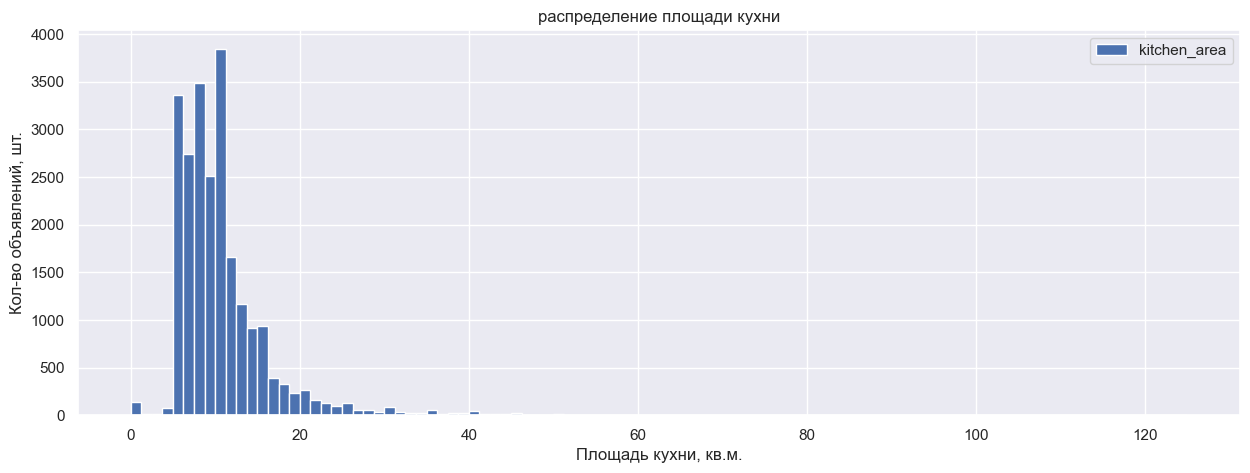

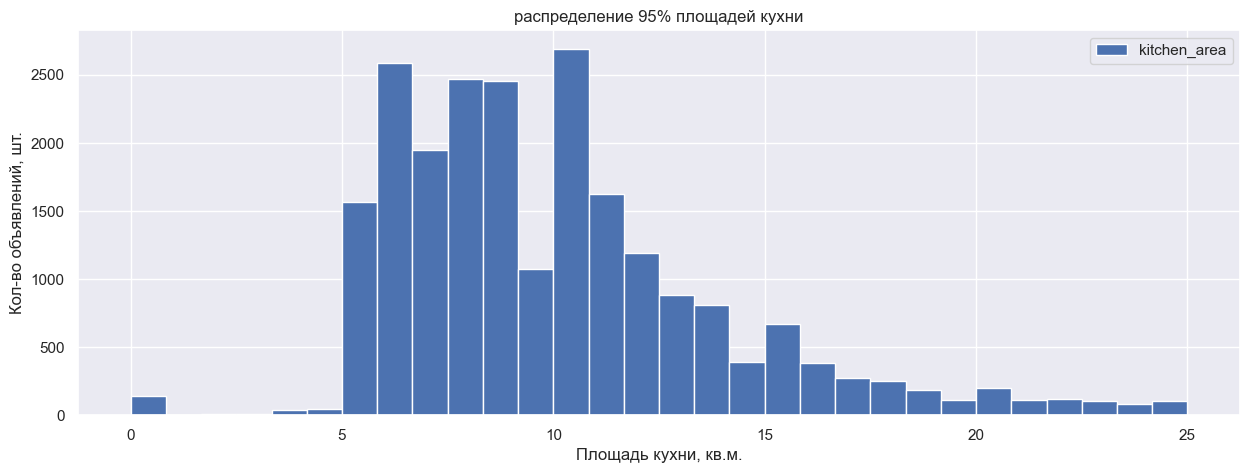

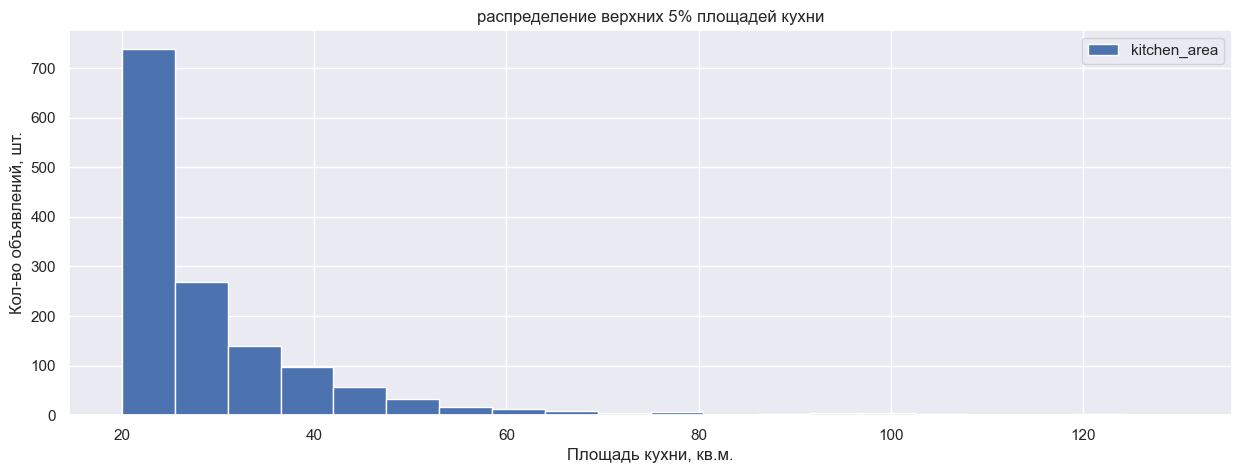

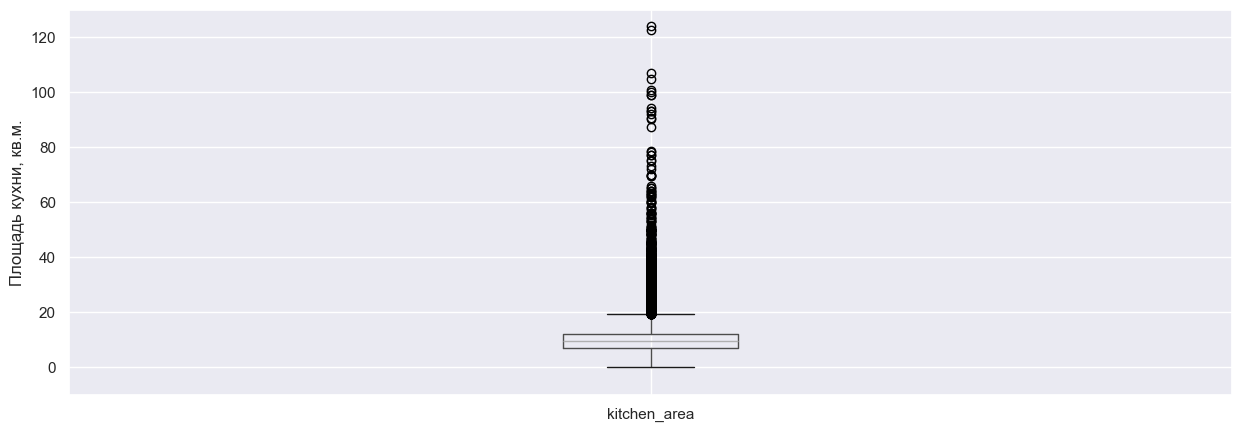

In [51]:
# распределение площади кухни
data.plot(kind='hist', y='kitchen_area', grid=True, range=(0,125), bins=100, figsize=(15,5))
plt.title('распределение площади кухни')
plt.xlabel('Площадь кухни, кв.м.')
plt.ylabel('Кол-во объявлений, шт.')
plt.show()

# распределение 95% площадей кухни
data.plot(kind='hist', y='kitchen_area', grid=True, bins=30, figsize=(15,5), range=(0, 25))
plt.title('распределение 95% площадей кухни')
plt.xlabel('Площадь кухни, кв.м.')
plt.ylabel('Кол-во объявлений, шт.')
plt.show()

# распределение верхних 5% площадей кухни
data.plot(kind='hist', y='kitchen_area', grid=True, bins=20, figsize=(15,5), range=(20, 130))
plt.title('распределение верхних 5% площадей кухни')
plt.xlabel('Площадь кухни, кв.м.')
plt.ylabel('Кол-во объявлений, шт.')
plt.show()

# график с усами
data.boxplot(column='kitchen_area', grid=True, figsize=(15,5))
plt.ylim(-10,130)
plt.ylabel('Площадь кухни, кв.м.')
plt.show()

Из анализа ясно, что:
- среднее значение плошади кухни составляет 10.8 кв.м., что почти равно медиане, составляющей 9.4 кв.м. При этом ст. ошибка меньше среднего.
- 95% кухонь имеют площадь в диапазоне до 21 кв.м.
- по боксплоту видно, что выбросов много, однако они не сильно влияют на распределение
- все значения в столбце выглядят адекватными
- в столбце присутствуют нули, поскольку значения площади кухни в студиях установлено равным 0

Пики на графике 95% распределения квартир по площади кухни можно объяснить стандартизацией планировок при строительстве, ввиду чего большое количество квартир имеют одинаковые площади кухонь

### Число комнат (rooms)

In [52]:
data['rooms'].describe(percentiles=[0.01,0.1,0.25,0.5,0.75,0.9,0.95,0.99])

count   23211.00
mean        2.07
std         1.07
min         0.00
1%          1.00
10%         1.00
25%         1.00
50%         2.00
75%         3.00
90%         3.00
95%         4.00
99%         5.00
max        19.00
Name: rooms, dtype: float64

Посмотрим, чем обусловлено наличие большого количества комнат

In [53]:
data.sort_values(by='rooms').tail(10)

total_images  last_price  total_area first_day_exposition  rooms  \
4149              6    23000.00      272.60           2018-01-11     10   
18891            11    40000.00      290.00           2016-06-21     10   
18119             4    15500.00      216.10           2016-07-04     10   
9688              8    33000.00      194.10           2017-02-07     11   
648               3    17500.00      183.70           2018-07-01     11   
866               5    25000.00      363.00           2017-12-23     14   
20829             6    28659.00      245.40           2016-03-31     14   
5358             20    65000.00      590.00           2019-02-14     15   
18848             6    28500.00      270.00           2015-03-02     16   
14498             6    32250.00      374.60           2018-06-09     19   

       ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
4149             3.14             7       145.90      7             0       0   
18891            3.50             6       189.40      6             0       0   
18119            3.15             5       161.40      2             0       0   
9688             3.43             5       129.00      2             0       0   
648              3.40             7       138.80      7             0       0   
866              3.16             5       222.00      4             0       0   
20829            2.50             4       168.30      2             0       0   
5358             3.50             6       409.00      3             0       0   
18848            3.00             4       180.00      4             0       0   
14498            2.50             5       264.50      2             0       0   

       open_plan  kitchen_area  balcony    locality_name  airports_nearest  \
4149           0         18.80        1  Санкт-Петербург          10726.00   
18891          0         30.00        1  Санкт-Петербург          26229.00   
18119          0         19.80        0  Санкт-Петербург          24353.00   
9688           0         11.90        0  Санкт-Петербург          21469.00   
648            0         13.30        0  Санкт-Петербург          23606.00   
866            0         16.60        0  Санкт-Петербург          38076.00   
20829          0         25.90        0  Санкт-Петербург          21104.00   
5358           0        100.00        0  Санкт-Петербург          24447.00   
18848          0         13.00        1  Санкт-Петербург          23575.00   
14498          0         27.60        0  Санкт-Петербург          19497.00   

       city_centers_nearest  parks_around3000  parks_nearest  \
4149               12169.00              1.00         191.00   
18891               4932.00              3.00         316.00   
18119               4921.00              1.00         368.00   
9688                1015.00              1.00         686.00   
648                 3148.00              0.00            NaN   
866                 7950.00              0.00            NaN   
20829               2054.00              3.00         541.00   
5358                4666.00              1.00         767.00   
18848               4142.00              1.00         516.00   
14498               3574.00              0.00            NaN   

       ponds_around3000  ponds_nearest  days_exposition  cost_per_m2  \
4149               1.00         531.00              NaN     84372.71   
18891              1.00         227.00            77.00    137931.03   
18119              0.00            NaN            11.00     71726.05   
9688               2.00          66.00           813.00    170015.46   
648                0.00            NaN              NaN     95264.02   
866                2.00         435.00           418.00     68870.52   
20829              2.00         118.00            95.00    116784.84   
5358               0.00            NaN            14.00    110169.49   
18848              0.00            NaN          1365.00    105555.56   
14498

Такое большое количество комнат вполне обосновано общей площадью квартир, к тому же, вспоминаем, что у профессора Преображенского в произведении "Собачье сердце" было 7 комнат

Сравним количество квартир, где значение комнат равно 0, с количеством студий

In [54]:
print(data.query('rooms == 0')['rooms'].count())
data.query('studio == 1')['studio'].count()

192


144

Значения в масштабах датасета практически равны, значит количество квартир с нулевым значением комнат объясняется тем, что они являются студиями

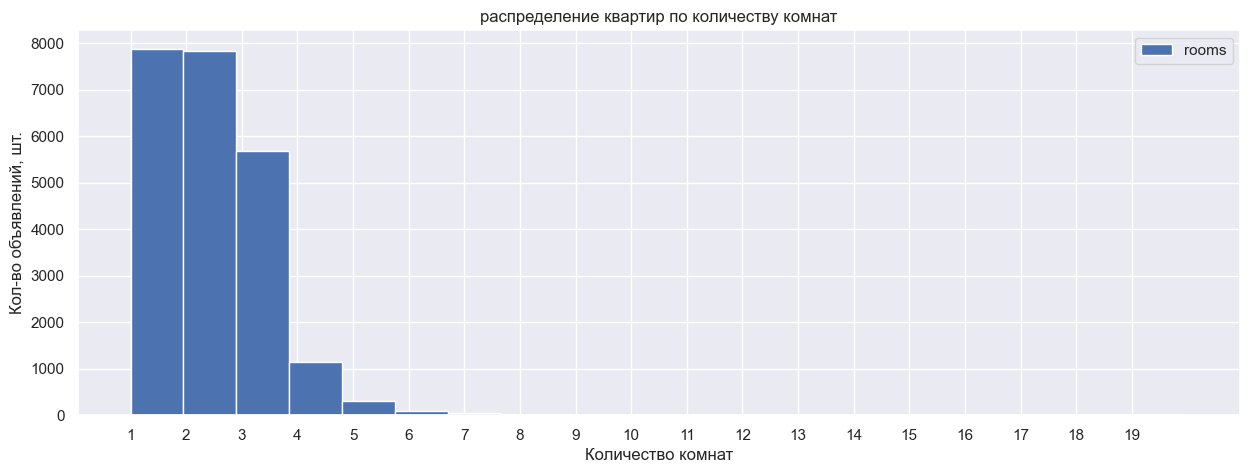

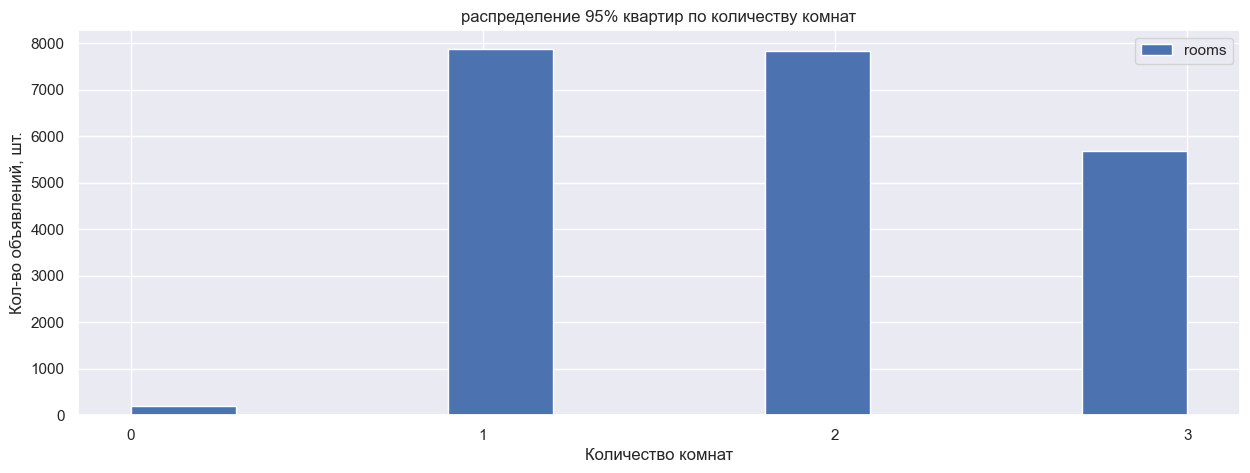

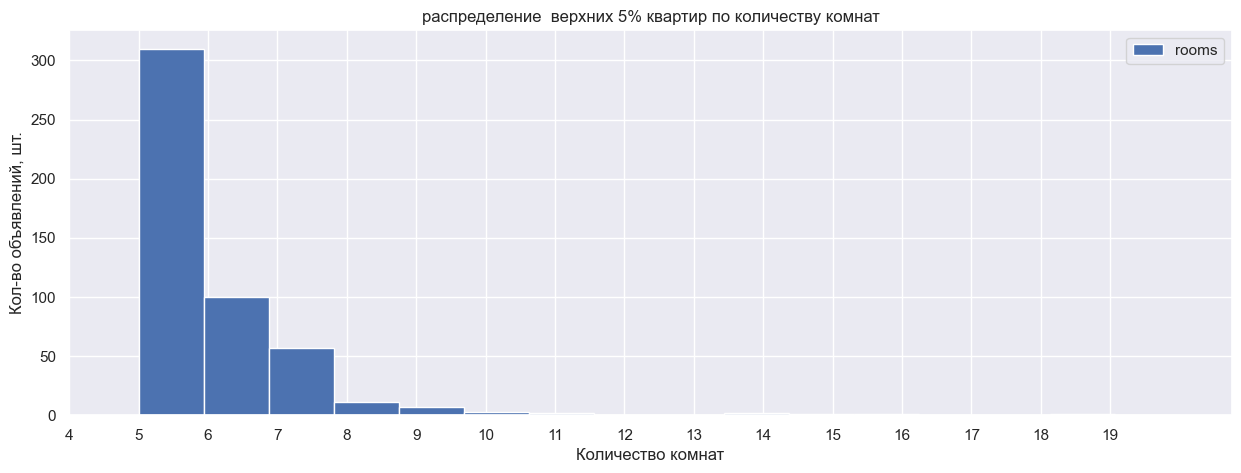

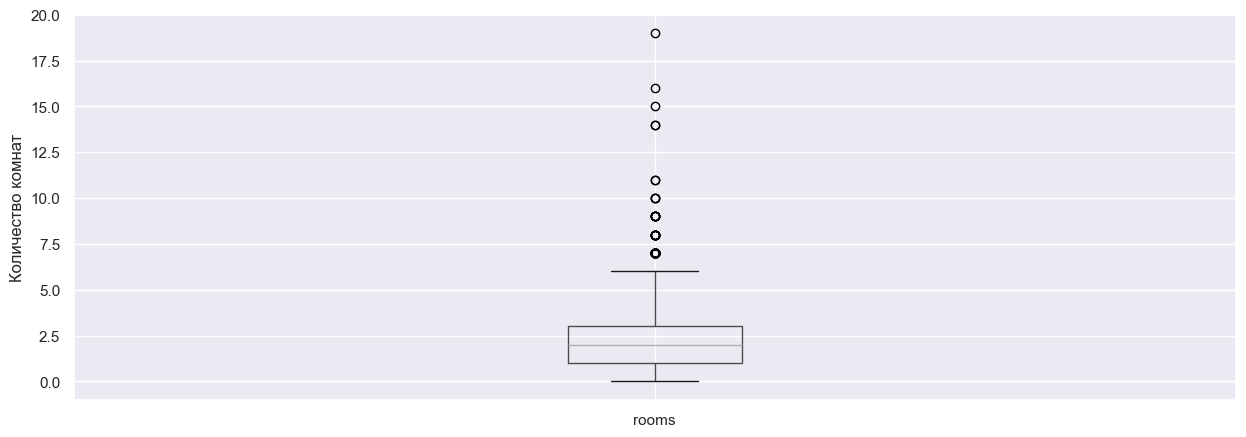

In [55]:
# построим необходимые графики
# распределение количества комнат
data.plot(kind='hist', y='rooms', grid=True, range=(1,20), bins=20, figsize=(15,5), xticks=range(1,20))
plt.title('распределение квартир по количеству комнат')
plt.xlabel('Количество комнат')
plt.ylabel('Кол-во объявлений, шт.')
plt.show()

# распределение 95% количества комнат
data.plot(kind='hist', y='rooms', grid=True, figsize=(15,5), range=(0, 3), xticks=range(0,4))
plt.title('распределение 95% квартир по количеству комнат')
plt.xlabel('Количество комнат')
plt.ylabel('Кол-во объявлений, шт.')
plt.show()

# распределение верхних 5% количества комнат
data.plot(kind='hist', y='rooms', grid=True, bins=16, figsize=(15,5), range=(5, 20), xticks=range(4,20))
plt.title('распределение  верхних 5% квартир по количеству комнат')
plt.xlabel('Количество комнат')
plt.ylabel('Кол-во объявлений, шт.')
plt.show()

# график с усами
data.boxplot(column='rooms', grid=True, figsize=(15,5))
plt.ylim(-1,20)
plt.ylabel('Количество комнат')
plt.show()

**Вывод:**  
- среднее значение количества комнат примерно равно 2, а также примерно равно медиане, составляющей 2 комнаты. Ст. ошибка в 2 раза меньше среднего
- 95% всех квартир содержит количества комнат в диапазоне до 4
- по бокспллоту количество выбросов невелико, и они не влияют на распределение данных, медиана не стремится к хвосту выбросов

### Высота потолков (ceiling_height)

In [56]:
data['ceiling_height'].describe(percentiles=[0.01,0.1,0.25,0.5,0.75,0.9,0.95,0.99])

count   23211.00
mean        2.66
std         0.74
min         1.00
1%          2.50
10%         2.50
25%         2.50
50%         2.50
75%         2.70
90%         3.00
95%         3.13
99%         3.60
max        32.00
Name: ceiling_height, dtype: float64

Сомневаемся в возможности существования потолков меньше 2 и больше 10 метров (предположим, что в продаже есть двух-или трёхэтажные квартиры)

Посмотрим на квартиры с наивысшими потолками

In [57]:
data.sort_values(by='ceiling_height').tail(10)

total_images  last_price  total_area first_day_exposition  rooms  \
5669              4     4400.00       50.00           2017-08-08      2   
4876              7     3000.00       25.00           2017-09-27      0   
20478            11     8000.00       45.00           2017-07-18      1   
22938            14     4000.00       98.00           2018-03-15      4   
5246              0     2500.00       54.00           2017-10-13      2   
5807             17     8150.00       80.00           2019-01-09      2   
17857             1     3900.00       56.00           2017-12-22      3   
10773             8     3800.00       58.00           2017-10-13      2   
22336            19     9999.00       92.40           2019-04-05      2   
3148             14     2900.00       75.00           2018-11-12      3   

       ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
5669            26.00             9        21.30      3             0       0   
4876            27.00            25        17.00     17             0       0   
20478           27.00             4        22.00      2             0       0   
22938           27.00             2        73.00      2             1       0   
5246            27.00             5        30.00      3             0       0   
5807            27.00            36        41.00     13             0       0   
17857           27.00             5        33.00      4             0       0   
10773           27.00            10        30.10      3             0       0   
22336           32.00             6        55.50      5             0       0   
3148            32.00             3        53.00      2             0       0   

       open_plan  kitchen_area  balcony    locality_name  airports_nearest  \
5669           0          7.00        2  Санкт-Петербург          28981.00   
4876           1          6.19        2           Мурино               NaN   
20478          0         10.00        1  Санкт-Петербург          18975.00   
22938          0          9.00        1           Нижняя               NaN   
5246           0          9.00        2             Мины               NaN   
5807           0         12.00        5  Санкт-Петербург          18732.00   
17857          0         13.88        0  Санкт-Петербург          41030.00   
10773          0          8.10        2           Мурино               NaN   
22336          0         16.50        4  Санкт-Петербург          18838.00   
3148           0          8.00        0           Волхов               NaN   

       city_centers_nearest  parks_around3000  parks_nearest  \
5669               10912.00              1.00         305.00   
4876                    NaN               NaN            NaN   
20478               3246.00              0.00            NaN   
22938                   NaN               NaN            NaN   
5246                    NaN               NaN            NaN   
5807               20444.00              0.00            NaN   
17857              15543.00              0.00            NaN   
10773                   NaN               NaN            NaN   
22336               3506.00              0.00            NaN   
3148                    NaN               NaN            NaN   

       ponds_around3000  ponds_nearest  days_exposition  cost_per_m2  \
5669               0.00            NaN           267.00     88000.00   
4876                NaN            NaN            28.00    120000.00   
20478              3.00         449.00           429.00    177777.78   
22938               NaN            NaN            27.00     40816.33   
5246                NaN            NaN           540.00     46296.30   
5807               3.00          80.00            38.00    101875.00   
17857              0.00            NaN            73.00     69642.86   
10773               NaN            NaN            71.00     65517.24   
22336              3.00         511.00              NaN    108214.29   
3148 

Заменим выброс с высотой потолка в 100 м. на медиану

In [58]:
for value in data['ceiling_height']:
    if value == 100:
         print(data['ceiling_height'].median())

In [59]:
# проверим, убралось ли оно
data.query('ceiling_height == 100')

Empty DataFrame
Columns: [total_images, last_price, total_area, first_day_exposition, rooms, ceiling_height, floors_total, living_area, floor, is_apartment, studio, open_plan, kitchen_area, balcony, locality_name, airports_nearest, city_centers_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition, cost_per_m2, publish_dayofweek, publish_month, publish_year, floor_category, city_centers_nearest_km]
Index: []

Посмотрим на квартиры с высотой потолков менее 2.2 м. 

In [60]:
data.query('ceiling_height < 2.2')

total_images  last_price  total_area first_day_exposition  rooms  \
552              11     2999.00       33.50           2017-03-30      1   
2572              4     2400.00       62.00           2018-12-27      3   
4212              1     2120.00       35.43           2017-12-18      1   
5712              5     1500.00       42.80           2017-08-14      2   
5850              9     1650.00       35.50           2018-05-29      1   
11352             4     3300.00       36.00           2017-06-18      1   
16446             6    12300.00       88.30           2019-03-12      3   
16884             0     1500.00       33.00           2018-10-03      1   
16934             5     4100.00       40.00           2017-10-17      1   
19098             7     2700.00       56.00           2018-02-04      3   
20520             9     3600.00       38.00           2018-07-05      1   
22590            16     6000.00       55.00           2018-10-31      2   
22960            17     2300.00       53.60           2018-10-18      2   

       ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
552              2.00            15        17.50      6             0       0   
2572             2.00             5        40.00      4             0       0   
4212             2.00            18        16.60      9             0       0   
5712             1.20             2        27.50      1             0       0   
5850             2.00             5        17.60      5             0       0   
11352            2.00            17        15.20     12             0       0   
16446            2.00             5        63.90      2             0       0   
16884            2.00             5        20.00      5             0       0   
16934            1.75            37        17.40      5             0       0   
19098            2.00             5        46.00      1             0       0   
20520            2.00            12        15.00      9             0       0   
22590            1.00            12        32.40      7             0       0   
22960            2.00             2        19.00      1             0       0   

       open_plan  kitchen_area  balcony    locality_name  airports_nearest  \
552            0          6.50        0  Санкт-Петербург          33972.00   
2572           0          6.00        1             Луга               NaN   
4212           0          8.80        2            Тосно               NaN   
5712           0          5.20        0              Мга               NaN   
5850           0          8.80        0             Луга               NaN   
11352          0         10.10        0     Металлострой          25268.00   
16446          0         12.00        0  Санкт-Петербург          38415.00   
16884          0          6.00        0           Выборг               NaN   
16934          0          8.34        0  Санкт-Петербург          18732.00   
19098          0          6.00        0           Выборг               NaN   
20520          0         11.80        1          Кудрово               NaN   
22590          0         10.00        0  Санкт-Петербург          33053.00   
22960          0         10.00        0       Всеволожск               NaN   

       city_centers_nearest  parks_around3000  parks_nearest  \
552                11746.00              1.00         520.00   
2572                    NaN               NaN            NaN   
4212                    NaN               NaN            NaN   
5712                    NaN               NaN            NaN   
5850                    NaN               NaN            NaN   
11352              26980.00              0.00            NaN   
16446               7675.00              1.00         568.00   
16884                   NaN               NaN            NaN   
16934              20444.00              0.00            NaN   
19098                   NaN               NaN            NaN   
20520                   

Заменим значения выше на медиану

In [61]:
def ceiling(height):
    if height < 2.2:
        return data['ceiling_height'].median()
    else:
        return height
data['ceiling_height'] = data['ceiling_height'].apply(ceiling)

In [62]:
# проверим убрались ли они
data.query('ceiling_height < 2.2')

Empty DataFrame
Columns: [total_images, last_price, total_area, first_day_exposition, rooms, ceiling_height, floors_total, living_area, floor, is_apartment, studio, open_plan, kitchen_area, balcony, locality_name, airports_nearest, city_centers_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition, cost_per_m2, publish_dayofweek, publish_month, publish_year, floor_category, city_centers_nearest_km]
Index: []

Поделим значения с ошибочно выставленной высотой (от 20 до 40) на 10

In [63]:
data.loc[(data['ceiling_height'] >= 20) & (data['ceiling_height'] <= 40), 'ceiling_height'] = data['ceiling_height'] / 10

Проверим значение потолков больше 6 м.

In [64]:
data.query('ceiling_height > 6')

total_images  last_price  total_area first_day_exposition  rooms  \
3474              3     1400.00       30.00           2018-03-16      1   
5863             20     5650.00       45.00           2018-08-15      1   
15061            19     5600.00       56.40           2018-05-11      2   
15743            14     5600.00       67.00           2016-11-11      3   
17442             0     5350.00       54.00           2015-06-16      2   
22309            20     5300.00       45.00           2017-09-30      1   

       ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
3474             8.00             5        15.30      2             0       0   
5863             8.30            16        19.30     14             0       0   
15061           14.00            14        32.40      5             0       0   
15743            8.00            16        41.00      1             0       0   
17442            8.00             5        29.00      2             0       0   
22309           10.30            16        15.50     15             0       0   

       open_plan  kitchen_area  balcony    locality_name  airports_nearest  \
3474           0          7.30        0            Нурма               NaN   
5863           0          8.30        1  Санкт-Петербург          13069.00   
15061          0          9.10        2  Санкт-Петербург          14814.00   
15743          0          8.00        0  Санкт-Петербург          32691.00   
17442          0         13.38        1     Красное Село          24638.00   
22309          0         11.15        0  Санкт-Петербург          36353.00   

       city_centers_nearest  parks_around3000  parks_nearest  \
3474                    NaN               NaN            NaN   
5863               10763.00              0.00            NaN   
15061              13610.00              0.00            NaN   
15743              11035.00              1.00         723.00   
17442              28062.00              0.00            NaN   
22309              11936.00              2.00         440.00   

       ponds_around3000  ponds_nearest  days_exposition  cost_per_m2  \
3474                NaN            NaN           125.00     46666.67   
5863               1.00         613.00            14.00    125555.56   
15061              0.00            NaN           315.00     99290.78   
15743              0.00            NaN           474.00     83582.09   
17442              0.00            NaN           469.00     99074.07   
22309              2.00         450.00           136.00    117777.78   

      publish_dayofweek publish_month publish_year floor_category  \
3474                  4             3         2018         другой   
5863                  2             8         2018         другой   
15061                 4             5         2018         другой   
15743                 4            11         2016         первый   
17442                 1             6         2015         другой   
22309                 5             9         2017         другой   

       city_centers_nearest_km  
3474                       NaN  
5863                     11.00  
15061                    14.00  
15743                    11.00  
17442                    28.00  
22309                    12.00

Не совсем понятно, чем их заменить, и, поскольку значений немного, удалим их

In [65]:
data = data.query('ceiling_height < 6')

In [66]:
data['ceiling_height'].describe(percentiles=[0.01,0.1,0.25,0.5,0.75,0.9,0.95,0.99])

count   23204.00
mean        2.64
std         0.24
min         2.00
1%          2.50
10%         2.50
25%         2.50
50%         2.50
75%         2.70
90%         3.00
95%         3.12
99%         3.56
max         5.80
Name: ceiling_height, dtype: float64

Построим необходимые графики

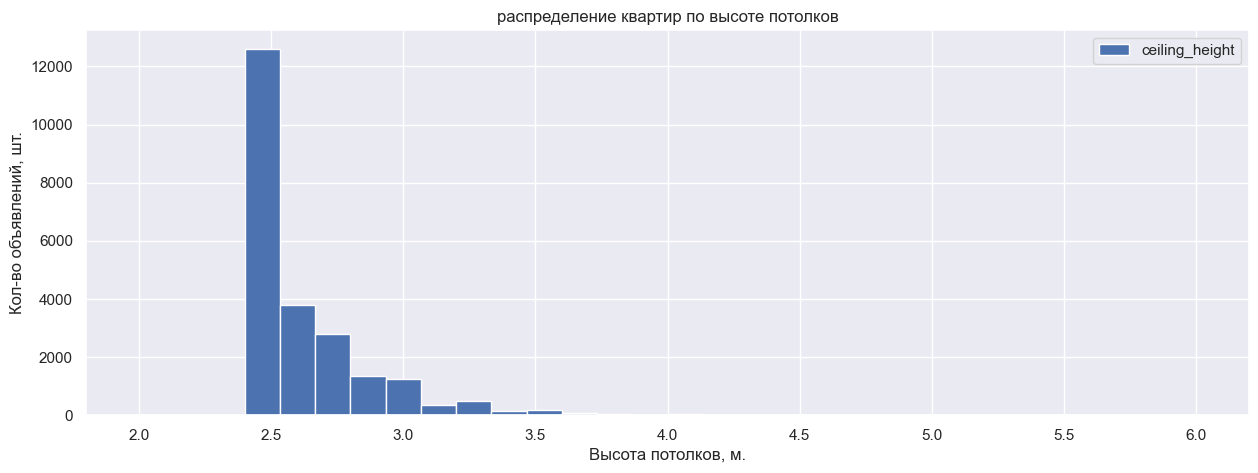

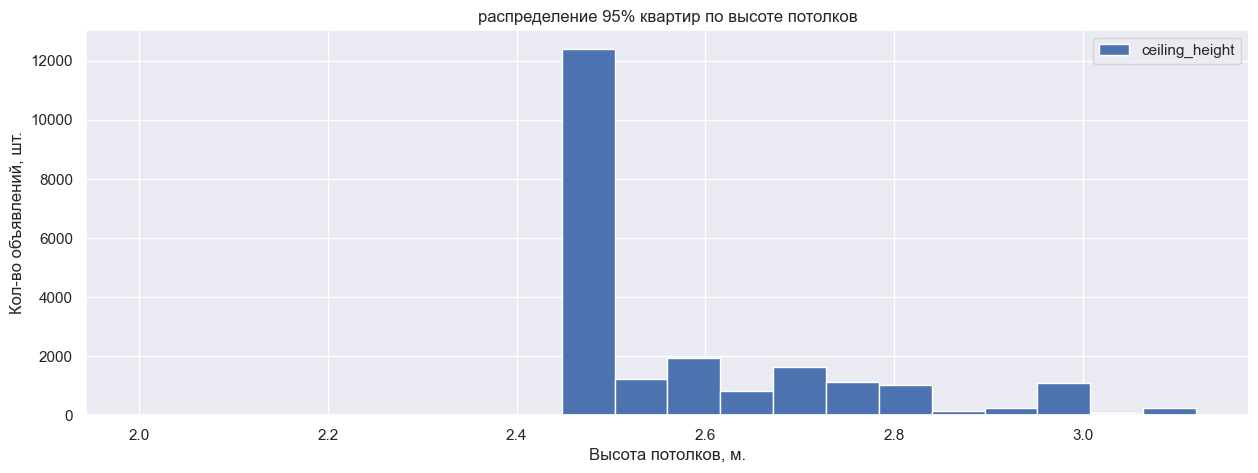

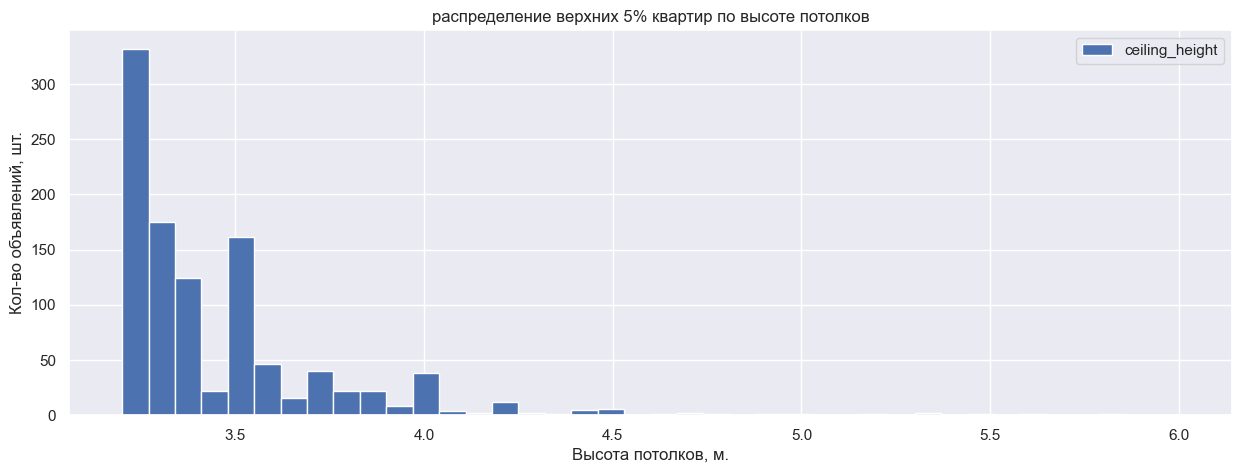

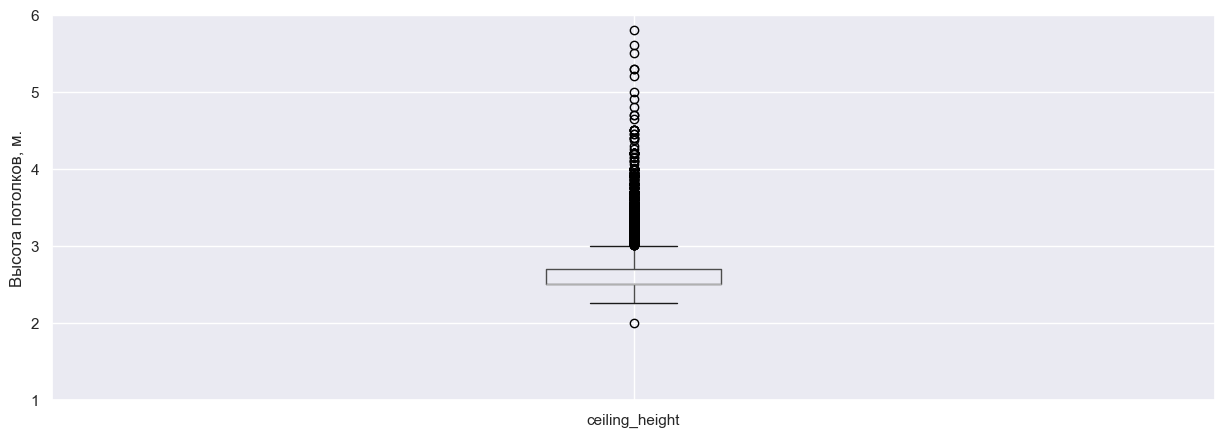

In [67]:
# распределение квартир по высоте потолков
data.plot(kind='hist', y='ceiling_height', grid=True, range=(2,6), bins=30, figsize=(15,5))
plt.title('распределение квартир по высоте потолков')
plt.xlabel('Высота потолков, м.')
plt.ylabel('Кол-во объявлений, шт.')
plt.show()

# распределение 95% квартир по высоте потолков
data.plot(kind='hist', y='ceiling_height', grid=True, bins=20, figsize=(15,5), range=(2, 3.12))
plt.title('распределение 95% квартир по высоте потолков')
plt.xlabel('Высота потолков, м.')
plt.ylabel('Кол-во объявлений, шт.')
plt.show()

# распределение верхних 5% квартир по высоте потолков
data.plot(kind='hist', y='ceiling_height', grid=True, bins=40, figsize=(15,5), range=(3.2, 6))
plt.title('распределение верхних 5% квартир по высоте потолков')
plt.xlabel('Высота потолков, м.')
plt.ylabel('Кол-во объявлений, шт.')
plt.show()

# график с усами
data.boxplot(column='ceiling_height', grid=True, figsize=(15,5))
plt.ylim(1,6)
plt.ylabel('Высота потолков, м.')
plt.show()

**Вывод:**  
- среднее значение высоты потолков примерно равно 2.6, а также примерно равно медиане, составляющей 2.5 м. Ст. ошибка в 10 раз меньше среднего
- данные выглядят очень однородными
- 95% всех квартир содержит высоту потолков в диапазоне до 3.1 метров
- по бокспллоту выбросов много, и они не влияют на распределение данных, медиана не стремится к хвосту выбросов
- аномальные значения заменены или удалены

### Категория этажности (floor_category)

In [68]:
data['floor_category'].value_counts()

floor_category
другой       17107
последний     3263
первый        2834
Name: count, dtype: int64

In [69]:
data['floor_category'].describe()

count      23204
unique         3
top       другой
freq       17107
Name: floor_category, dtype: object

##### floors_total

In [70]:
data['floors_total'].describe(percentiles=[0.01,0.1,0.25,0.5,0.75,0.9,0.95,0.99])

count   23204.00
mean       10.69
std         6.59
min         1.00
1%          2.00
10%         5.00
25%         5.00
50%         9.00
75%        16.00
90%        22.00
95%        25.00
99%        26.00
max        60.00
Name: floors_total, dtype: float64

In [71]:
data.sort_values(by='floors_total').head(10)

total_images  last_price  total_area first_day_exposition  rooms  \
8388             20     3550.00       48.20           2019-03-30      3   
17744             8     2300.00       50.90           2017-08-09      2   
18900             2     1800.00       65.00           2018-02-02      3   
15543            12     3500.00       54.00           2017-12-01      2   
22550             2     5800.00      115.00           2017-09-12      2   
19590            20     6150.00       95.00           2018-07-29      2   
21603            12     1900.00       40.00           2019-01-29      2   
10817             6      790.00       50.60           2017-11-29      3   
22841             9      980.00       54.00           2017-12-09      2   
9752             16      850.00       62.00           2018-11-10      2   

       ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
8388             2.65             1        33.90      1             0       0   
17744            2.50             1        30.00      1             0       0   
18900            2.45             1        45.00      1             0       0   
15543            2.90             1        24.40      1             0       0   
22550            2.50             1        40.00      1             0       0   
19590            2.50             1        65.00      1             0       0   
21603            2.90             1        19.20      1             0       0   
10817            2.50             1        32.00      1             0       0   
22841            2.50             1        30.50      1             0       0   
9752             2.50             1        31.00      1             0       0   

       open_plan  kitchen_area  balcony  locality_name  airports_nearest  \
8388           0          9.10        0     Сестрорецк          50046.00   
17744          0          7.00        0          Суйда               NaN   
18900          0         16.11        0     Свирьстрой               NaN   
15543          0          7.30        0  Большая Ижора               NaN   
22550          0         14.00        0     Сестрорецк          54331.00   
19590          0         21.00        0         Рощино               NaN   
21603          0          6.50        0        Сосново               NaN   
10817          0         12.54        0     Ефимовский               NaN   
22841          0         13.38        0         Пчевжа               NaN   
9752           0         11.00        0          Сижно               NaN   

       city_centers_nearest  parks_around3000  parks_nearest  \
8388               31144.00              0.00            NaN   
17744                   NaN               NaN            NaN   
18900                   NaN               NaN            NaN   
15543                   NaN               NaN            NaN   
22550              35394.00              0.00            NaN   
19590                   NaN               NaN            NaN   
21603                   NaN               NaN            NaN   
10817                   NaN               NaN            NaN   
22841                   NaN               NaN            NaN   
9752                    NaN               NaN            NaN   

       ponds_around3000  ponds_nearest  days_exposition  cost_per_m2  \
8388               0.00            NaN              NaN     73651.45   
17744               NaN            NaN           454.00     45186.64   
18900               NaN            NaN            45.00     27692.31   
15543               NaN            NaN           202.00     64814.81   
22550              0.00            NaN           124.00     50434.78   
19590               NaN            NaN            23.00     64736.84   
21603               NaN            NaN              NaN     47500.00   
10817               NaN            NaN              NaN     15612.65   
22841               NaN            NaN            45.00     18148.15   
9752                NaN    

Посмотрим на самые высотные здания

In [72]:
data.sort_values(by='floors_total').tail(10)

total_images  last_price  total_area first_day_exposition  rooms  \
14347            14     8595.00       69.70           2018-09-26      2   
1917             13    10150.00       74.00           2017-11-17      2   
12960            20     6140.00       54.00           2018-10-09      2   
13975            19     6990.00       65.00           2018-10-06      2   
11079            16     9200.00       75.00           2019-02-22      2   
397              15     5990.00       54.00           2018-03-22      2   
5807             17     8150.00       80.00           2019-01-09      2   
16934             5     4100.00       40.00           2017-10-17      1   
16731             9     3978.00       40.00           2018-09-24      1   
2253             12     3800.00       45.50           2018-06-28      2   

       ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
14347            2.50            35        27.40     26             0       0   
1917             2.80            35        34.40     30             0       0   
12960            2.70            35        26.60     13             0       0   
13975            2.50            35        32.10     23             0       0   
11079            2.70            36        40.00     29             0       0   
397              2.50            36        21.40     28             0       0   
5807             2.70            36        41.00     13             0       0   
16934            2.50            37        17.40      5             0       0   
16731            2.65            52        10.50     18             0       0   
2253             2.88            60        27.40      4             0       0   

       open_plan  kitchen_area  balcony    locality_name  airports_nearest  \
14347          0         23.30        0  Санкт-Петербург          18732.00   
1917           0         13.00        0  Санкт-Петербург          18732.00   
12960          0         19.10        2  Санкт-Петербург          18732.00   
13975          0          8.90        0  Санкт-Петербург          18732.00   
11079          0         12.00        2  Санкт-Петербург          18732.00   
397            0         18.70        1  Санкт-Петербург          18732.00   
5807           0         12.00        5  Санкт-Петербург          18732.00   
16934          0          8.34        0  Санкт-Петербург          18732.00   
16731          0         14.00        0  Санкт-Петербург          20728.00   
2253           0          7.40        0        Кронштадт          67763.00   

       city_centers_nearest  parks_around3000  parks_nearest  \
14347              20444.00              0.00            NaN   
1917               20444.00              0.00            NaN   
12960              20444.00              0.00            NaN   
13975              20444.00              0.00            NaN   
11079              20444.00              0.00            NaN   
397                20444.00              0.00            NaN   
5807               20444.00              0.00            NaN   
16934              20444.00              0.00            NaN   
16731              12978.00              1.00         793.00   
2253               49488.00              2.00         342.00   

       ponds_around3000  ponds_nearest  days_exposition  cost_per_m2  \
14347              3.00          80.00              NaN    123314.20   
1917               3.00          80.00              NaN    137162.16   
12960              3.00          80.00           155.00    113703.70   
13975              3.00          80.00            89.00    107538.46   
11079              3.00          80.00              NaN    122666.67   
397                3.00          80.00            11.00    110925.93   
5807               3.00          80.00            38.00    101875.00   
16934              3.00          80.00            71.00    102500.00   
16731              0.00            NaN            45.00     99450.00   
2253 

В Кронштадте нет таких высоток, поэтому, сопоставив со значением в столбце floor приходим к выводу, что здесь закралась ошибка и вместо 60 должно быть 6 этажей

In [73]:
data.loc[data['floors_total'] == 60, 'floors_total'] = 6

In [74]:
data.sort_values(by='floors_total').tail(10)

total_images  last_price  total_area first_day_exposition  rooms  \
1917             13    10150.00       74.00           2017-11-17      2   
21599            12     6200.00       51.00           2017-08-27      2   
9579              9     3450.00       24.80           2019-02-01      0   
7236             10     4599.00       42.00           2019-01-10      1   
21809            20    10600.00       77.00           2019-04-16      2   
397              15     5990.00       54.00           2018-03-22      2   
5807             17     8150.00       80.00           2019-01-09      2   
11079            16     9200.00       75.00           2019-02-22      2   
16934             5     4100.00       40.00           2017-10-17      1   
16731             9     3978.00       40.00           2018-09-24      1   

       ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
1917             2.80            35        34.40     30             0       0   
21599            2.50            35        27.00     13             0       0   
9579             2.68            35        16.00     17             0       1   
7236             2.50            35        15.00     12             0       0   
21809            2.50            35        39.00     11             0       0   
397              2.50            36        21.40     28             0       0   
5807             2.70            36        41.00     13             0       0   
11079            2.70            36        40.00     29             0       0   
16934            2.50            37        17.40      5             0       0   
16731            2.65            52        10.50     18             0       0   

       open_plan  kitchen_area  balcony    locality_name  airports_nearest  \
1917           0         13.00        0  Санкт-Петербург          18732.00   
21599          0         19.00        0  Санкт-Петербург          18732.00   
9579           0          0.00        2  Санкт-Петербург          18732.00   
7236           0         11.00        2  Санкт-Петербург          18732.00   
21809          0         14.00        2  Санкт-Петербург          18732.00   
397            0         18.70        1  Санкт-Петербург          18732.00   
5807           0         12.00        5  Санкт-Петербург          18732.00   
11079          0         12.00        2  Санкт-Петербург          18732.00   
16934          0          8.34        0  Санкт-Петербург          18732.00   
16731          0         14.00        0  Санкт-Петербург          20728.00   

       city_centers_nearest  parks_around3000  parks_nearest  \
1917               20444.00              0.00            NaN   
21599              20444.00              0.00            NaN   
9579               20444.00              0.00            NaN   
7236               20444.00              0.00            NaN   
21809              20444.00              0.00            NaN   
397                20444.00              0.00            NaN   
5807               20444.00              0.00            NaN   
11079              20444.00              0.00            NaN   
16934              20444.00              0.00            NaN   
16731              12978.00              1.00         793.00   

       ponds_around3000  ponds_nearest  days_exposition  cost_per_m2  \
1917               3.00          80.00              NaN    137162.16   
21599              3.00          80.00              NaN    121568.63   
9579               3.00          80.00            45.00    139112.90   
7236               3.00          80.00            72.00    109500.00   
21809              3.00          80.00              NaN    137662.34   
397                3.00          80.00            11.00    110925.93   
5807               3.00          80.00            38.00    101875.00   
11079              3.00          80.00              NaN    122666.67   
16934              3.00          80.00            71.00    102500.00   
16731

Если изучить сторонние источники, то можно увидеть, что максимальное количество этажей в жилых домах для Санкт-Петербурга равно 37 (ЖК Александр Невский). В других населенных пунктах значения выше маловероятны. В Санкт-Петербурге нет жилых зданий с высотой выше 37 этажей, поэтому удалим это значение

In [75]:
data = data.query('floors_total <= 37')

Проверим, что нет значений, где floor больше floors_total

In [76]:
data.loc[data['floor'] > data['floors_total']]

Empty DataFrame
Columns: [total_images, last_price, total_area, first_day_exposition, rooms, ceiling_height, floors_total, living_area, floor, is_apartment, studio, open_plan, kitchen_area, balcony, locality_name, airports_nearest, city_centers_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition, cost_per_m2, publish_dayofweek, publish_month, publish_year, floor_category, city_centers_nearest_km]
Index: []

Посмотрим, нет ли неожиданных значений в группировке по количеству этажей

In [77]:
data['floors_total'].value_counts()

floors_total
5     5666
9     3720
12    1354
16    1352
4     1174
10    1167
25    1057
6      890
17     825
3      649
7      578
14     546
18     491
24     452
8      382
2      370
15     364
23     341
19     335
22     281
20     269
13     227
11     199
27     161
21     157
26     123
35      23
1       22
28      21
36       3
34       1
29       1
33       1
37       1
Name: count, dtype: int64

In [78]:
data['floors_total'].describe(percentiles=[0.01,0.1,0.25,0.5,0.75,0.9,0.95,0.99])

count   23203.00
mean       10.68
std         6.57
min         1.00
1%          2.00
10%         5.00
25%         5.00
50%         9.00
75%        16.00
90%        22.00
95%        25.00
99%        26.00
max        37.00
Name: floors_total, dtype: float64

Построим необходимые графики

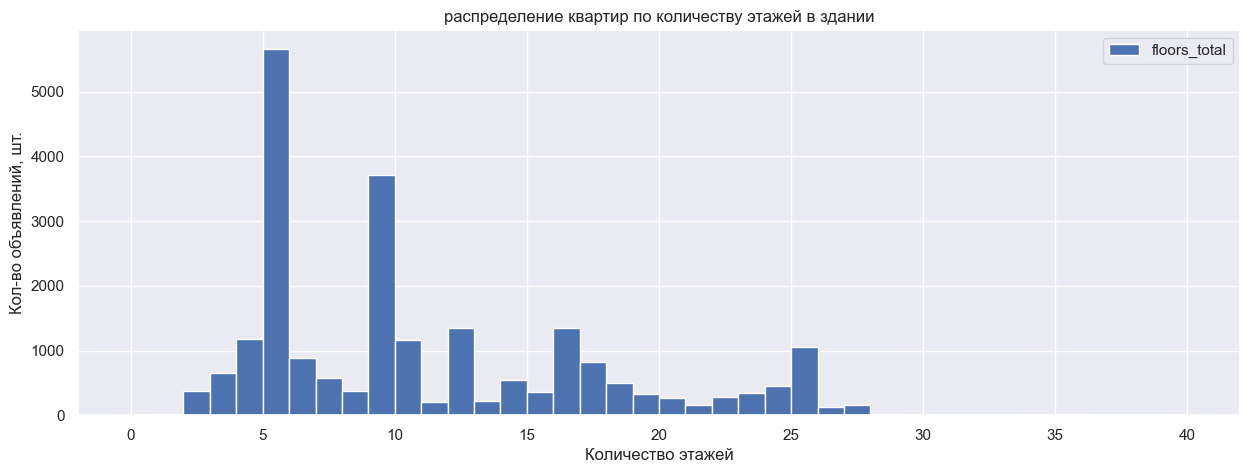

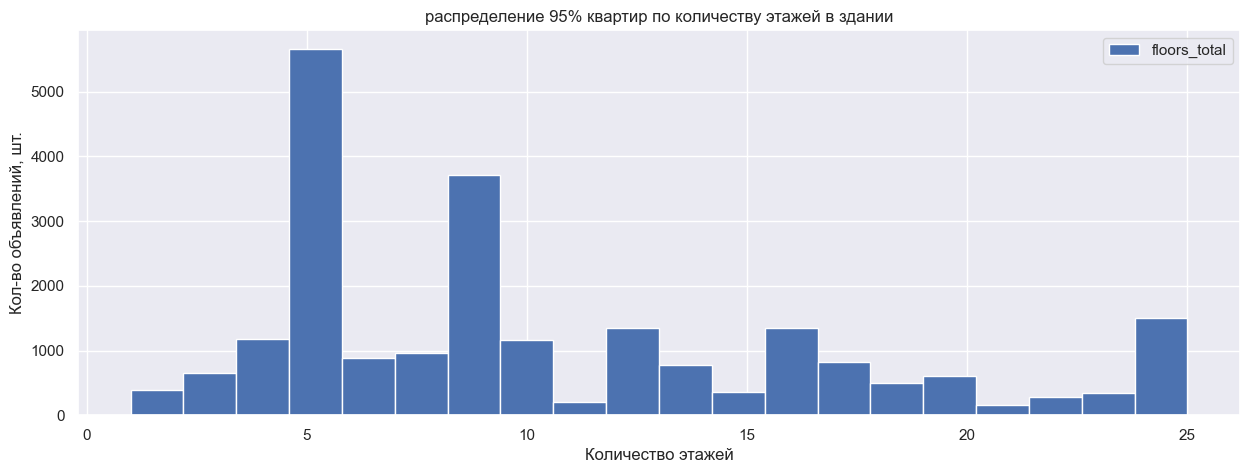

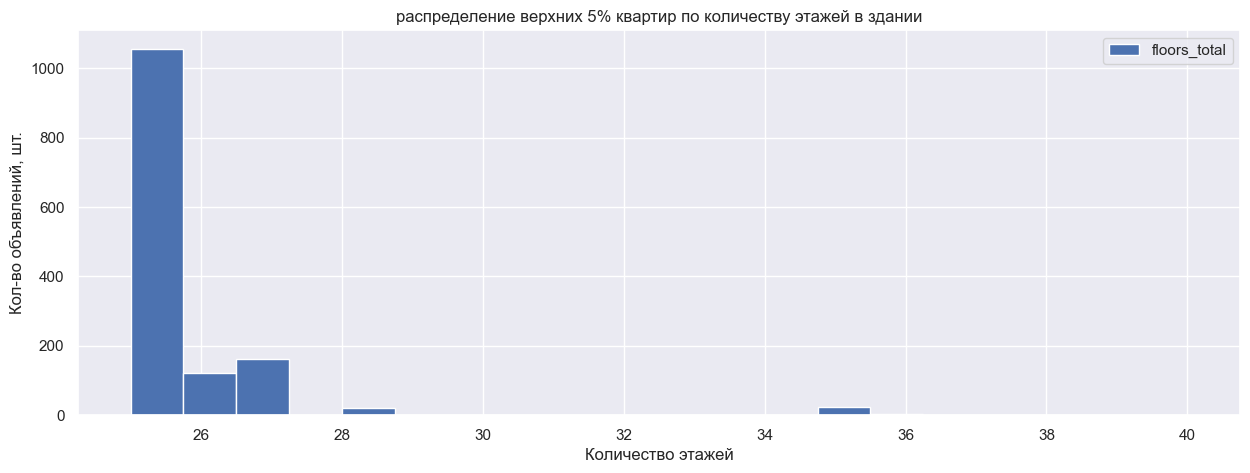

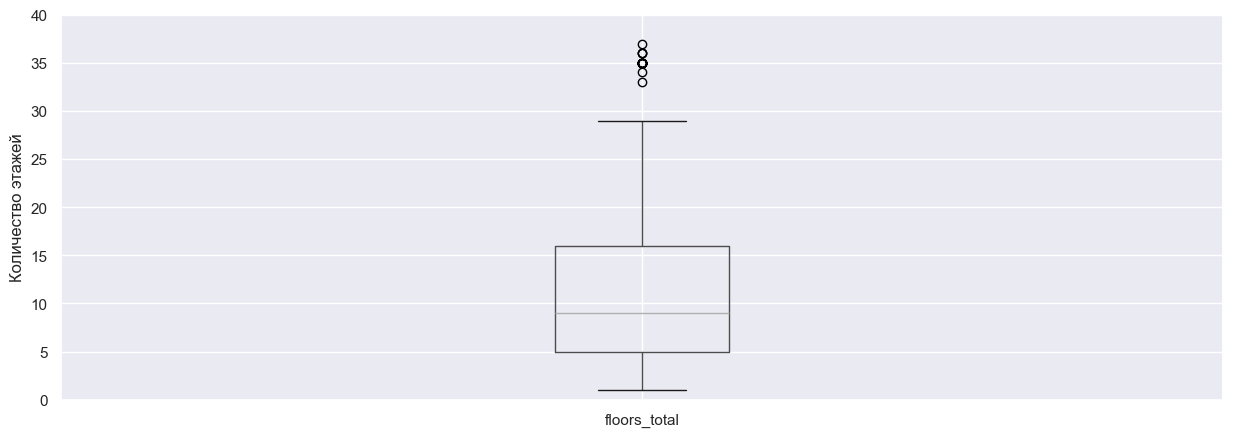

In [79]:
# распределение квартир по количеству этажей в здании
data.plot(kind='hist', y='floors_total', grid=True, range=(0,40), bins=40, figsize=(15,5))
plt.title('распределение квартир по количеству этажей в здании')
plt.xlabel('Количество этажей')
plt.ylabel('Кол-во объявлений, шт.')
plt.show()

# распределение 95% квартир по высоте потолков
data.plot(kind='hist', y='floors_total', grid=True, bins=20, figsize=(15,5), range=(1, 25))
plt.title('распределение 95% квартир по количеству этажей в здании')
plt.xlabel('Количество этажей')
plt.ylabel('Кол-во объявлений, шт.')
plt.show()

# распределение верхних 5% квартир по высоте потолков
data.plot(kind='hist', y='floors_total', grid=True, bins=20, figsize=(15,5), range=(25, 40))
plt.title('распределение верхних 5% квартир по количеству этажей в здании')
plt.xlabel('Количество этажей')
plt.ylabel('Кол-во объявлений, шт.')
plt.show()

# график с усами
data.boxplot(column='floors_total', grid=True, figsize=(15,5))
plt.ylim(0,40)
plt.ylabel('Количество этажей')
plt.show()

**Вывод:**  
- среднее значение количества этажей в здании примерно равно 11, а также примерно равно медиане, составляющей 9 этажей. Ст. ошибка меньше среднего
- 99% всех квартир находятся в зданиях до 26 этажей
- по бокспллоту выбросов достаточно мало, и они не влияют на распределение данных, медиана не стремится к хвосту выбросов
- аномальные значения заменены

Пики на графике объясняются унификацией стандартов застройки: так, почти все хрущёвки и сталинки являются пятиэтажками, брежневки - девятиэтажками, а средняя этажность высотных жилых зданий в России - 12

### Расстояние до центра (city_centers_nearest)

In [80]:
data['city_centers_nearest_km'].describe(percentiles=[0.01,0.1,0.25,0.5,0.75,0.9,0.95,0.99])

count   17826.00
mean       14.20
std         8.62
min         0.00
1%          1.00
10%         5.00
25%         9.00
50%        13.00
75%        16.00
90%        26.00
95%        32.00
99%        50.00
max        66.00
Name: city_centers_nearest_km, dtype: float64

Посмотрим на адекватность минимальных значений

In [81]:
(data.query('city_centers_nearest_km < 1')[['airports_nearest', 'city_centers_nearest_km', 'locality_name']]
.sort_values(by='city_centers_nearest_km')
)

airports_nearest  city_centers_nearest_km    locality_name
492            21740.00                     0.00  Санкт-Петербург
17078          21990.00                     0.00  Санкт-Петербург
16495          21740.00                     0.00  Санкт-Петербург
13919          21860.00                     0.00  Санкт-Петербург
13776          21857.00                     0.00  Санкт-Петербург
13694          21633.00                     0.00  Санкт-Петербург
12556          21857.00                     0.00  Санкт-Петербург
11723          21860.00                     0.00  Санкт-Петербург
11492          21860.00                     0.00  Санкт-Петербург
10867          21860.00                     0.00  Санкт-Петербург
9488           21653.00                     0.00  Санкт-Петербург
8677           21369.00                     0.00  Санкт-Петербург
8614           21818.00                     0.00  Санкт-Петербург
8239           21982.00                     0.00  Санкт-Петербург
7726           21860.00                     0.00  Санкт-Петербург
5518           21919.00                     0.00  Санкт-Петербург
5297           21860.00                     0.00  Санкт-Петербург
3800           22074.00                     0.00  Санкт-Петербург
2988           21919.00                     0.00  Санкт-Петербург
2609           21832.00                     0.00  Санкт-Петербург
2291           21776.00                     0.00  Санкт-Петербург
1934           21908.00                     0.00  Санкт-Петербург
1182           21632.00                     0.00  Санкт-Петербург
1109           21860.00                     0.00  Санкт-Петербург
20873          21739.00                     0.00  Санкт-Петербург
22036          21875.00                     0.00  Санкт-Петербург

Они находятся в Санкт-Петербурге, а также их значения расстояний до аэропорта примерно одинаковы, значит значения адекватны

Построим необходимые графики

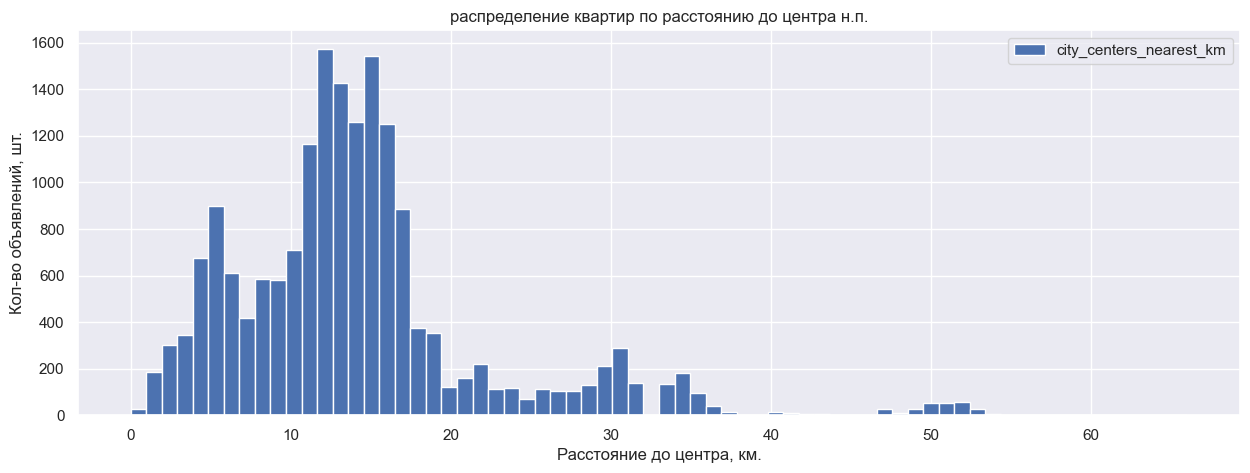

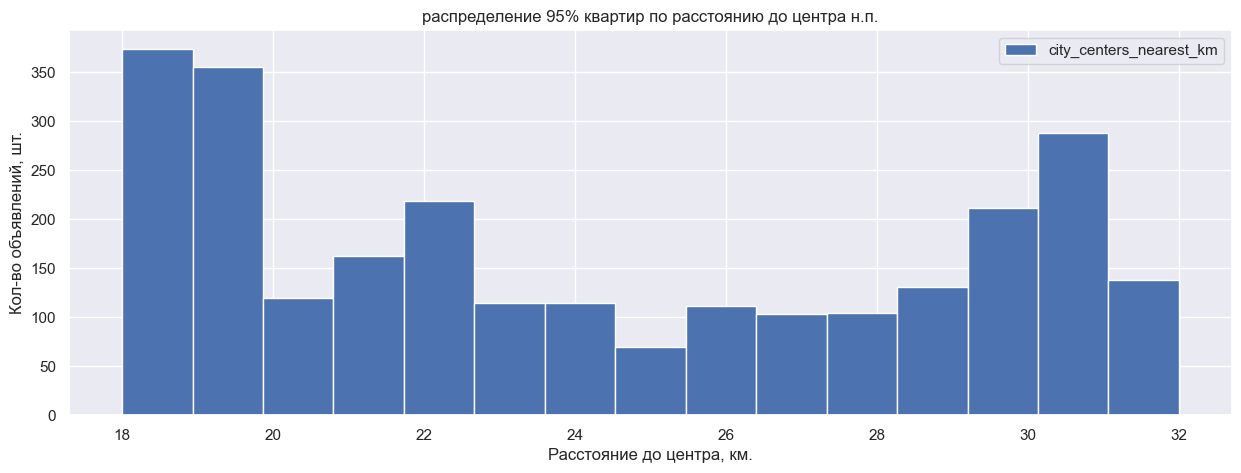

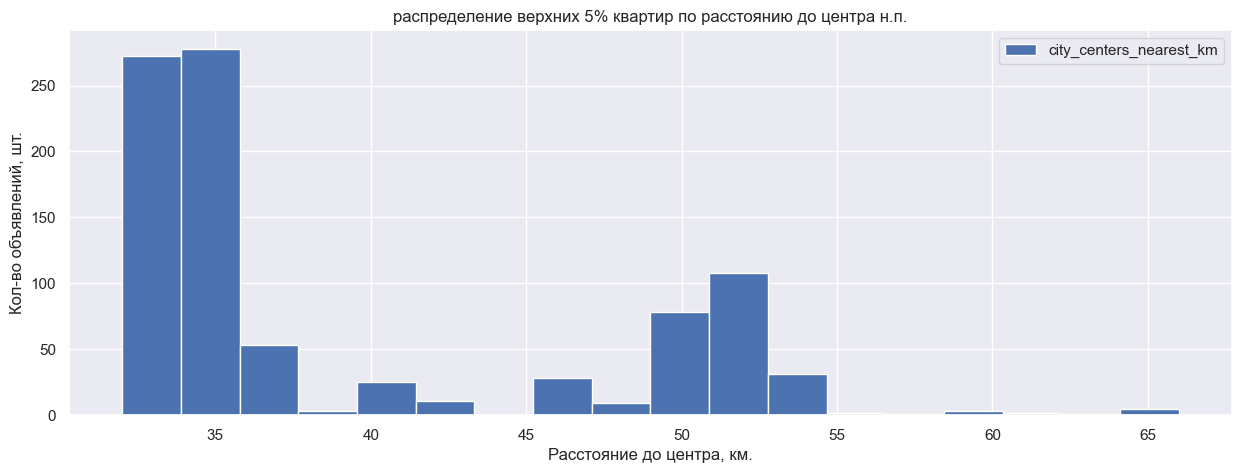

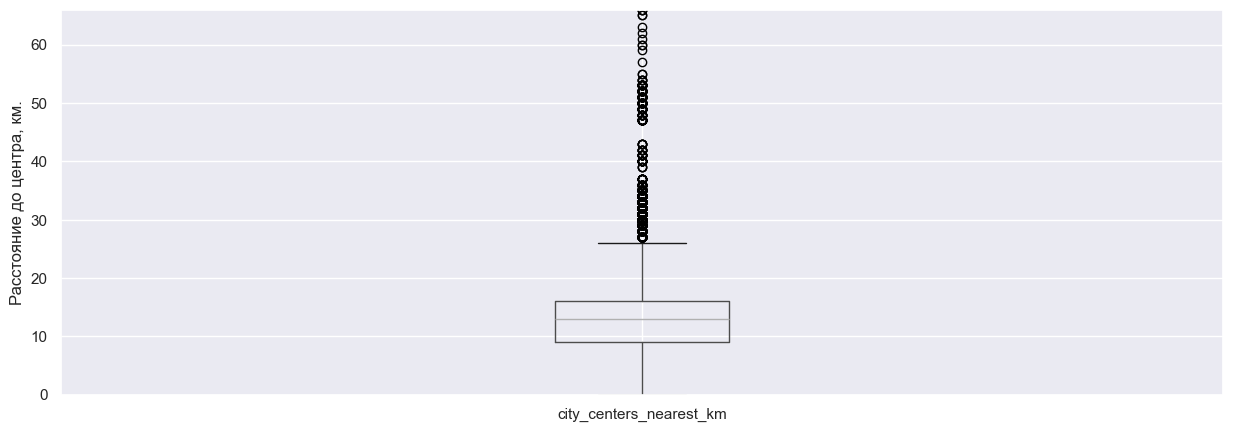

In [82]:
# распределение квартир по расстоянию до центра н.п.
data.plot(kind='hist', y='city_centers_nearest_km', grid=True, range=(0,66), bins=68, figsize=(15,5))
# sns.displot(data['city_centers_nearest_km'], bins=60)
plt.title('распределение квартир по расстоянию до центра н.п.')
plt.xlabel('Расстояние до центра, км.')
plt.ylabel('Кол-во объявлений, шт.')
plt.grid(True)
plt.show()

# распределение 95% квартир по расстоянию до центра н.п.
data.plot(kind='hist', y='city_centers_nearest_km', grid=True, bins=15, figsize=(15,5), range=(18, 32))
plt.title('распределение 95% квартир по расстоянию до центра н.п.')
plt.xlabel('Расстояние до центра, км.')
plt.ylabel('Кол-во объявлений, шт.')
plt.show()

# распределение верхних 5% квартир по расстоянию до центра н.п.
data.plot(kind='hist', y='city_centers_nearest_km', grid=True, bins=18, figsize=(15,5), range=(32, 66))
plt.title('распределение верхних 5% квартир по расстоянию до центра н.п.')
plt.xlabel('Расстояние до центра, км.')
plt.ylabel('Кол-во объявлений, шт.')
plt.show()

# график с усами
data.boxplot(column='city_centers_nearest_km', grid=True, figsize=(15,5))
plt.ylim(0,66)
plt.ylabel('Расстояние до центра, км.')
plt.show()

**Вывод:**
- среднее значение расстояния до центра н.п. примерно равно 14 км., а также примерно равно медиане, составляющей примерно 13 км. Ст. ошибка меньше среднего
- 95% всех квартир укладывается в расстояние примерно равное 32 км. до центра н.п.
- по бокспллоту выбросов достаточно много, медиана не стремится к хвосту выбросов

### Расстояние до парков (parks_nearest)

In [83]:
data['parks_nearest'].describe(percentiles=[0.01,0.1,0.25,0.5,0.75,0.9,0.95,0.99])

count   7915.00
mean     491.03
std      341.78
min        1.00
1%        24.00
10%      160.00
25%      288.00
50%      455.00
75%      612.00
90%      762.60
95%      968.00
99%     2102.00
max     3190.00
Name: parks_nearest, dtype: float64

Посмотрим на минимальные значения

In [84]:
data.query('parks_nearest < 10').sort_values(by='parks_nearest')

total_images  last_price  total_area first_day_exposition  rooms  \
14624             8     3770.00       45.40           2019-03-20      2   
11949             7     4500.00       44.00           2017-11-24      2   
22941             8    10965.00       69.30           2019-01-10      1   
9344             12     3000.00       28.10           2017-07-25      1   
2527              8     4690.00       60.30           2016-03-05      2   
20193             3    11809.67      102.60           2017-04-21      3   

       ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
14624            2.50             9        28.43      2             0       0   
11949            2.60             9        30.00      7             0       0   
22941            3.00             4        48.90      4             1       0   
9344             2.50             9        17.00      1             0       0   
2527             2.50             5        28.00      2             0       0   
20193            2.50             9        45.00      3             0       0   

       open_plan  kitchen_area  balcony    locality_name  airports_nearest  \
14624          0          6.90        0  Санкт-Петербург          43932.00   
11949          0          7.00        0  Санкт-Петербург          11806.00   
22941          0         17.17        2      Зеленогорск          73391.00   
9344           0          5.60        0  Санкт-Петербург          12051.00   
2527           0          7.90        0        Кронштадт          69775.00   
20193          0         17.80        2  Санкт-Петербург          27562.00   

       city_centers_nearest  parks_around3000  parks_nearest  \
14624              16436.00              1.00           1.00   
11949              12292.00              1.00           3.00   
22941              54490.00              3.00           4.00   
9344               11665.00              1.00           7.00   
2527               51500.00              3.00           9.00   
20193               6410.00              2.00           9.00   

       ponds_around3000  ponds_nearest  days_exposition  cost_per_m2  \
14624              0.00            NaN            42.00     83039.65   
11949              1.00         508.00            82.00    102272.73   
22941              1.00         217.00           110.00    158225.11   
9344               1.00         780.00           440.00    106761.57   
2527               3.00         345.00           146.00     77777.78   
20193              2.00         480.00            90.00    115104.00   

      publish_dayofweek publish_month publish_year floor_category  \
14624                 2             3         2019         другой   
11949                 4            11         2017         другой   
22941                 3             1         2019      последний   
9344                  1             7         2017         первый   
2527                  5             3         2016         другой   
20193                 4             4         2017         другой   

       city_centers_nearest_km  
14624                    16.00  
11949                    12.00  
22941                    54.00  
9344                     12.00  
2527                     52.00  
20193                     6.00

Неясно, нужно ли удалять слишком низкие значения. Оставим как есть, поскольку парки могут находиться в шаговой доступности

Построим необходимые графики

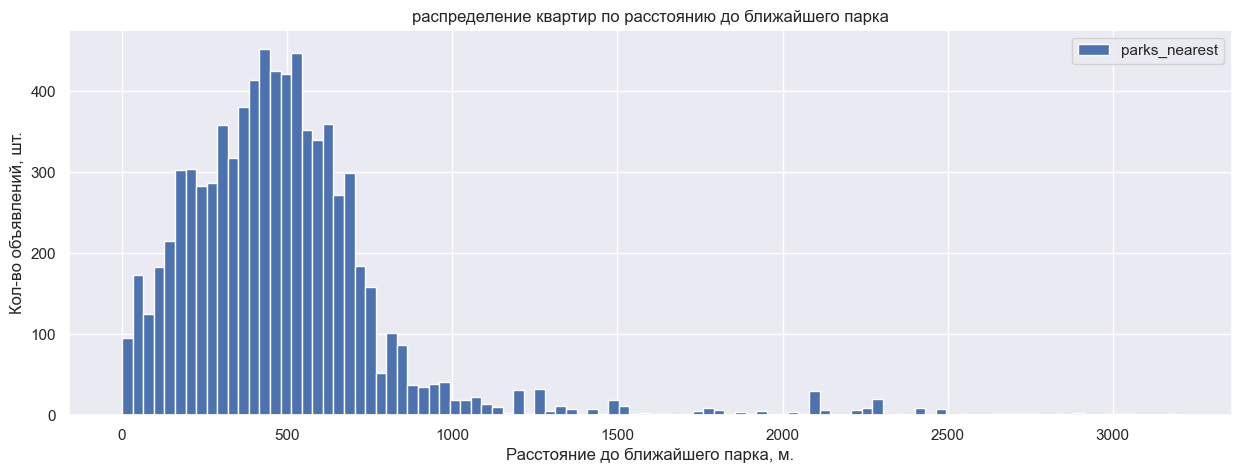

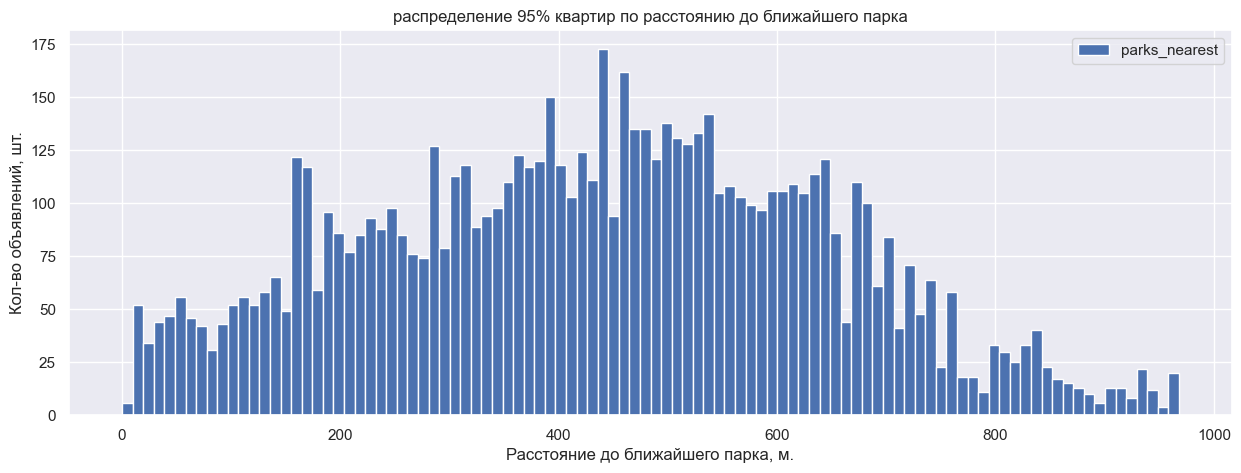

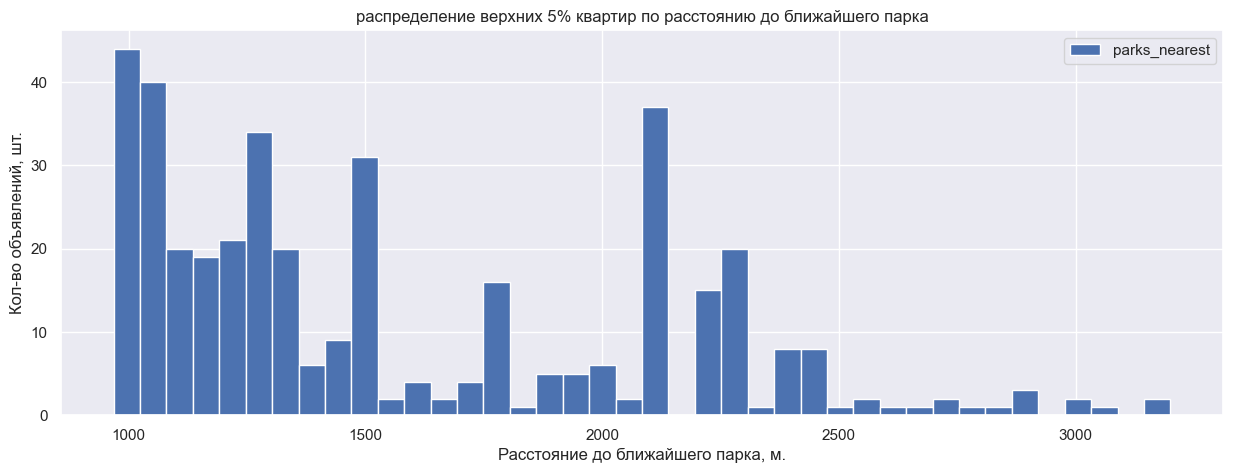

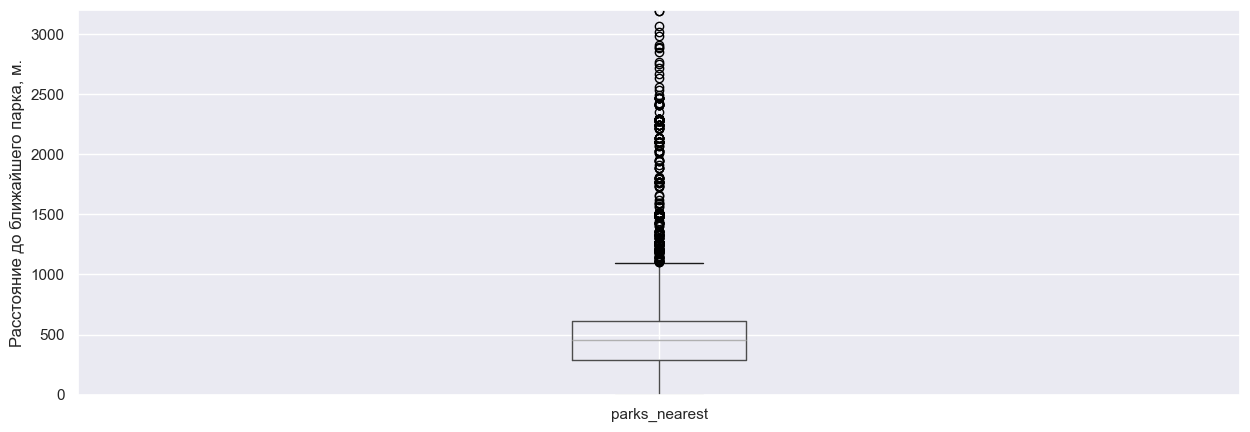

In [85]:
# распределение квартир по расстоянию до ближайшего парка
data.plot(kind='hist', y='parks_nearest', grid=True, range=(0,3200), bins=100, figsize=(15,5))
plt.title('распределение квартир по расстоянию до ближайшего парка')
plt.xlabel('Расстояние до ближайшего парка, м.')
plt.ylabel('Кол-во объявлений, шт.')
plt.show()

# распределение 95% квартир по расстоянию до ближайшего парка
data.plot(kind='hist', y='parks_nearest', grid=True, bins=100, figsize=(15,5), range=(0, 968))
plt.title('распределение 95% квартир по расстоянию до ближайшего парка')
plt.xlabel('Расстояние до ближайшего парка, м.')
plt.ylabel('Кол-во объявлений, шт.')
plt.show()

# распределение верхних 5% квартир по расстоянию до ближайшего парка
data.plot(kind='hist', y='parks_nearest', grid=True, bins=40, figsize=(15,5), range=(968, 3200))
plt.title('распределение верхних 5% квартир по расстоянию до ближайшего парка')
plt.xlabel('Расстояние до ближайшего парка, м.')
plt.ylabel('Кол-во объявлений, шт.')
plt.show()

# график с усами
data.boxplot(column='parks_nearest', grid=True, figsize=(15,5))
plt.ylim(0,3200)
plt.ylabel('Расстояние до ближайшего парка, м.')
plt.show()

**Вывод:**
- среднее значение расстояния до парка примерно равно 491 м., а также примерно равно медиане, составляющей примерно 455 м. Ст. ошибка меньше среднего
- 95% всех квартир укладывается в расстояние равное 968 м. до парка
- по бокспллоту выбросов достаточно много, медиана не стремится к хвосту выбросов

## Исследование: как быстро продавались квартиры

In [86]:
data['days_exposition'].describe(percentiles=[0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99])

count   20064.00
mean      181.56
std       220.35
min         1.00
1%          4.00
5%          9.00
10%        17.00
25%        45.00
50%        96.00
75%       232.00
90%       461.00
95%       649.00
99%      1070.37
max      1580.00
Name: days_exposition, dtype: float64

In [87]:
data.query('days_exposition >= 1046').sort_values(by='days_exposition', ascending=False)

total_images  last_price  total_area first_day_exposition  rooms  \
18843            11     3500.00       48.20           2014-12-15      2   
1109              1    34878.56       95.80           2014-12-09      2   
9553             11    10600.00       80.00           2014-12-09      3   
1885              2    13300.00       79.60           2014-12-09      2   
20969            18    13300.00      133.00           2015-02-11      4   
...             ...         ...         ...                  ...    ...   
18898             5     3500.00       43.70           2015-11-25      2   
14310             4     3595.00       55.09           2015-09-15      1   
21747             6     4369.27       64.50           2015-03-10      2   
21426            15    14000.00      137.00           2015-08-31      5   
12220             6     4768.71       67.80           2015-03-10      2   

       ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
18843            2.50             5        27.40      2             0       0   
1109             2.50             6        58.30      5             1       0   
9553             2.85            17        44.00      9             0       0   
1885             3.00             8        42.70      7             0       0   
20969            3.00             5        58.00      2             0       0   
...               ...           ...          ...    ...           ...     ...   
18898            2.50             5        27.80      3             0       0   
14310            2.50            18        17.60      1             0       0   
21747            2.70            23        31.60      8             0       0   
21426            3.00             7        90.00      4             0       0   
12220            2.70            23        31.20     11             0       0   

       open_plan  kitchen_area  balcony    locality_name  airports_nearest  \
18843          0          7.70        3  Новое Девяткино               NaN   
1109           0         20.00        1  Санкт-Петербург          21860.00   
9553           0         15.00        0  Санкт-Петербург          17101.00   
1885           0         18.00        0  Санкт-Петербург          39393.00   
20969          0         45.00        0  Санкт-Петербург          24653.00   
...          ...           ...      ...              ...               ...   
18898          0          5.30        0         Петергоф          39555.00   
14310          0         18.93        0           Мурино               NaN   
21747          0         12.10        0  Санкт-Петербург          21793.00   
21426          0         23.00        1  Санкт-Петербург          23546.00   
12220          0         14.60        0  Санкт-Петербург          21793.00   

       city_centers_nearest  parks_around3000  parks_nearest  \
18843                   NaN               NaN            NaN   
1109                 318.00              2.00         160.00   
9553               17110.00              0.00            NaN   
1885               11096.00              1.00         537.00   
20969               5032.00              0.00            NaN   
...                     ...               ...            ...   
18898              31364.00              3.00         278.00   
14310                   NaN               NaN            NaN   
21747              17121.00              0.00            NaN   
21426               3088.00              1.00         347.00   
12220              17121.00              0.00            NaN   

       ponds_around3000  ponds_nearest  days_exposition  cost_per_m2  \
18843               NaN            NaN          1580.00     72614.11   
1109               3.00         569.00          1572.00    364076.78   
9553               0.00            NaN          1553.00    132500.00   
1885               0.00            NaN          1513.00    167085.43   
20969              1.00         534.00          1512.00    100000.0

In [88]:
data.query('days_exposition < 9').sort_values(by='days_exposition')

total_images  last_price  total_area first_day_exposition  rooms  \
1632             19     4000.00       49.90           2019-05-01      2   
16053             4     4070.00       45.10           2019-04-30      2   
16212             0     7806.00       25.00           2019-04-30      1   
13061            20     6100.00       51.40           2019-04-29      2   
17766             9     3200.00       47.00           2017-11-08      2   
...             ...         ...         ...                  ...    ...   
5425              0     3300.00       38.00           2018-09-07      1   
7743             11     5050.00       50.20           2018-10-15      2   
18782             0     2500.00       25.00           2017-10-08      0   
3258             15     4500.00       55.60           2018-03-24      2   
18400             1     4650.00       71.00           2018-11-20      2   

       ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
1632             2.50             9        25.00      1             0       0   
16053            2.50             5        22.70      3             0       0   
16212            3.00             5        17.60      5             0       0   
13061            3.00             5        31.70      4             0       0   
17766            2.55             9        28.00      1             0       0   
...               ...           ...          ...    ...           ...     ...   
5425             2.50             9        18.00      3             0       0   
7743             2.56             9        30.30      3             0       0   
18782            2.50            22        17.00     19             0       0   
3258             2.64            12        33.50     10             0       0   
18400            3.00             5        35.00      5             0       0   

       open_plan  kitchen_area  balcony    locality_name  airports_nearest  \
1632           0         10.00        0  Санкт-Петербург          13567.00   
16053          0          6.60        0  Санкт-Петербург          40859.00   
16212          0          6.19        0  Санкт-Петербург          36525.00   
13061          0          6.90        1  Санкт-Петербург          10776.00   
17766          0          7.00        0  Санкт-Петербург          33013.00   
...          ...           ...      ...              ...               ...   
5425           0          8.00        0  Санкт-Петербург          15683.00   
7743           0         10.20        0  Санкт-Петербург          28834.00   
18782          1          6.19        1          Кудрово               NaN   
3258           0         10.50        0  Санкт-Петербург          15606.00   
18400          0          8.00        0  Санкт-Петербург          27477.00   

       city_centers_nearest  parks_around3000  parks_nearest  \
1632               14384.00              1.00          20.00   
16053              11668.00              2.00         485.00   
16212              10302.00              0.00            NaN   
13061               9389.00              0.00            NaN   
17766              10885.00              2.00         279.00   
...                     ...               ...            ...   
5425               14479.00              2.00         594.00   
7743               13493.00              0.00            NaN   
18782                   NaN               NaN            NaN   
3258               14402.00              1.00         413.00   
18400               6325.00              2.00         501.00   

       ponds_around3000  ponds_nearest  days_exposition  cost_per_m2  \
1632               1.00         681.00             1.00     80160.32   
16053              0.00            NaN             2.00     90243.90   
16212              0.00            NaN             2.00    312240.00   
13061              0.00            NaN             2.00    118677.04   
17766              1.00         782.00             3.00     68085.1

Построим необходимые графики

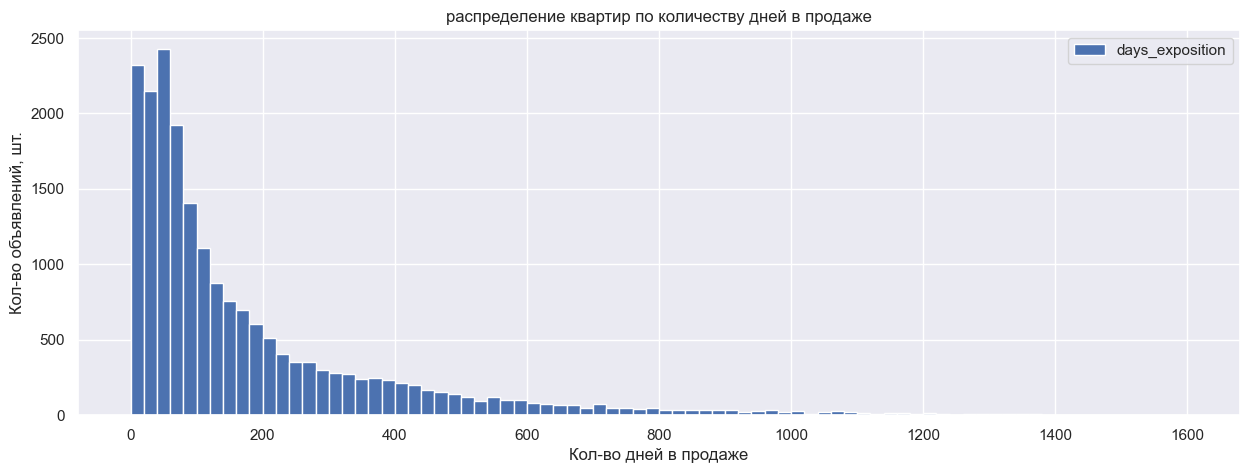

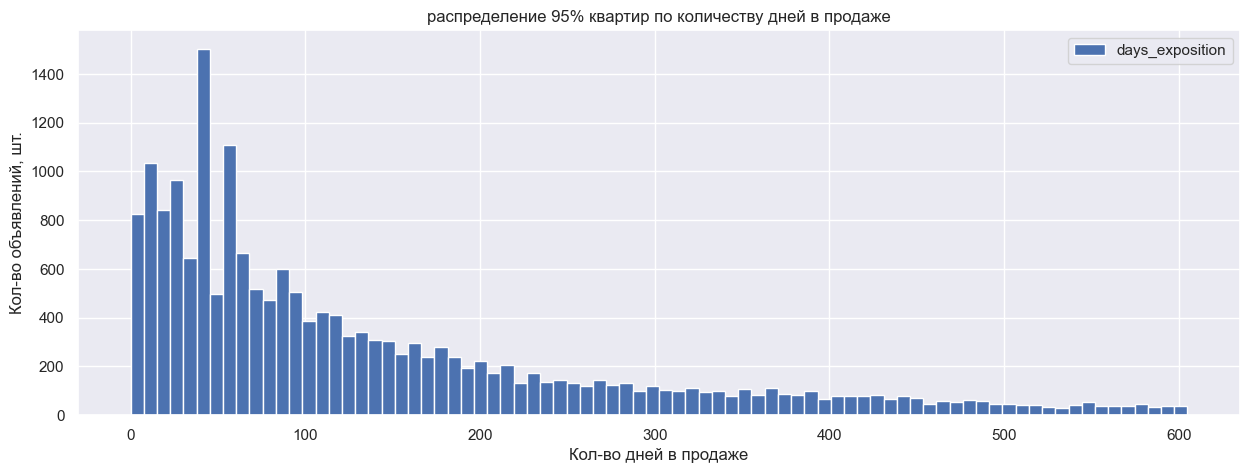

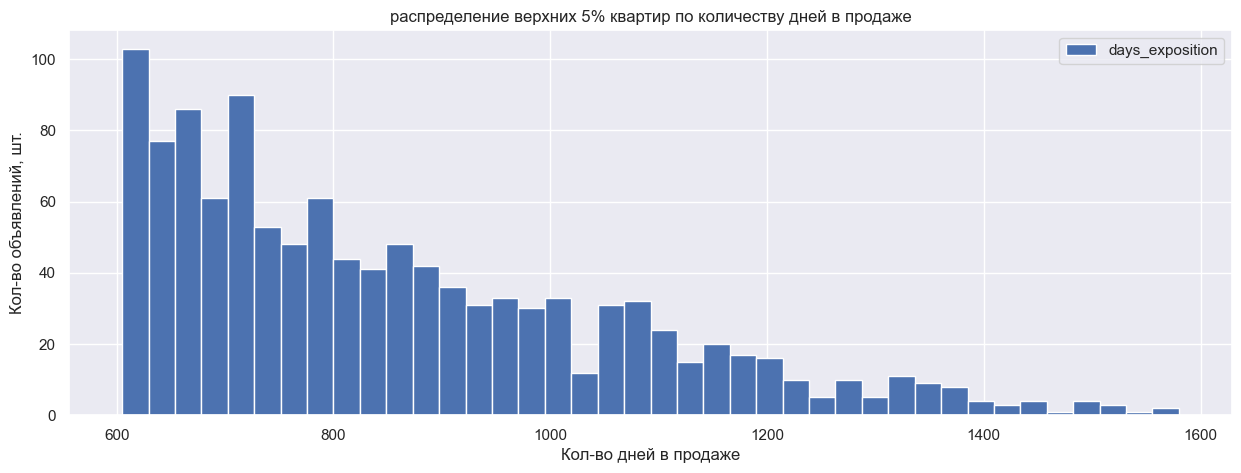

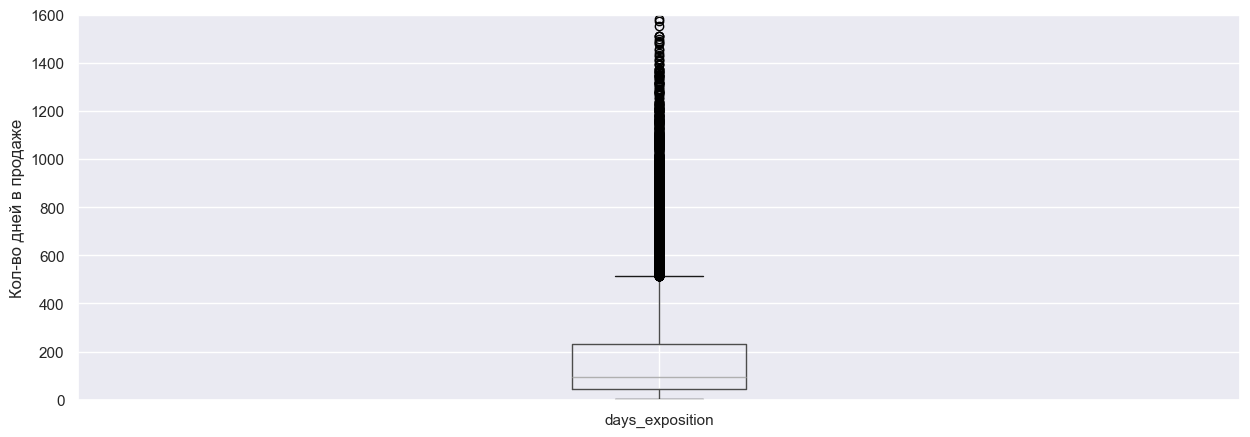

In [89]:
# распределение квартир по количеству дней в продаже
data.plot(kind='hist', y='days_exposition', grid=True, range=(0,1600), bins=80, figsize=(15,5))
plt.title('распределение квартир по количеству дней в продаже')
plt.xlabel('Кол-во дней в продаже')
plt.ylabel('Кол-во объявлений, шт.')
plt.show()

# распределение 95% квартир по количеству дней в продаже
data.plot(kind='hist', y='days_exposition', grid=True, bins=80, figsize=(15,5), range=(0, 605))
plt.title('распределение 95% квартир по количеству дней в продаже')
plt.xlabel('Кол-во дней в продаже')
plt.ylabel('Кол-во объявлений, шт.')
plt.show()

# распределение верхних 5% квартир по по количеству дней в продаже
data.plot(kind='hist', y='days_exposition', grid=True, bins=40, figsize=(15,5), range=(605, 1580))
plt.title('распределение верхних 5% квартир по количеству дней в продаже')
plt.xlabel('Кол-во дней в продаже')
plt.ylabel('Кол-во объявлений, шт.')
plt.show()

# график с усами
data.boxplot(column='days_exposition', grid=True, figsize=(15,5))
plt.ylim(0,1600)
plt.ylabel('Кол-во дней в продаже')
plt.show()

Сгруппируем данные по длительности продаж

In [90]:
data.groupby('days_exposition')['first_day_exposition'].count().sort_values(ascending=False).head(15)

days_exposition
45.00    837
60.00    521
7.00     224
30.00    208
90.00    195
4.00     171
3.00     154
5.00     150
14.00    145
9.00     139
8.00     137
20.00    134
11.00    133
44.00    131
18.00    128
Name: first_day_exposition, dtype: int64

**Вывод:**
1) Среднее время продажи квартир составляет почти 182 дня, медиана при этом равна 96 дням, что почти в два раза меньше среднего значения. Это происходит из-за наличия сверхдолгих (свыше 649 дней - это больше 21 мес.) или сверхбыстрых продаж (меньше 9 дней).

2) Обычным временем продаж будем считать межквартильный диапазон, а именно 45 - 232 дней.

3) Наибольшие пики приходятся на следующие значения:
- 30, 45, 60, 90 дней. Это "ровные" числа, поэтому предположим, что пики в этих значениях связаны с работой сайта по продаже недвижимости


## Факторы, влияющие на общую (полную) стоимость объекта

In [91]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23203 entries, 0 to 23698
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   total_images             23203 non-null  int64         
 1   last_price               23203 non-null  float64       
 2   total_area               23203 non-null  float64       
 3   first_day_exposition     23203 non-null  datetime64[ns]
 4   rooms                    23203 non-null  int64         
 5   ceiling_height           23203 non-null  float64       
 6   floors_total             23203 non-null  int32         
 7   living_area              23203 non-null  float64       
 8   floor                    23203 non-null  int64         
 9   is_apartment             23203 non-null  int32         
 10  studio                   23203 non-null  int32         
 11  open_plan                23203 non-null  int32         
 12  kitchen_area             23203 non-nu

Попробуем создать новый датасет, очищенный от выбросов, для улучшенной визуализации данных

In [92]:
data_filtered = data.query('last_price<50000 and total_area<200 and living_area<120 and kitchen_area<40 and \
                          rooms<5 and ceiling_height<4')

In [93]:
data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22440 entries, 0 to 23698
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   total_images             22440 non-null  int64         
 1   last_price               22440 non-null  float64       
 2   total_area               22440 non-null  float64       
 3   first_day_exposition     22440 non-null  datetime64[ns]
 4   rooms                    22440 non-null  int64         
 5   ceiling_height           22440 non-null  float64       
 6   floors_total             22440 non-null  int32         
 7   living_area              22440 non-null  float64       
 8   floor                    22440 non-null  int64         
 9   is_apartment             22440 non-null  int32         
 10  studio                   22440 non-null  int32         
 11  open_plan                22440 non-null  int32         
 12  kitchen_area             22440 non-nu

Потеряно около 3% данных, значит фильтр приемлем

In [94]:
data_filtered.describe()

total_images  last_price  total_area           first_day_exposition  \
count      22440.00    22440.00    22440.00                          22440   
mean           9.84     5641.41       56.39  2017-11-13 00:19:22.780748544   
min            0.00      430.00       14.00            2014-11-27 00:00:00   
25%            6.00     3400.00       40.00            2017-05-17 00:00:00   
50%            9.00     4550.00       51.00            2017-12-14 00:00:00   
75%           14.00     6500.00       67.00            2018-08-28 00:00:00   
max           50.00    49900.00      198.00            2019-05-03 00:00:00   
std            5.63     4165.43       23.28                            NaN   

         rooms  ceiling_height  floors_total  living_area    floor  \
count 22440.00        22440.00      22440.00     22440.00 22440.00   
mean      1.97            2.62         10.80        31.88     5.93   
min       0.00            2.00          1.00         5.40     1.00   
25%       1.00            2.50          5.00        18.10     2.00   
50%       2.00            2.50          9.00        30.00     4.00   
75%       3.00            2.70         16.00        41.00     8.00   
max       4.00            3.98         37.00       117.00    33.00   
std       0.91            0.21          6.60        14.98     4.89   

       is_apartment   studio  open_plan  kitchen_area  balcony  \
count      22440.00 22440.00   22440.00      22440.00 22440.00   
mean           0.00     0.01       0.00         10.25     0.60   
min            0.00     0.00       0.00          0.00     0.00   
25%            0.00     0.00       0.00          7.00     0.00   
50%            0.00     0.00       0.00          9.17     0.00   
75%            0.00     0.00       0.00         12.00     1.00   
max            1.00     1.00       1.00         39.90     5.00   
std            0.04     0.08       0.05          4.72     0.96   

       airports_nearest  city_centers_nearest  parks_around3000  \
count          17085.00              17105.00          17106.00   
mean           28923.24              14499.64              0.59   
min                0.00                208.00              0.00   
25%            18414.00               9802.00              0.00   
50%            27102.00              13265.00              0.00   
75%            37434.00              16447.00              1.00   
max            84869.00              65968.00              3.00   
std            12789.19               8555.60              0.78   

       parks_nearest  ponds_around3000  ponds_nearest  days_exposition  \
count        7439.00          17106.00        8441.00         19509.00   
mean          495.08              0.75         522.90           178.25   
min             1.00              0.00          13.00             1.00   
25%           290.00              0.00         303.00            44.00   
50%           457.00              0.00         507.00            94.00   
75%           617.00              1.00         733.00           227.00   
max          3190.00              3.00        1344.00          1580.00   
std           343.43              0.92         277.45           216.74   

       cost_per_m2  city_centers_nearest_km  
count     22440.00                 17105.00  
mean      96952.61                    14.49  
min        7962.96                     0.00  
25%       76337.71                    10.00  
50%       94616.01                    13.00  
75%      113244.40                    16.00  
max      848484.85                    66.00  
std       38270.64                     8.56

Построим матрицу корреляции некоторых параметров датафрейма

<Axes: >

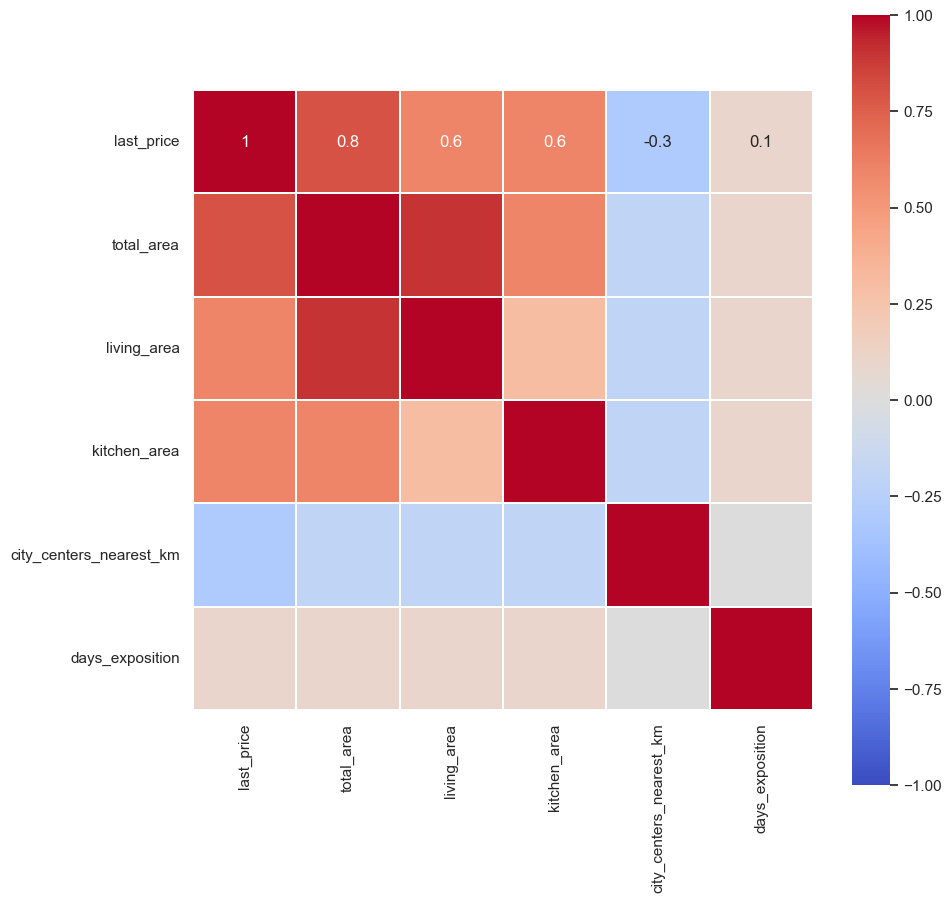

In [95]:
for_corr_matrix = data_filtered[['last_price','total_area','living_area','kitchen_area','city_centers_nearest_km','days_exposition']]
plt.figure(figsize=(10,10))
sns.heatmap(for_corr_matrix.corr().round(1), annot=True, cmap='coolwarm', square=True, linewidth=.1,robust=True, vmin=-1)

Аннотация отображается некорректно, поскольку обновление matplotlib сломало хитмэпы

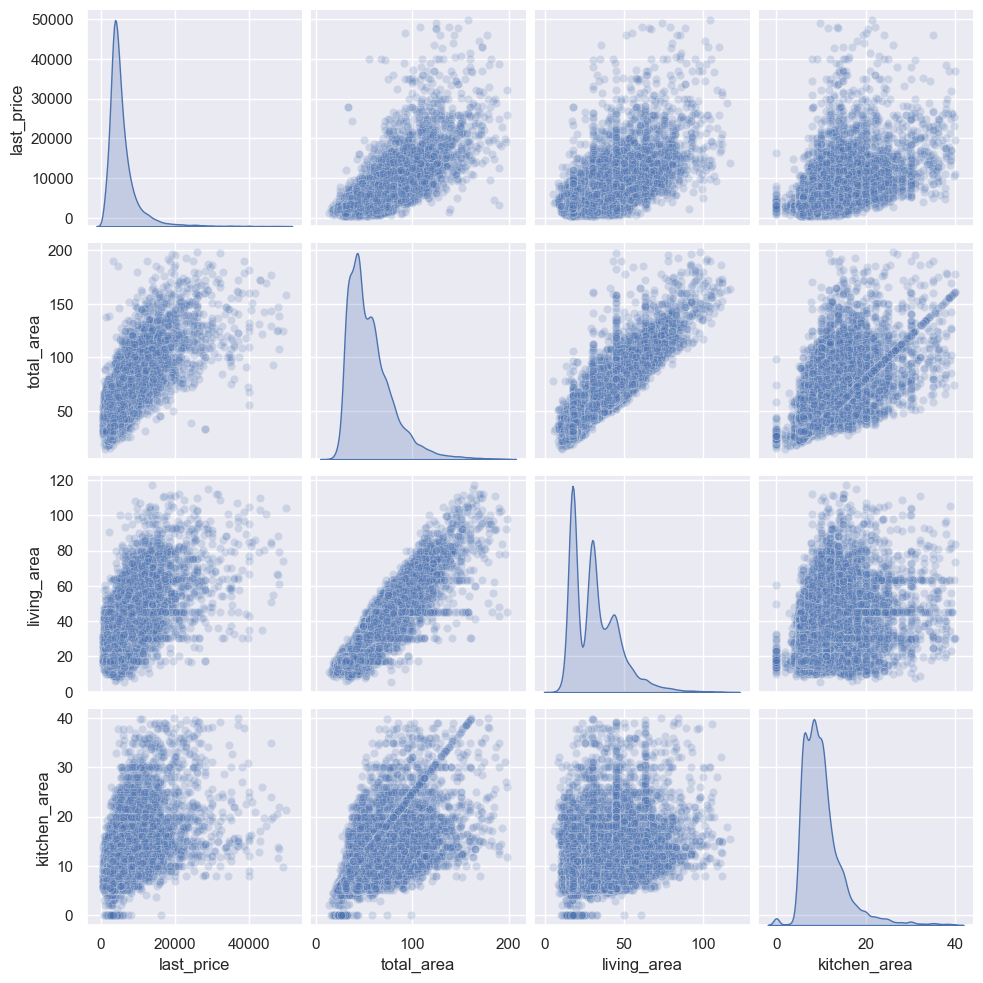

In [96]:
for_scatter_matrix = data_filtered[['last_price','total_area','living_area','kitchen_area']]
sns.pairplot(for_scatter_matrix, diag_kind='kde', plot_kws={'alpha': 0.2}, kind='scatter')
plt.show()

Построим графики для количественных данных

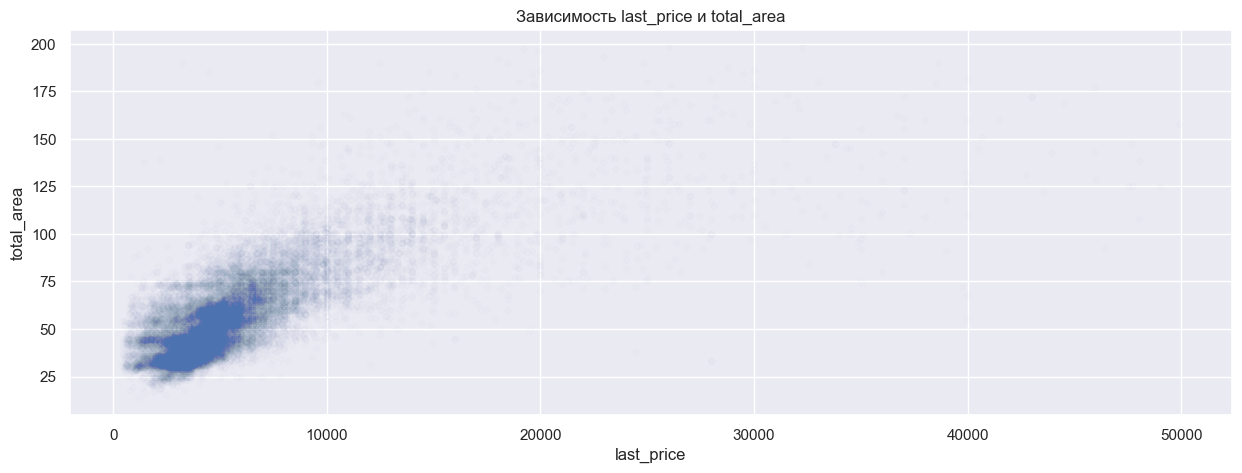

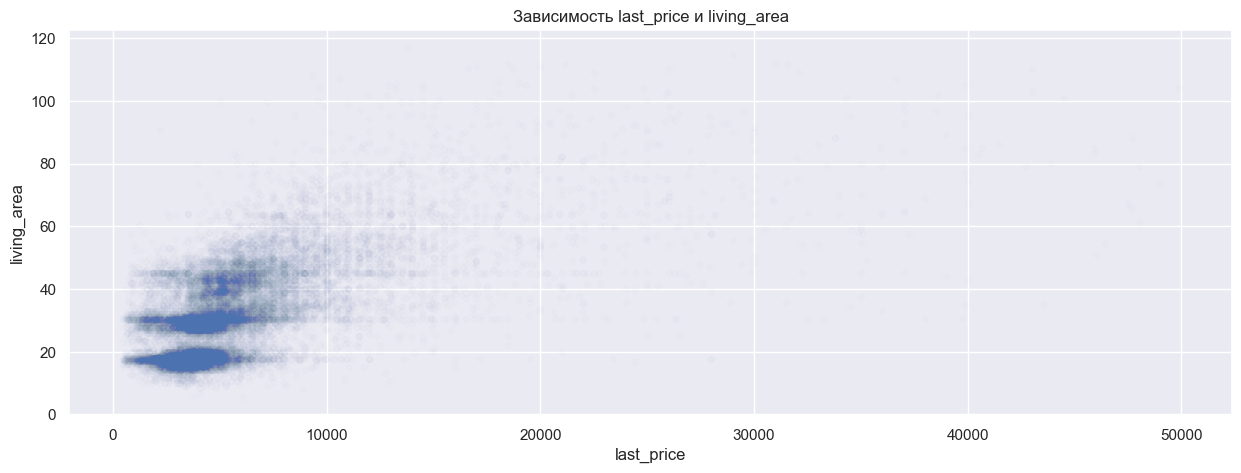

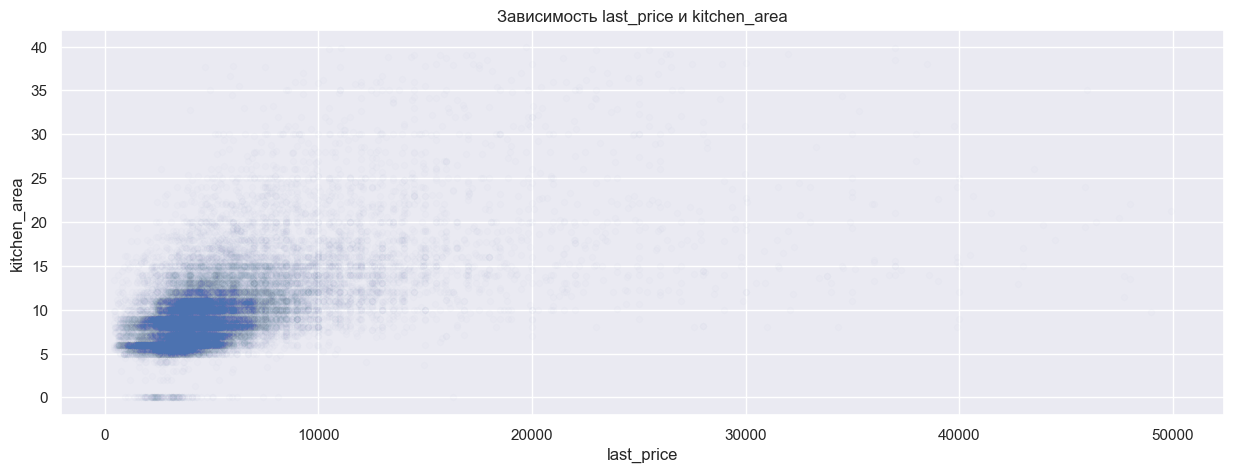

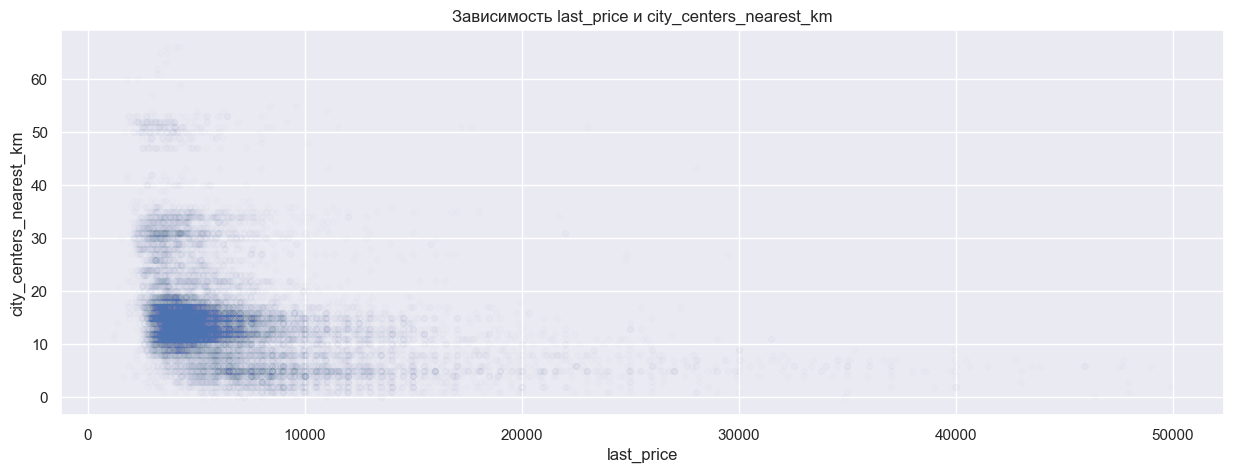

In [97]:
def build_plot(y):
    data_filtered.plot.scatter(x='last_price', y=y, figsize=(15, 5), grid=True, alpha=.01)
    plt.title(f'Зависимость last_price и {y}')
    
build_plot('total_area')
build_plot('living_area')
build_plot('kitchen_area')
build_plot('city_centers_nearest_km')

Построим графики для категориальных данных

In [98]:
data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22440 entries, 0 to 23698
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   total_images             22440 non-null  int64         
 1   last_price               22440 non-null  float64       
 2   total_area               22440 non-null  float64       
 3   first_day_exposition     22440 non-null  datetime64[ns]
 4   rooms                    22440 non-null  int64         
 5   ceiling_height           22440 non-null  float64       
 6   floors_total             22440 non-null  int32         
 7   living_area              22440 non-null  float64       
 8   floor                    22440 non-null  int64         
 9   is_apartment             22440 non-null  int32         
 10  studio                   22440 non-null  int32         
 11  open_plan                22440 non-null  int32         
 12  kitchen_area             22440 non-nu

Используем функцию для построения графиков

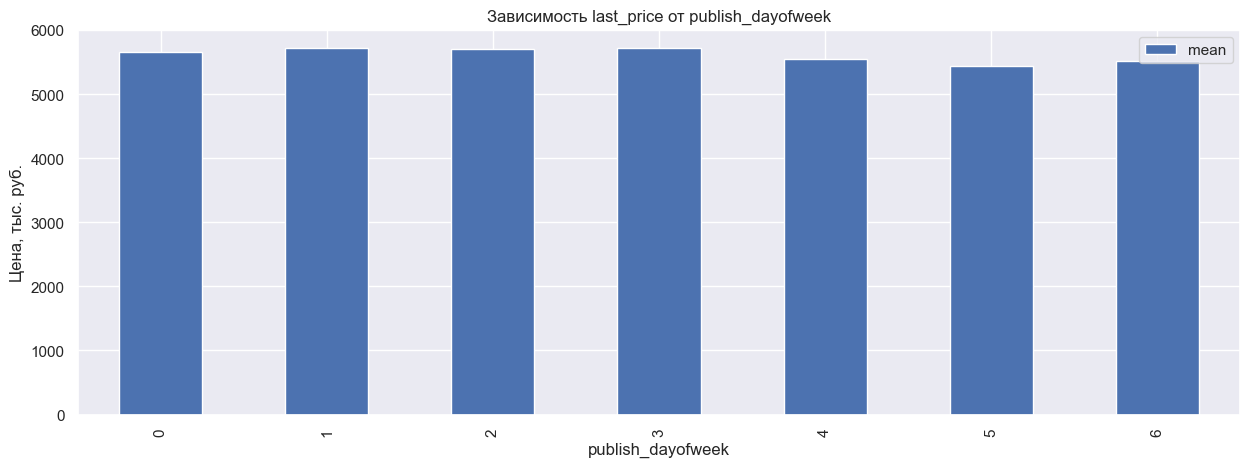

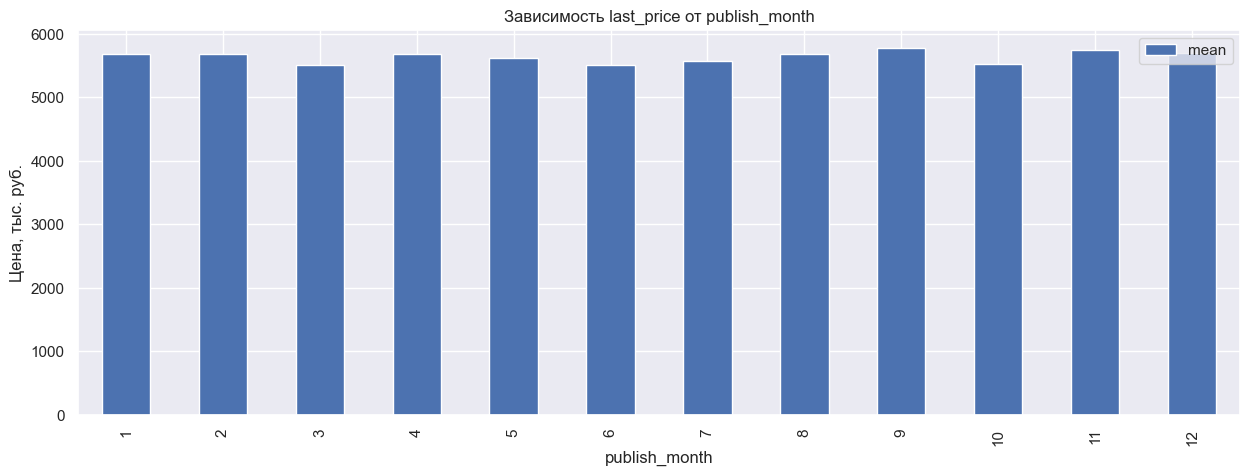

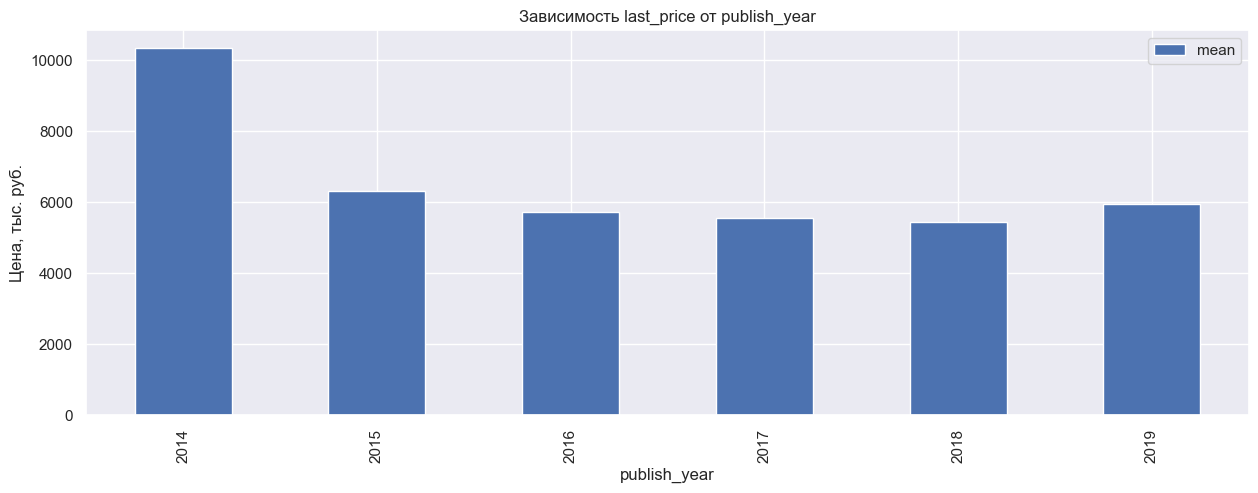

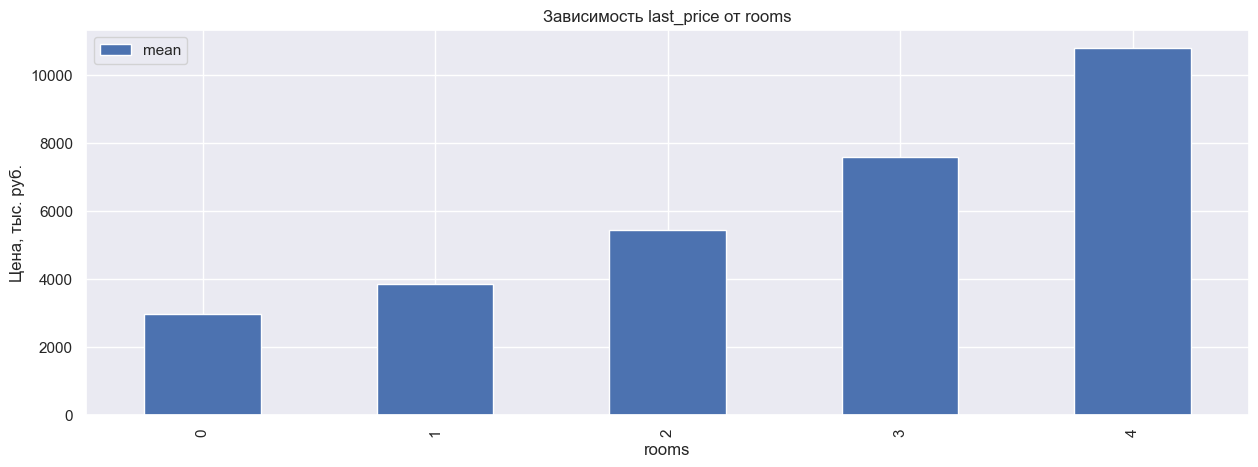

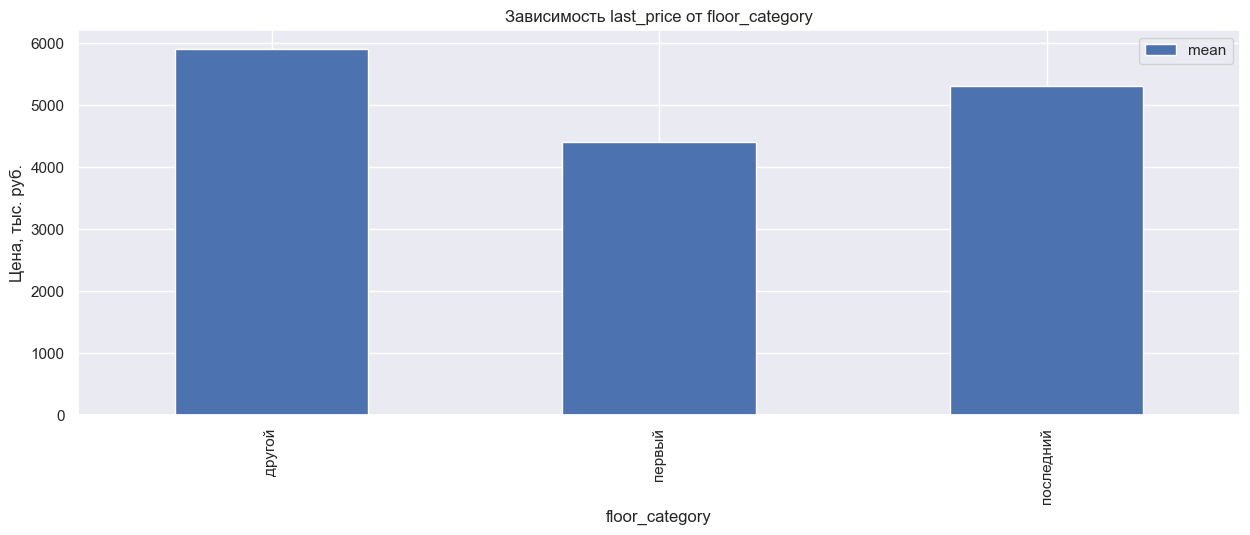

In [99]:
def pivtab_barplot(y):
    data_filtered.pivot_table(index=y, values='last_price', aggfunc={'mean'})\
    .plot(kind='bar')
    plt.title(f'Зависимость last_price от {y}')
    plt.ylabel('Цена, тыс. руб.')
    plt.show()

pivtab_barplot('publish_dayofweek')
pivtab_barplot('publish_month')
pivtab_barplot('publish_year')
pivtab_barplot('rooms')
pivtab_barplot('floor_category')

Посмотрим на числовые данные зависимости средней цены в руб. от года объявления о продаже

In [100]:
data_filtered.groupby('publish_year')['last_price'].agg(['mean', 'median'])

mean  median
publish_year                 
2014         10333.70 7476.56
2015          6321.39 5100.00
2016          5733.56 4450.00
2017          5544.21 4400.00
2018          5444.99 4500.00
2019          5936.14 5000.00

Посмотрим на распределение данных в столбце с годом объявления о продаже квартир

In [101]:
data_filtered['publish_year'].value_counts()

publish_year
2018    8121
2017    7778
2019    2739
2016    2611
2015    1068
2014     123
Name: count, dtype: int64

Распределение данных по годам показывает, что по сравнению с 2017 и 2018 годами в 2014-2016 и 2019 годах данных мало (особенно в 2014 году). Это может влиять на конечный результат.

Построим новый график, отбросив значения за 2014 г.

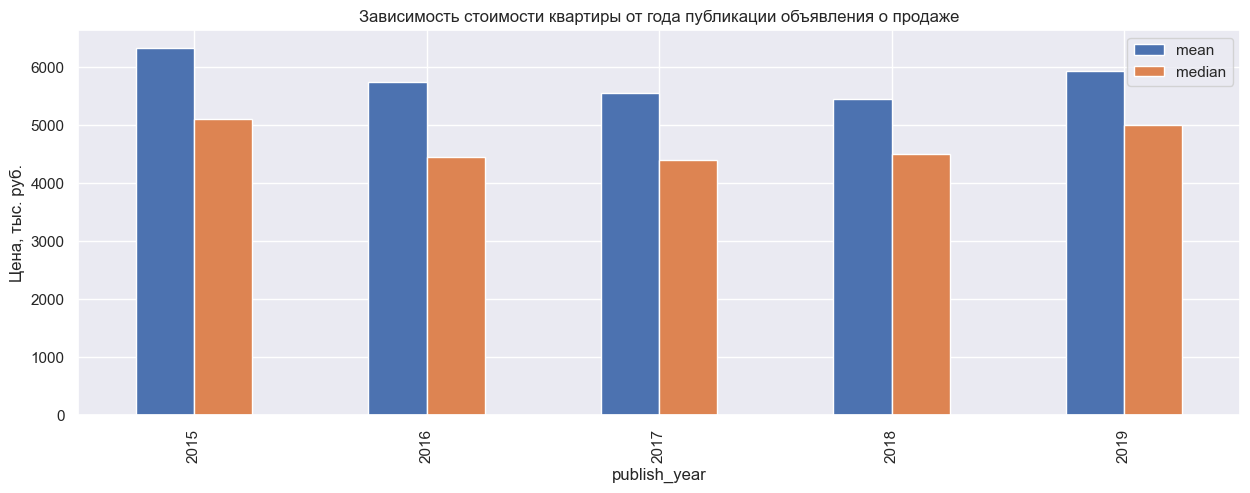

In [102]:
(data_filtered
 .query('publish_year > 2014')
 .pivot_table(index='publish_year', values='last_price', aggfunc={'mean','median'})
 .plot(kind='bar')
)

plt.title(f'Зависимость стоимости квартиры от года публикации объявления о продаже')
plt.ylabel('Цена, тыс. руб.')
plt.show()

По обновлённому графику заметно, что с 2015 года средняя цена значительно квартиры не изменилась: с 2016 по 2018 включительно наблюдается небольшой спад стоимости, с 2018 по 2019 заметен рост, в результате чего стоимость квартир в 2019 году стала немного выше, чем в 2016 и почти сравнялась со значением в 2015 году.

Посмотрим на числовые данные зависимости средней цены в руб. от количества комнат в квартире

In [103]:
data_filtered.groupby('rooms')['last_price'].agg(['mean', 'median'])

mean  median
rooms                 
0      2965.38 2700.00
1      3832.05 3600.00
2      5443.54 4750.00
3      7588.83 6150.00
4     10778.41 8750.00

Оценим адекватность распределения данных в столбце с количеством комнат в квартире

In [104]:
data_filtered['rooms'].value_counts()

rooms
1    7862
2    7766
3    5564
4    1058
0     190
Name: count, dtype: int64

**Вывод:**  
Больше остальных параметров на цену квартиры влияет: общая площадь(0.8).
Среднее влияние на результат имеют площадь кухни (0.6) и жилая площадь (0.6), а также расстояние до центра города (-0.3).

Прямое влияние на результат оказывает количество комнат: чем больше комнат, тем выше цена, а также тип этажа: наиболее дорогие квартиры находятся на "средних этажах", ожидаемо, наиболее дешёвые находятся на первых этажах.
Почти никак не влияют на цену день, месяц и год объявления о продаже.

## Средняя цена 1 м2 в 10 населённых пунктах с наибольшим числом объявлений

Воспользуемся отфильтрованным датасетом и сгруппируем 10 населённых пунктов по наибольшему количеству объявлений, а также укажем среднюю стоимость 1 кв. м.

In [105]:
top = data.pivot_table(index='locality_name', values='cost_per_m2', aggfunc={'count', 'mean'})\
.sort_values(by='count', ascending=False).head(10)

top.columns = [['sale_offers', 'mean_price_per_m2']]
top

sale_offers mean_price_per_m2
locality_name                                
Санкт-Петербург       15438         114575.55
Мурино                  568          85716.08
Кудрово                 464          95142.53
Шушары                  436          78495.27
Всеволожск              386          68787.26
Пушкин                  364         103183.48
Колпино                 334          75533.28
Парголово               325          90178.69
Гатчина                 302          68699.55
Выборг                  232          58244.59

Наибольшая средняя цена среди 10 населённых пунктов с наибольшим количеством объявлений представлена в Санкт-Петербурге и равна 114.6 тыс. руб. за кв. м., наименьшая средняя цена представлена в Выборге и равна 58.2 тыс. руб. за кв. м.

## Средняя стоимость квартир в СПб на разном удалении от центра

Создадим датафрейм с квартирами исключительно из Санкт-Петербурга

In [106]:
spb_data = data_filtered.query("locality_name == 'Санкт-Петербург'")
spb_data = spb_data[['city_centers_nearest_km', 'locality_name', 'last_price']]
cost_km_dep = spb_data.pivot_table(index='city_centers_nearest_km', values='last_price', aggfunc='mean').sort_index()
cost_km_dep

last_price
city_centers_nearest_km            
0.00                       14106.89
1.00                       11718.64
2.00                       10986.22
3.00                        9370.01
4.00                        9866.13
5.00                       10701.54
6.00                       10702.64
7.00                       10386.12
8.00                        8665.71
9.00                        6748.14
10.00                       6206.32
11.00                       6034.89
12.00                       5770.46
13.00                       6003.20
14.00                       5507.68
15.00                       5639.93
16.00                       5269.74
17.00                       5178.96
18.00                       4910.67
19.00                       5066.90
20.00                       5967.12
21.00                       5506.60
22.00                       5374.68
23.00                       4730.96
24.00                       3890.69
25.00                       3974.95
26.00                       4014.29
27.00                       8300.00
28.00                       5026.43
29.00                       4236.67

Ликвидируем пропущенные значения в столбце city_centers_nearest_km, поскольку их немного (около 0.3%)

In [107]:
spb_data = spb_data.dropna(subset=['city_centers_nearest_km'])

In [108]:
spb_data
spb_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14692 entries, 0 to 23697
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   city_centers_nearest_km  14692 non-null  float64
 1   locality_name            14692 non-null  object 
 2   last_price               14692 non-null  float64
dtypes: float64(2), object(1)
memory usage: 459.1+ KB


Определим коэффициент корреляции

Посмотрим, сколько всего объявлений о продаже на разном удалении от центра Санкт-Петербурга

In [109]:
spb_data.city_centers_nearest_km.value_counts().sort_index()

city_centers_nearest_km
0.00       12
1.00      147
2.00      232
3.00      287
4.00      571
5.00      776
6.00      532
7.00      371
8.00      567
9.00      571
10.00     694
11.00    1147
12.00    1564
13.00    1417
14.00    1242
15.00    1512
16.00    1239
17.00     852
18.00     252
19.00     155
20.00      48
21.00     115
22.00     200
23.00      81
24.00      25
25.00      25
26.00      43
27.00       2
28.00       7
29.00       6
Name: count, dtype: int64

Видим, что слишком мало значений на расстоянии до 1 км и свыше 23. Уберём эти значения для более корректных показателей в корреляционной матрице

In [110]:
cost_km_dep = cost_km_dep.query('city_centers_nearest_km > 1 and city_centers_nearest_km <= 23')
spb_data = spb_data.query('city_centers_nearest_km > 1 and city_centers_nearest_km <= 23').copy()

In [111]:
spb_data[['last_price', 'city_centers_nearest_km']].corr()

last_price  city_centers_nearest_km
last_price                     1.00                    -0.38
city_centers_nearest_km       -0.38                     1.00

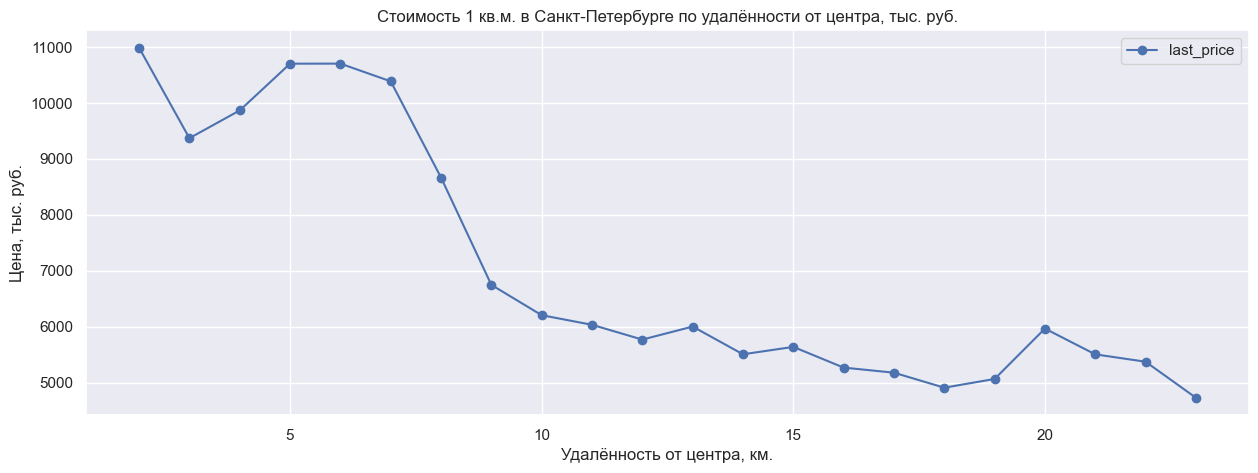

In [112]:
cost_km_dep.plot(style='o-')
plt.title('Стоимость 1 кв.м. в Санкт-Петербурге по удалённости от центра, тыс. руб.')
plt.ylabel('Цена, тыс. руб.')
plt.xlabel('Удалённость от центра, км.')

plt.show()

Несмотря на то, что коэффициент корреляции (-0.4) показывает достаточно слабое влияние удалённости от центра Санкт-Петербурга на стоимость 1 кв. м. жилья, по графику чётко видна отрицательная зависимость: чем дальше от центра, тем ниже цена. Такой низкий коэффициент корреляции может быть из-за выбросов, влияющих на распределение данных, или существуют факторы, которые влияют на результат сильнее, чем удалённость от центра. Исходя из предыдущего анализа, можно предположить, что такими факторами являются площадь квартиры или же количество комнат. 

На графике присутствует пик стоимости примерно на 20 км от центра города, где могут находиться элитные посёлки

## ОБЩИЙ ВЫВОД

    Подытожим анализ:
1) На этапе предобработки данных были обнаружены множественные пропущенные значения в различных столбцах. Большая часть из них убрана: либо удалена, либо заменена подходящими значениями.  Часть пропусков оставлена как есть. Помимо этого устранены некорректные значения, а также приведены в более удобный вид названия населённых пунктов. Часть данных вводилась пользователями вручную, поэтому определённая доля пропусков является следствием ошибок ввода.
  
В дальнейшем при вводе данных стоит ограничивать диапазон вводимых значениях, если это возможно в заданном параметре, в рамках нормальных и адекватных значений.

2) На этапе исследовательского анализа данных проанализирована нормальность распределения данных в каждом из столбцов, построены соответствующие графики для визуализации данных. Где необходимо, были убраны аномалии и выбивающиеся значения. Помимо этого, сформирован отфильтрованный в рамках нормального распределения датасет для анализа взаимосвязи, по которому проводилось исследование.

3) В ходе анализа скорости продажи квартир стало ясно, что среднее время продажи квартир составляет почти 182 дня, медиана при этом равна 96 дням. Это происходит из-за наличия сверхдолгих (свыше 649 дней - это больше 21 мес.) или сверхбыстрых продаж (меньше 9 дней). Обычным временем продаж является диапазон от 45 до 232 дней. В данных присутствуют пики на "ровных" значениях (30, 45, 60, 90 дней), что, вероятно, связано с особенностями работы платформы по продаже недвижимости

4) Определены факторы, которые оказывают наибольшее и наименьшее влияние на полную стоимость квартиры. Выяснилось, что больше остальных параметров на цену квартиры влияет общая площадь. Среднее влияние на результат имеют жилая площадь, площадь кухни, количество комнат, а также расстояние до центра города. Известно, что наиболее дорогие квартиры встречаются на "средних" этажах, а ниболее дешёвые на первых. Никак не влияют на цену день, месяц и год публикации объявления о продаже.

5) Сформирована группировка стоимости 1 кв.м. среди 10 населённых пунктов с наибольшим количеством объявлений. Так, максимальная средняя стоимость жилья за 1 кв.м. наблюдается в Санкт-Петербурге и равна 114.6 тыс. руб. Минимальная же наблюдается в Выборге и равна 58.2 тыс. руб.

6) Выявлена средняя отрицательная зависимость удалённости от центра Санкт-Петербурга на среднюю цену 1 кв.м. жилья: то есть чем дальше от центра города, тем ниже стоимость 1 кв.м. 